In [1]:
# Imports

from os import system
from sys import flags
from importlib_metadata import distribution
from numpy import average, matrix
from models import *

from pathlib import *
import argparse
import pandas as pd

from models.LogisticModel import LogisticModel
from models.DecisionTreeModel import DecisionTreeModel
from models.SVM import SVM
from models.Plotter import *

import warnings
import json

warnings.filterwarnings('ignore')

repetitions=30
BoxCox_lambda=0.5

2022-12-09 11:07:03.441634: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-09 11:07:03.441655: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# Utility functions

def getFlagsFromList(l):
    """
    Translates a list of flags into a dictionary.
    """

    flags={
        'BoxCox':False,
        'Architectural':False,
        'Poly':False
    }

    for f in flags.keys():
        if f in l:
            flags[f]=True
    
    return flags

In [3]:
# *** Specify arguments here *** 

# Path to the dataset
data_path = "dataset"
model_type="Logistic"
model=None
all_paths=['dataset/Data_31Lug2022.csv','dataset/Data_30Lug2022.csv','dataset/Data_29Lug2022.csv','dataset/Data_27Lug2022.csv','dataset/Data_26Lug2022.csv','dataset/Data_25Lug2022.csv','dataset/Data_24Lug2022.csv','dataset/Data_23Lug2022.csv','dataset/Data_22Lug2022.csv','dataset/Data_21Lug2022.csv','dataset/Data_20Lug2022.csv','dataset/Data_19Lug2022.csv','dataset/Data_18Lug2022.csv','dataset/Data_17Lug2022.csv','dataset/Data_12Giu2022.csv','dataset/Data_18Giu2022.csv']


In [4]:
def SelectModel(model_type):
    
    global model
    
    if model_type.upper() == 'LOGISTIC':
        print("Selected Logistic Regression")
        model=LogisticModel()
    elif model_type.upper() == 'DECISIONTREE':
        print("Selected Decision Tree")
        model=DecisionTreeModel()
    elif model_type.upper() == 'SVM':
        print("Selected SVM")
        model=SVM()
    elif model_type.upper() == 'DNN':
        print("Selected Deep Neural Network")
        model=DNN()

In [5]:
# Save matrix as json

def SaveResults(file_name,a,p,r,f):
    
    inverse_map={
        'VERY_LOW':0,
        'LOW':1,
        'MEDIUM':2,
        'HIGH':3
    }
    
    result_dict={}
    
    for activity in {"VERY_LOW","LOW","MEDIUM","HIGH"}:
        result_dict[activity]={}
        
        for entropy in {"VERY_LOW","LOW","MEDIUM","HIGH"}:
            result_dict[activity][entropy]={}
            
            activity_num=inverse_map[activity]
            entropy_num=inverse_map[entropy]
            
            result_dict[activity][entropy]['accuracy']=a[activity_num][entropy_num]
            result_dict[activity][entropy]['precision']=p[activity_num][entropy_num]
            result_dict[activity][entropy]['recall']=r[activity_num][entropy_num]
            result_dict[activity][entropy]['f1']=f[activity_num][entropy_num]
    
    with open(file_name,"w") as f:
        json.dump(result_dict,f,indent=4)
    f.close()

In [6]:
def KFoldCrossValidation(model,paths,iterations,options=[]):
    """
    Performs cross-validation k-fold
    """

    metric_list=[]

    matrix_rec=[[0,0,0,0] for i in range(4)]
    matrix_prec=[[0,0,0,0] for i in range(4)]
    matrix_acc=[[0,0,0,0] for i in range(4)]
    matrix_f1=[[0,0,0,0] for i in range(4)]

    inverse_map={
        'VERY_LOW':0,
        'LOW':1,
        'MEDIUM':2,
        'HIGH':3
    }

    flags=getFlagsFromList(options)

    for p in paths:

        curr_metrics={
            'accuracy':0,
            'precision':0,
            'recall':0,
            'f1':0
        }
        
        meta=None
        
        for i in range(0,iterations):
            model.get_untrained_model()
            new_meta=model.load_data(p)
            
            if not new_meta is None:
                meta=new_meta
            
            activity=meta[0].removeprefix('ACTIVITY=')
            entropy=meta[1].removeprefix('ENTROPY=')
            activity=inverse_map[activity]
            entropy=inverse_map[entropy]
            
            counters_to_drop=['LSU_stim', 'CPI_stim', 'FLD_stim', 'EXC_stim','TIME']
            if not flags['Architectural']:
                counters_to_drop=[]
    
            model.set_hyperparameter_counters(counters_to_drop)

            x_train,x_test,y_train,y_test=model.load_ith_fold(i,iterations)

            if flags['Poly']:
                x_train,x_test=model.polynomial_feature_preproc(3,x_train,x_test,None,None)
            
            if flags['BoxCox']:
                print(f"Applying BoxCox with {BoxCox_lambda}")
                x_train,x_test=model.BoxCox_preproc(x_train,x_test,BoxCox_lambda)

            model.train(x_train,y_train)
            y_predicted=model.test(x_test)
            metrics=model.report(y_predicted,y_test)
            curr_metrics['accuracy']+=metrics['accuracy']
            curr_metrics['precision']+=metrics['precision']
            curr_metrics['recall']+=metrics['recall']
            curr_metrics['f1']+=metrics['f1']
        
        curr_metrics['accuracy']=curr_metrics['accuracy']/iterations
        curr_metrics['precision']=curr_metrics['precision']/iterations
        curr_metrics['recall']=curr_metrics['recall']/iterations
        curr_metrics['f1']=curr_metrics['f1']/iterations
        metric_list.append(curr_metrics)

        matrix_acc[activity][entropy]=curr_metrics['accuracy']
        matrix_prec[activity][entropy]=curr_metrics['precision']
        matrix_rec[activity][entropy]=curr_metrics['recall']
        matrix_f1[activity][entropy]=curr_metrics['f1']
    
    return matrix_acc, matrix_prec, matrix_rec, matrix_f1

In [7]:
def TestAllDatasets(model,paths,iterations,options=[]):
    """
    Test all the datasets in paths for iterations times using the input model
    and the set flags.
    """

    metric_list=[]

    matrix_rec=[[0,0,0,0] for i in range(4)]
    matrix_prec=[[0,0,0,0] for i in range(4)]
    matrix_acc=[[0,0,0,0] for i in range(4)]
    matrix_f1=[[0,0,0,0] for i in range(4)]

    inverse_map={
        'VERY_LOW':0,
        'LOW':1,
        'MEDIUM':2,
        'HIGH':3
    }

    flags=getFlagsFromList(options)

    for p in paths:

        curr_metrics={
            'accuracy':0,
            'precision':0,
            'recall':0,
            'f1':0
        }
        
        meta=None
        
        for i in range(0,iterations):
            model.get_untrained_model()
            new_meta=model.load_data(p)
            
            if not new_meta is None:
                meta=new_meta
            
            activity=meta[0].removeprefix('ACTIVITY=')
            entropy=meta[1].removeprefix('ENTROPY=')
            activity=inverse_map[activity]
            entropy=inverse_map[entropy]
            
            counters_to_drop=['LSU_stim', 'CPI_stim', 'FLD_stim', 'EXC_stim','TIME']
            if not flags['Architectural']:
                counters_to_drop=[]
    
            model.set_hyperparameter_counters(counters_to_drop)

            x_train,x_test,y_train,y_test=model.preprocess()

            if flags['Poly']:
                x_train,x_test=model.polynomial_feature_preproc(3,x_train,x_test,None,None)
            
            if flags['BoxCox']:
                x_train,x_test=model.BoxCox_preproc(x_train,x_test,BoxCox_lambda)

            model.train(x_train,y_train)
            y_predicted=model.test(x_test)

            metrics=model.report(y_predicted,y_test)
            curr_metrics['accuracy']+=metrics['accuracy']
            curr_metrics['precision']+=metrics['precision']
            curr_metrics['recall']+=metrics['recall']
            curr_metrics['f1']+=metrics['f1']
        
        curr_metrics['accuracy']=curr_metrics['accuracy']/iterations
        curr_metrics['precision']=curr_metrics['precision']/iterations
        curr_metrics['recall']=curr_metrics['recall']/iterations
        curr_metrics['f1']=curr_metrics['f1']/iterations
        metric_list.append(curr_metrics)

        matrix_acc[activity][entropy]=curr_metrics['accuracy']
        matrix_prec[activity][entropy]=curr_metrics['precision']
        matrix_rec[activity][entropy]=curr_metrics['recall']
        matrix_f1[activity][entropy]=curr_metrics['f1']
    
    return matrix_acc, matrix_prec, matrix_rec, matrix_f1

In [13]:
# First Vanilla Logistic Regression
model_type='Logistic'
options=[]
paths=['dataset/Data_31Mag2022.csv','dataset/Data_04Giu2022.csv','dataset/Data_05Giu2022.csv']
SelectModel(model_type)
model=LogisticModel()

a,p,r,f=TestAllDatasets(model,paths,repetitions,options)
LR_recall=r
LR_f1=f
LR_precision=p
LR_accuracy=a
SaveResults('Results/LR_large_malware.json',a,p,r,f)

model_type='DecisionTree'
options=[]
paths=['dataset/Data_31Mag2022.csv','dataset/Data_04Giu2022.csv','dataset/Data_05Giu2022.csv']
SelectModel(model_type)
model=LogisticModel()

a,p,r,f=TestAllDatasets(model,paths,repetitions,options)
LR_recall=r
LR_f1=f
LR_precision=p
LR_accuracy=a
SaveResults('Results/DT_large_malware.json',a,p,r,f)


model_type='SVM'
options=[]
paths=['dataset/Data_31Mag2022.csv','dataset/Data_04Giu2022.csv','dataset/Data_05Giu2022.csv']
SelectModel(model_type)
model=LogisticModel()

a,p,r,f=TestAllDatasets(model,paths,repetitions,options)
LR_recall=r
LR_f1=f
LR_precision=p
LR_accuracy=a
SaveResults('Results/SVM_large_malware.json',a,p,r,f)

Selected Logistic Regression


b'Skipping line 8975: expected 13 fields, saw 21\n'
b'Skipping line 8975: expected 13 fields, saw 21\n'
b'Skipping line 8975: expected 13 fields, saw 21\n'
b'Skipping line 8975: expected 13 fields, saw 21\n'
b'Skipping line 8975: expected 13 fields, saw 21\n'
b'Skipping line 8975: expected 13 fields, saw 21\n'
b'Skipping line 8975: expected 13 fields, saw 21\n'
b'Skipping line 8975: expected 13 fields, saw 21\n'
b'Skipping line 8975: expected 13 fields, saw 21\n'
b'Skipping line 8975: expected 13 fields, saw 21\n'
b'Skipping line 8975: expected 13 fields, saw 21\n'
b'Skipping line 8975: expected 13 fields, saw 21\n'
b'Skipping line 8975: expected 13 fields, saw 21\n'
b'Skipping line 8975: expected 13 fields, saw 21\n'
b'Skipping line 8975: expected 13 fields, saw 21\n'
b'Skipping line 8975: expected 13 fields, saw 21\n'
b'Skipping line 8975: expected 13 fields, saw 21\n'
b'Skipping line 8975: expected 13 fields, saw 21\n'
b'Skipping line 8975: expected 13 fields, saw 21\n'
b'Skipping l

Selected Decision Tree


b'Skipping line 8975: expected 13 fields, saw 21\n'
b'Skipping line 8975: expected 13 fields, saw 21\n'
b'Skipping line 8975: expected 13 fields, saw 21\n'
b'Skipping line 8975: expected 13 fields, saw 21\n'
b'Skipping line 8975: expected 13 fields, saw 21\n'
b'Skipping line 8975: expected 13 fields, saw 21\n'
b'Skipping line 8975: expected 13 fields, saw 21\n'
b'Skipping line 8975: expected 13 fields, saw 21\n'
b'Skipping line 8975: expected 13 fields, saw 21\n'
b'Skipping line 8975: expected 13 fields, saw 21\n'
b'Skipping line 8975: expected 13 fields, saw 21\n'
b'Skipping line 8975: expected 13 fields, saw 21\n'
b'Skipping line 8975: expected 13 fields, saw 21\n'
b'Skipping line 8975: expected 13 fields, saw 21\n'
b'Skipping line 8975: expected 13 fields, saw 21\n'
b'Skipping line 8975: expected 13 fields, saw 21\n'
b'Skipping line 8975: expected 13 fields, saw 21\n'
b'Skipping line 8975: expected 13 fields, saw 21\n'
b'Skipping line 8975: expected 13 fields, saw 21\n'
b'Skipping l

Selected SVM


b'Skipping line 8975: expected 13 fields, saw 21\n'
b'Skipping line 8975: expected 13 fields, saw 21\n'
b'Skipping line 8975: expected 13 fields, saw 21\n'
b'Skipping line 8975: expected 13 fields, saw 21\n'
b'Skipping line 8975: expected 13 fields, saw 21\n'
b'Skipping line 8975: expected 13 fields, saw 21\n'
b'Skipping line 8975: expected 13 fields, saw 21\n'
b'Skipping line 8975: expected 13 fields, saw 21\n'
b'Skipping line 8975: expected 13 fields, saw 21\n'
b'Skipping line 8975: expected 13 fields, saw 21\n'
b'Skipping line 8975: expected 13 fields, saw 21\n'
b'Skipping line 8975: expected 13 fields, saw 21\n'
b'Skipping line 8975: expected 13 fields, saw 21\n'
b'Skipping line 8975: expected 13 fields, saw 21\n'
b'Skipping line 8975: expected 13 fields, saw 21\n'
b'Skipping line 8975: expected 13 fields, saw 21\n'
b'Skipping line 8975: expected 13 fields, saw 21\n'
b'Skipping line 8975: expected 13 fields, saw 21\n'
b'Skipping line 8975: expected 13 fields, saw 21\n'
b'Skipping l

In [8]:
# First Vanilla Logistic Regression
model_type='Logistic'
options=[]

SelectModel(model_type)
model=LogisticModel()

a,p,r,f=TestAllDatasets(model,all_paths,repetitions,options)
LR_recall=r
LR_f1=f
LR_precision=p
LR_accuracy=a
SaveResults('Results/LR_vanilla_norm.json',a,p,r,f)

Selected Logistic Regression


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw

b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping l

In [27]:
# Vanilla Decision Tree

model_type='DecisionTree'
SelectModel(model_type)

options=[]

a,p,r,f=TestAllDatasets(model,all_paths,repetitions,options)
DT_recall=r
DT_f1=f
DT_precision=p
DT_accuracy=a
SaveResults('Results/DT_vanilla.json',a,p,r,f)

Selected Decision Tree


b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 1]


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 1 0]


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 0 ... 0 0 0]
[0 1 0 ... 0 0 0]


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 0 ... 0 0 0]
[0 1 0 ... 0 0 0]


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 1 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[1 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 1 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 1 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[1 0 0 ... 0 0 0]
[1 0 1 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[1 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 1 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[1 0 1 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 0 0]
[0 0 1 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 1]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 1 0 0]
[0 0 0 ... 0 0 1]
[0 0 0 ... 0 1 0]
[1 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[1 0 0 ... 0 0 0]
[0 0 0 ... 0 0 1]
[0 1 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 1]
[0 0 0 ... 1 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 1 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 1 ... 0 0 0]
[0 0 0 ... 1 0 0]
[0 0 1 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 1 ... 0 0 0]
[0 0 1 ... 0 0 1]
[0 1 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 1 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 1 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 1 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 1 0 ... 0 1 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[1 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 1 0 0]
[0 0 0 ... 1 0 0]
[0 0 1 ... 0 0 0]
[0 0 1 ... 0 0 0]
[0 0 1 ...

b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 1 0]
[0 1 0 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 1 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 1 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 1 0 ... 1 0 0]
[0 0 0 ... 1 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 1]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 1 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 1 0 ... 0 0 0]
[1 0 0 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 1 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[1 0 0 ... 1 1 0]
[0 0 0 ... 0 1 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 1]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[1 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 1 0 ... 1 0 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 1]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 1 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 1 ... 0 0 0]
[0 0 0 ... 0 0 0]
[1 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 1 0 ... 0 0 0]
[1 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 1 0 0]
[1 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[1 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 1 0 0]
[0 0 0 ... 0 0 0]
[1 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 1]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 1]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 1 0]
[0 0 1 ... 0 0 0]
[0 0 0 ...

b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 0 0 0]
[1 0 0 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 1 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 0 0 0]
[1 0 0 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 1 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 1 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 0 0 0]
[1 0 0 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 0 0 0]
[1 0 0 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 1 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 1 0 ... 0 0 0]
[1 0 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 1]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 1 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 0]
[0 0 1 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 0]
[0 1 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 1]
[0 0 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 1]
[0 0 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 1 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 0]
[0 0 1 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 0]
[0 1 0 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[1 0 0 ... 0 0 0]
[0 0 1 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 1 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 1 1 ... 1 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 1]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 0 ... 0 0 0]
[0 0 1 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[1 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 0 ... 0 0 0]
[0 1 0 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


In [28]:
# Vanilla SVM

model_type='SVM'
SelectModel(model_type)

options=[]

a,p,r,f=TestAllDatasets(model,all_paths,repetitions,options)
SVM_recall=r
SVM_f1=f
SVM_precision=p
SVM_accuracy=a
SaveResults('Results/SVM_vanilla.json',a,p,r,f)

Selected SVM
[0 0 0 ... 0 0 0]


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[1 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 1 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 1]
[0 0 0 ... 0 0 0]


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 1 0 ... 1 0 0]
[0 0 1 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 0 ... 0 1 0]
[0 0 1 ... 0 0 0]


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 0 ... 0 1 0]
[0 0 0 ... 0 0 0]


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 0 ... 0 0 1]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 1 0 ... 0 1 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 1 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 1 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[1 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 1 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 1 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 1 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 1 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[1 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 1 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 1 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 1 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 1 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 1 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 1 1]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 1 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 1]
[0 0 0 ... 1 0 0]
[0 0 0 ... 0 0 1]
[0 0 0 ... 1 0 0]
[0 1 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 1]
[0 0 0 ... 0 0 0]
[0 0 1 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 1]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 1 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 1 1]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[1 0 0 ... 0 0 0]
[0 0 0 ... 0 1 0]
[0 0 0 ... 0 0 0]
[0 1 1 ... 0 0 0]
[0 1 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[1 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 1 0 ... 0 1 0]
[0 0 0 ... 1 0 0]
[0 0 0 ... 1 1 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 1]
[0 1 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[1 0 0 ... 0 0 0]
[0 0 0 ... 0 1 0]
[1 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 1 1]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[1 0 0 ... 0 0 0]
[0 1 0 ...

b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 1 0]
[0 0 0 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 1]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[1 0 0 ... 0 0 0]
[1 0 0 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[1 0 0 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 1 0]
[0 0 0 ... 0 1 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 1 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 1 0 ... 1 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 1 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[1 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 1 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 1 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 1 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 1 ... 0 0 1]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 1 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 1 0]
[0 0 0 ... 0 0 0]
[1 0 0 ... 0 0 0]
[0 0 0 ... 0 0 1]
[0 0 0 ... 0 1 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 1 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 1]
[0 0 0 ... 0 0 0]
[0 0 0 ...

b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 0 0 0]
[0 1 0 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 1 0 ... 0 0 0]
[0 0 0 ... 0 0 1]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[1 0 0 ... 0 1 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 1 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 1]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 1 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 1 0 0]
[0 0 1 ... 0 1 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 1 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 1 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 1 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 1 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 1]
[0 0 1 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 1 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 1 0]
[0 0 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 1 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 0]
[1 0 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 1 1 0]
[0 0 0 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 1 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 0 ... 1 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 1]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 1 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 0 ... 0 0 1]
[0 0 0 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 1 1 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[1 0 0 ... 0 0 0]
[0 0 0 ... 1 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 0 ... 0 0 0]


In [29]:
# Logistic Regression using Architectural Counters only

all_paths=['dataset/Data_31Lug2022.csv','dataset/Data_30Lug2022.csv','dataset/Data_29Lug2022.csv','dataset/Data_27Lug2022.csv','dataset/Data_26Lug2022.csv','dataset/Data_25Lug2022.csv','dataset/Data_24Lug2022.csv','dataset/Data_23Lug2022.csv','dataset/Data_22Lug2022.csv','dataset/Data_21Lug2022.csv','dataset/Data_20Lug2022.csv','dataset/Data_19Lug2022.csv','dataset/Data_18Lug2022.csv','dataset/Data_17Lug2022.csv','dataset/Data_12Giu2022.csv','dataset/Data_18Giu2022.csv']
options=['Architectural']
model_type='Logistic'

SelectModel(model_type)

a,p,r,f=TestAllDatasets(model,all_paths,repetitions,options)
LR_arch_recall=r
LR_arch_f1=f
LR_arch_precision=p
LR_arch_accuracy=a
SaveResults('Results/LR_Architectural.json',a,p,r,f)

Selected Logistic Regression
[0 0 0 ... 0 0 0]
[0 0 1 ... 0 0 0]


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 0 ... 0 0 0]
[0 1 0 ... 0 0 0]


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 0 ... 0 1 0]
[0 0 0 ... 0 0 0]


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 1 0 0]


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 0 ... 0 1 0]
[0 0 0 ... 0 0 0]


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 0 ... 0 0 0]
[1 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 0 1]
[0 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 1]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ...

b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 1 0]
[0 0 0 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 1 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 1 0]
[0 0 0 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[1 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[1 0 0 ... 0 0 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 1]
[0 1 0 ... 0 0 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 1]
[0 0 0 ... 0 0 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 1 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[1 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 1 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 1 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 1 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 1 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 1]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ...

b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 1 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 1 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 0 1 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 0 0 0]
[1 0 0 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[1 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


In [30]:
# Decision Tree with Architectural Counters only

options=['Architectural']
model_type='DecisionTree'

SelectModel(model_type)

a,p,r,f=TestAllDatasets(model,all_paths,repetitions,options)
DT_arch_recall=r
DT_arch_f1=f
DT_arch_precision=p
DT_arch_accuracy=a
SaveResults('Results/DT_Architectural.json',a,p,r,f)


Selected Decision Tree
[0 0 0 ... 0 0 0]


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 1 0]
[0 0 0 ... 1 0 0]


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[1 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 1 0 0]
[0 0 1 ... 0 0 0]


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 1 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 0 0]
[1 0 0 ... 0 1 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 1 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 1 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 1 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 1]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[1 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 1 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 1 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 1 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 1 0 ... 0 0 1]
[0 0 0 ... 0 0 0]
[0 1 1 ... 0 0 0]
[0 1 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 1 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 1 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ...

b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[1 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[1 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 1 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 1 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 1 0 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 1 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 0 ... 0 1 0]
[0 0 0 ... 0 1 0]
[0 0 0 ... 0 0 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 1 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 1 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 1 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[1 0 1 ... 0 0 0]
[0 0 0 ... 0 0 1]
[0 0 0 ... 0 0 1]
[0 1 1 ... 0 0 0]
[1 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 1]
[0 1 1 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 1 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 1 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 1]
[0 0 1 ... 0 0 1]
[0 0 1 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ...

b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 1]
[0 0 0 ... 0 1 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[1 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 1 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 1 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 0 1 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[1 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 1 ... 0 0 0]
[1 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 1 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 1 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 0]
[1 0 0 ... 0 0 0]
[0 0 1 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 0]
[1 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 1]
[0 0 1 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 0 ... 1 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 0 ... 0 0 0]
[0 0 1 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[1 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 0 ... 0 1 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 1 0 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 1 0 0]
[0 1 0 ... 1 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[1 0 0 ... 0 0 0]
[1 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 1 0 ... 0 0 0]
[0 0 0 ... 0 0 1]
[0 0 1 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 0 ... 0 1 0]
[0 0 1 ... 0 0 0]
[0 0 1 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 1 0]
[0 0 0 ... 0 1 0]


In [32]:
# SVM with architectural counters only

options=['Architectural']
model_type='SVM'

SelectModel(model_type)

a,p,r,f=TestAllDatasets(model,all_paths,repetitions,options)
SVM_arch_recall=r
SVM_arch_f1=f
SVM_arch_precision=p
SVM_arch_accuracy=a
SaveResults('Results/SVM_Architectural.json',a,p,r,f)

Selected SVM
[0 0 0 ... 0 0 0]


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 1]


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 1 ... 0 1 0]
[0 0 0 ... 0 0 0]
[0 1 0 ... 0 0 0]


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 0 ... 0 1 0]
[0 0 0 ... 0 0 0]
[0 0 1 ... 0 0 0]


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 1 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 1 0 ... 1 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 1 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 0 1]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 1 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[1 0 0 ... 1 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[1 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 1 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 1 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 1 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 1 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 1 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 1 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 1 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[1 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 1 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 1 0 0]
[0 0 0 ... 0 1 1]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[1 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 1 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 1 0 ... 0 0 0]
[0 1 0 ... 1 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 1 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ...

b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 1 0 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 1 1]
[0 0 1 ... 0 0 1]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 1 0]
[0 0 0 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 1 0 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[1 0 0 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 1 ... 0 0 0]
[0 0 0 ... 0 0 0]
[1 0 0 ... 0 0 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 1]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 1 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 0 ... 0 1 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 1 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 1 ... 1 0 0]
[0 0 0 ... 0 0 1]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 1 0 ... 0 0 0]
[0 0 0 ... 1 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 1 0]
[0 0 0 ... 0 0 0]
[0 1 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 1 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 1]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 1 0]
[0 0 0 ... 0 0 0]
[1 1 0 ...

b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 1 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 0 0 0]
[0 0 1 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 1 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 1 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'


[1 0 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 1 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 1]


b'Skipping line 4222: expected 13 fields, saw 18\n'


[1 0 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 1 0 ... 1 1 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 1 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 1 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'


[1 0 0 ... 0 1 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 1 ... 0 1 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 0]
[0 1 0 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 0 ... 0 0 1]
[0 0 0 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 1 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 1 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 0 ... 0 1 0]
[0 0 0 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 1]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 0 ... 0 1 0]
[0 0 0 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 0 ... 0 0 0]
[0 0 1 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 0 ... 0 0 0]


In [8]:
def hyperparam_select_lambda(model_type,values):
    
    global BoxCox_lambda

    SelectModel(model_type)
    
    options=['Architectural','BoxCox']
    k=5
    
    for v in values:
        BoxCox_lambda=v
        
        print(f"Testing lambda={v}")
        a,p,r,f=KFoldCrossValidation(model,all_paths,k,options)
        
        print(f)
        
        SaveResults(f'Results/CrossValidation/{model_type}_Architectural_BoxCox_{v}.json',a,p,r,f)

In [16]:
# Try Box-Cox transformations on the models with Architectural Counters Only

# First Logistic Regression, lambda=0.5

values=[ 0.1,0.3,0.5,0.7,0.9,1.1,1.2,1.3,1.5,1.7,1.9,2.1,2.2 ]

model_type='Logistic'

hyperparam_select_lambda(model_type,values)

Selected Logistic Regression
Testing lambda=0.1
Applying BoxCox with 0.1
Applying BoxCox with 0.1


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


Applying BoxCox with 0.1
Applying BoxCox with 0.1


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


Applying BoxCox with 0.1
Applying BoxCox with 0.1
Applying BoxCox with 0.1


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


Applying BoxCox with 0.1
Applying BoxCox with 0.1
Applying BoxCox with 0.1


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


Applying BoxCox with 0.1
Applying BoxCox with 0.1


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


Applying BoxCox with 0.1
Applying BoxCox with 0.1


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


Applying BoxCox with 0.1
Applying BoxCox with 0.1


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


Applying BoxCox with 0.1
Applying BoxCox with 0.1


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


Applying BoxCox with 0.1
Applying BoxCox with 0.1
Applying BoxCox with 0.1
Applying BoxCox with 0.1
Applying BoxCox with 0.1
Applying BoxCox with 0.1
Applying BoxCox with 0.1
Applying BoxCox with 0.1
Applying BoxCox with 0.1
Applying BoxCox with 0.1
Applying BoxCox with 0.1
Applying BoxCox with 0.1
Applying BoxCox with 0.1
Applying BoxCox with 0.1
Applying BoxCox with 0.1
Applying BoxCox with 0.1
Applying BoxCox with 0.1
Applying BoxCox with 0.1
Applying BoxCox with 0.1
Applying BoxCox with 0.1
Applying BoxCox with 0.1
Applying BoxCox with 0.1
Applying BoxCox with 0.1
Applying BoxCox with 0.1
Applying BoxCox with 0.1
Applying BoxCox with 0.1
Applying BoxCox with 0.1
Applying BoxCox with 0.1
Applying BoxCox with 0.1
Applying BoxCox with 0.1
Applying BoxCox with 0.1
Applying BoxCox with 0.1
Applying BoxCox with 0.1
Applying BoxCox with 0.1
Applying BoxCox with 0.1
Applying BoxCox with 0.1
Applying BoxCox with 0.1
Applying BoxCox with 0.1
Applying BoxCox with 0.1
Applying BoxCox with 0.1


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


Applying BoxCox with 0.1
Applying BoxCox with 0.1


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


Applying BoxCox with 0.1
Applying BoxCox with 0.1


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


Applying BoxCox with 0.1
Applying BoxCox with 0.1


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


Applying BoxCox with 0.1
Applying BoxCox with 0.1


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


Applying BoxCox with 0.1
Applying BoxCox with 0.1
Applying BoxCox with 0.1


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


Applying BoxCox with 0.1
Applying BoxCox with 0.1
Applying BoxCox with 0.1


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


Applying BoxCox with 0.1
Applying BoxCox with 0.1
Applying BoxCox with 0.1


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


Applying BoxCox with 0.1
Applying BoxCox with 0.1
Applying BoxCox with 0.1


b'Skipping line 2246: expected 13 fields, saw 14\n'


Applying BoxCox with 0.1
Applying BoxCox with 0.1
Applying BoxCox with 0.1
Applying BoxCox with 0.1
Applying BoxCox with 0.1
Applying BoxCox with 0.1
Applying BoxCox with 0.1
Applying BoxCox with 0.1
Applying BoxCox with 0.1
Applying BoxCox with 0.1
Applying BoxCox with 0.1
Applying BoxCox with 0.1
Applying BoxCox with 0.1
Applying BoxCox with 0.1
Applying BoxCox with 0.1
Applying BoxCox with 0.1
Applying BoxCox with 0.1
Applying BoxCox with 0.1
Applying BoxCox with 0.1
Applying BoxCox with 0.1
Applying BoxCox with 0.1
Applying BoxCox with 0.1
Applying BoxCox with 0.1
Applying BoxCox with 0.1
Applying BoxCox with 0.1
Applying BoxCox with 0.1
Applying BoxCox with 0.1
Applying BoxCox with 0.1
Applying BoxCox with 0.1
Applying BoxCox with 0.1
Applying BoxCox with 0.1
Applying BoxCox with 0.1
Applying BoxCox with 0.1
Applying BoxCox with 0.1
Applying BoxCox with 0.1
Applying BoxCox with 0.1
Applying BoxCox with 0.1
Applying BoxCox with 0.1
Applying BoxCox with 0.1
Applying BoxCox with 0.1


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


Applying BoxCox with 0.1
Applying BoxCox with 0.1
Applying BoxCox with 0.1


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


Applying BoxCox with 0.1
Applying BoxCox with 0.1
Applying BoxCox with 0.1


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


Applying BoxCox with 0.1
Applying BoxCox with 0.1
Applying BoxCox with 0.1


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


Applying BoxCox with 0.1
Applying BoxCox with 0.1
Applying BoxCox with 0.1


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


Applying BoxCox with 0.1
Applying BoxCox with 0.1
Applying BoxCox with 0.1


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


Applying BoxCox with 0.1
Applying BoxCox with 0.1
Applying BoxCox with 0.1


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


Applying BoxCox with 0.1
Applying BoxCox with 0.1
Applying BoxCox with 0.1


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


Applying BoxCox with 0.1
Applying BoxCox with 0.1
Applying BoxCox with 0.1


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


Applying BoxCox with 0.1
Applying BoxCox with 0.1
Applying BoxCox with 0.1


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


Applying BoxCox with 0.1
[[0.854054054054054, 0.972972972972973, 0.7545454545454546, 0.8859154929577464], [0.7954545454545453, 0.4046153846153846, 0.6538461538461537, 0.8071428571428572], [0.7982758620689654, 0.4024844720496895, 0.3958904109589041, 0.8266055045871562], [0.4853932584269664, 0.44796380090497745, 0.5556962025316455, 0.5047297297297295]]
Testing lambda=0.3
Applying BoxCox with 0.3


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


Applying BoxCox with 0.3
Applying BoxCox with 0.3


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


Applying BoxCox with 0.3
Applying BoxCox with 0.3


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


Applying BoxCox with 0.3
Applying BoxCox with 0.3


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


Applying BoxCox with 0.3
Applying BoxCox with 0.3


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


Applying BoxCox with 0.3
Applying BoxCox with 0.3


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


Applying BoxCox with 0.3
Applying BoxCox with 0.3


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


Applying BoxCox with 0.3
Applying BoxCox with 0.3


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


Applying BoxCox with 0.3
Applying BoxCox with 0.3


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


Applying BoxCox with 0.3
Applying BoxCox with 0.3


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


Applying BoxCox with 0.3
Applying BoxCox with 0.3
Applying BoxCox with 0.3
Applying BoxCox with 0.3
Applying BoxCox with 0.3
Applying BoxCox with 0.3
Applying BoxCox with 0.3
Applying BoxCox with 0.3
Applying BoxCox with 0.3
Applying BoxCox with 0.3
Applying BoxCox with 0.3
Applying BoxCox with 0.3
Applying BoxCox with 0.3
Applying BoxCox with 0.3
Applying BoxCox with 0.3
Applying BoxCox with 0.3
Applying BoxCox with 0.3
Applying BoxCox with 0.3
Applying BoxCox with 0.3
Applying BoxCox with 0.3
Applying BoxCox with 0.3
Applying BoxCox with 0.3
Applying BoxCox with 0.3
Applying BoxCox with 0.3
Applying BoxCox with 0.3
Applying BoxCox with 0.3
Applying BoxCox with 0.3
Applying BoxCox with 0.3
Applying BoxCox with 0.3
Applying BoxCox with 0.3
Applying BoxCox with 0.3
Applying BoxCox with 0.3
Applying BoxCox with 0.3
Applying BoxCox with 0.3
Applying BoxCox with 0.3
Applying BoxCox with 0.3
Applying BoxCox with 0.3
Applying BoxCox with 0.3
Applying BoxCox with 0.3
Applying BoxCox with 0.3


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


Applying BoxCox with 0.3
Applying BoxCox with 0.3


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


Applying BoxCox with 0.3
Applying BoxCox with 0.3


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


Applying BoxCox with 0.3
Applying BoxCox with 0.3


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


Applying BoxCox with 0.3
Applying BoxCox with 0.3


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


Applying BoxCox with 0.3
Applying BoxCox with 0.3


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


Applying BoxCox with 0.3
Applying BoxCox with 0.3


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


Applying BoxCox with 0.3
Applying BoxCox with 0.3


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


Applying BoxCox with 0.3
Applying BoxCox with 0.3


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


Applying BoxCox with 0.3
Applying BoxCox with 0.3


b'Skipping line 2246: expected 13 fields, saw 14\n'


Applying BoxCox with 0.3
Applying BoxCox with 0.3
Applying BoxCox with 0.3
Applying BoxCox with 0.3
Applying BoxCox with 0.3
Applying BoxCox with 0.3
Applying BoxCox with 0.3
Applying BoxCox with 0.3
Applying BoxCox with 0.3
Applying BoxCox with 0.3
Applying BoxCox with 0.3
Applying BoxCox with 0.3
Applying BoxCox with 0.3
Applying BoxCox with 0.3
Applying BoxCox with 0.3
Applying BoxCox with 0.3
Applying BoxCox with 0.3
Applying BoxCox with 0.3
Applying BoxCox with 0.3
Applying BoxCox with 0.3
Applying BoxCox with 0.3
Applying BoxCox with 0.3
Applying BoxCox with 0.3
Applying BoxCox with 0.3
Applying BoxCox with 0.3
Applying BoxCox with 0.3
Applying BoxCox with 0.3
Applying BoxCox with 0.3
Applying BoxCox with 0.3
Applying BoxCox with 0.3
Applying BoxCox with 0.3
Applying BoxCox with 0.3
Applying BoxCox with 0.3
Applying BoxCox with 0.3
Applying BoxCox with 0.3
Applying BoxCox with 0.3
Applying BoxCox with 0.3
Applying BoxCox with 0.3
Applying BoxCox with 0.3
Applying BoxCox with 0.3


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


Applying BoxCox with 0.3
Applying BoxCox with 0.3


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


Applying BoxCox with 0.3
Applying BoxCox with 0.3
Applying BoxCox with 0.3


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


Applying BoxCox with 0.3
Applying BoxCox with 0.3


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


Applying BoxCox with 0.3
Applying BoxCox with 0.3


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


Applying BoxCox with 0.3
Applying BoxCox with 0.3


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


Applying BoxCox with 0.3
Applying BoxCox with 0.3


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


Applying BoxCox with 0.3
Applying BoxCox with 0.3


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


Applying BoxCox with 0.3
Applying BoxCox with 0.3


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


Applying BoxCox with 0.3
Applying BoxCox with 0.3


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


Applying BoxCox with 0.3
Applying BoxCox with 0.3


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


Applying BoxCox with 0.3
Applying BoxCox with 0.3


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


Applying BoxCox with 0.3
Applying BoxCox with 0.3


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


Applying BoxCox with 0.3
Applying BoxCox with 0.3


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


Applying BoxCox with 0.3
Applying BoxCox with 0.3
[[0.9076923076923078, 0.9866666666666666, 0.8744186046511626, 0.86056338028169], [0.8768421052631579, 0.48028169014084526, 0.8875, 0.9042553191489361], [0.8524590163934427, 0.42711864406779665, 0.5101265822784811, 0.9033057851239669], [0.54, 0.46066350710900467, 0.5777777777777776, 0.5346534653465345]]
Testing lambda=0.5


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


Applying BoxCox with 0.5
Applying BoxCox with 0.5


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


Applying BoxCox with 0.5
Applying BoxCox with 0.5


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


Applying BoxCox with 0.5
Applying BoxCox with 0.5


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


Applying BoxCox with 0.5
Applying BoxCox with 0.5


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


Applying BoxCox with 0.5
Applying BoxCox with 0.5


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


Applying BoxCox with 0.5
Applying BoxCox with 0.5


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


Applying BoxCox with 0.5
Applying BoxCox with 0.5


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


Applying BoxCox with 0.5
Applying BoxCox with 0.5


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


Applying BoxCox with 0.5
Applying BoxCox with 0.5


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


Applying BoxCox with 0.5
Applying BoxCox with 0.5
Applying BoxCox with 0.5
Applying BoxCox with 0.5
Applying BoxCox with 0.5
Applying BoxCox with 0.5
Applying BoxCox with 0.5
Applying BoxCox with 0.5
Applying BoxCox with 0.5
Applying BoxCox with 0.5
Applying BoxCox with 0.5
Applying BoxCox with 0.5
Applying BoxCox with 0.5
Applying BoxCox with 0.5
Applying BoxCox with 0.5
Applying BoxCox with 0.5
Applying BoxCox with 0.5
Applying BoxCox with 0.5
Applying BoxCox with 0.5
Applying BoxCox with 0.5
Applying BoxCox with 0.5
Applying BoxCox with 0.5
Applying BoxCox with 0.5
Applying BoxCox with 0.5
Applying BoxCox with 0.5
Applying BoxCox with 0.5
Applying BoxCox with 0.5
Applying BoxCox with 0.5
Applying BoxCox with 0.5
Applying BoxCox with 0.5
Applying BoxCox with 0.5
Applying BoxCox with 0.5
Applying BoxCox with 0.5
Applying BoxCox with 0.5
Applying BoxCox with 0.5
Applying BoxCox with 0.5
Applying BoxCox with 0.5
Applying BoxCox with 0.5
Applying BoxCox with 0.5
Applying BoxCox with 0.5


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


Applying BoxCox with 0.5
Applying BoxCox with 0.5


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


Applying BoxCox with 0.5
Applying BoxCox with 0.5


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


Applying BoxCox with 0.5
Applying BoxCox with 0.5


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


Applying BoxCox with 0.5
Applying BoxCox with 0.5


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


Applying BoxCox with 0.5
Applying BoxCox with 0.5


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


Applying BoxCox with 0.5
Applying BoxCox with 0.5


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


Applying BoxCox with 0.5
Applying BoxCox with 0.5


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


Applying BoxCox with 0.5
Applying BoxCox with 0.5


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


Applying BoxCox with 0.5
Applying BoxCox with 0.5


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


Applying BoxCox with 0.5
Applying BoxCox with 0.5
Applying BoxCox with 0.5
Applying BoxCox with 0.5
Applying BoxCox with 0.5
Applying BoxCox with 0.5
Applying BoxCox with 0.5
Applying BoxCox with 0.5
Applying BoxCox with 0.5
Applying BoxCox with 0.5
Applying BoxCox with 0.5
Applying BoxCox with 0.5
Applying BoxCox with 0.5
Applying BoxCox with 0.5
Applying BoxCox with 0.5
Applying BoxCox with 0.5
Applying BoxCox with 0.5
Applying BoxCox with 0.5
Applying BoxCox with 0.5
Applying BoxCox with 0.5
Applying BoxCox with 0.5
Applying BoxCox with 0.5
Applying BoxCox with 0.5
Applying BoxCox with 0.5
Applying BoxCox with 0.5
Applying BoxCox with 0.5
Applying BoxCox with 0.5
Applying BoxCox with 0.5
Applying BoxCox with 0.5
Applying BoxCox with 0.5
Applying BoxCox with 0.5
Applying BoxCox with 0.5
Applying BoxCox with 0.5
Applying BoxCox with 0.5
Applying BoxCox with 0.5
Applying BoxCox with 0.5
Applying BoxCox with 0.5
Applying BoxCox with 0.5
Applying BoxCox with 0.5
Applying BoxCox with 0.5


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


Applying BoxCox with 0.5
Applying BoxCox with 0.5


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


Applying BoxCox with 0.5
Applying BoxCox with 0.5


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


Applying BoxCox with 0.5
Applying BoxCox with 0.5


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


Applying BoxCox with 0.5
Applying BoxCox with 0.5


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


Applying BoxCox with 0.5
Applying BoxCox with 0.5


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


Applying BoxCox with 0.5
Applying BoxCox with 0.5


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


Applying BoxCox with 0.5
Applying BoxCox with 0.5


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


Applying BoxCox with 0.5
Applying BoxCox with 0.5


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


Applying BoxCox with 0.5
Applying BoxCox with 0.5


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


Applying BoxCox with 0.5
Applying BoxCox with 0.5


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


Applying BoxCox with 0.5
Applying BoxCox with 0.5


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


Applying BoxCox with 0.5
Applying BoxCox with 0.5


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


Applying BoxCox with 0.5
Applying BoxCox with 0.5


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


Applying BoxCox with 0.5
Applying BoxCox with 0.5


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


Applying BoxCox with 0.5
Applying BoxCox with 0.5
[[0.9076923076923078, 0.9866666666666666, 0.8862068965517242, 0.86056338028169], [0.8659574468085107, 0.5000000000000001, 0.8746835443037975, 0.9042553191489361], [0.8349999999999997, 0.4618421052631579, 0.49230769230769217, 0.8578947368421053], [0.5359550561797752, 0.4608695652173912, 0.590909090909091, 0.5399999999999999]]
Testing lambda=0.7


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


Applying BoxCox with 0.7
Applying BoxCox with 0.7
Applying BoxCox with 0.7


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


Applying BoxCox with 0.7
Applying BoxCox with 0.7
Applying BoxCox with 0.7


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


Applying BoxCox with 0.7
Applying BoxCox with 0.7
Applying BoxCox with 0.7


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


Applying BoxCox with 0.7
Applying BoxCox with 0.7


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


Applying BoxCox with 0.7
Applying BoxCox with 0.7


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


Applying BoxCox with 0.7
Applying BoxCox with 0.7


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


Applying BoxCox with 0.7
Applying BoxCox with 0.7


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


Applying BoxCox with 0.7
Applying BoxCox with 0.7


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


Applying BoxCox with 0.7
Applying BoxCox with 0.7
Applying BoxCox with 0.7
Applying BoxCox with 0.7
Applying BoxCox with 0.7
Applying BoxCox with 0.7
Applying BoxCox with 0.7
Applying BoxCox with 0.7
Applying BoxCox with 0.7
Applying BoxCox with 0.7
Applying BoxCox with 0.7
Applying BoxCox with 0.7
Applying BoxCox with 0.7
Applying BoxCox with 0.7
Applying BoxCox with 0.7
Applying BoxCox with 0.7
Applying BoxCox with 0.7
Applying BoxCox with 0.7
Applying BoxCox with 0.7
Applying BoxCox with 0.7
Applying BoxCox with 0.7
Applying BoxCox with 0.7
Applying BoxCox with 0.7
Applying BoxCox with 0.7
Applying BoxCox with 0.7
Applying BoxCox with 0.7
Applying BoxCox with 0.7
Applying BoxCox with 0.7
Applying BoxCox with 0.7
Applying BoxCox with 0.7
Applying BoxCox with 0.7
Applying BoxCox with 0.7
Applying BoxCox with 0.7
Applying BoxCox with 0.7
Applying BoxCox with 0.7
Applying BoxCox with 0.7
Applying BoxCox with 0.7
Applying BoxCox with 0.7
Applying BoxCox with 0.7
Applying BoxCox with 0.7


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


Applying BoxCox with 0.7
Applying BoxCox with 0.7


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


Applying BoxCox with 0.7
Applying BoxCox with 0.7


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


Applying BoxCox with 0.7
Applying BoxCox with 0.7


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


Applying BoxCox with 0.7
Applying BoxCox with 0.7


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


Applying BoxCox with 0.7
Applying BoxCox with 0.7


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


Applying BoxCox with 0.7
Applying BoxCox with 0.7
Applying BoxCox with 0.7


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


Applying BoxCox with 0.7
Applying BoxCox with 0.7
Applying BoxCox with 0.7


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


Applying BoxCox with 0.7
Applying BoxCox with 0.7
Applying BoxCox with 0.7


b'Skipping line 2246: expected 13 fields, saw 14\n'


Applying BoxCox with 0.7
Applying BoxCox with 0.7
Applying BoxCox with 0.7
Applying BoxCox with 0.7
Applying BoxCox with 0.7
Applying BoxCox with 0.7
Applying BoxCox with 0.7
Applying BoxCox with 0.7
Applying BoxCox with 0.7
Applying BoxCox with 0.7
Applying BoxCox with 0.7
Applying BoxCox with 0.7
Applying BoxCox with 0.7
Applying BoxCox with 0.7
Applying BoxCox with 0.7
Applying BoxCox with 0.7
Applying BoxCox with 0.7
Applying BoxCox with 0.7
Applying BoxCox with 0.7
Applying BoxCox with 0.7
Applying BoxCox with 0.7
Applying BoxCox with 0.7
Applying BoxCox with 0.7
Applying BoxCox with 0.7
Applying BoxCox with 0.7
Applying BoxCox with 0.7
Applying BoxCox with 0.7
Applying BoxCox with 0.7
Applying BoxCox with 0.7
Applying BoxCox with 0.7
Applying BoxCox with 0.7
Applying BoxCox with 0.7
Applying BoxCox with 0.7
Applying BoxCox with 0.7
Applying BoxCox with 0.7
Applying BoxCox with 0.7
Applying BoxCox with 0.7
Applying BoxCox with 0.7
Applying BoxCox with 0.7
Applying BoxCox with 0.7


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


Applying BoxCox with 0.7
Applying BoxCox with 0.7


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


Applying BoxCox with 0.7
Applying BoxCox with 0.7


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


Applying BoxCox with 0.7
Applying BoxCox with 0.7


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


Applying BoxCox with 0.7
Applying BoxCox with 0.7


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


Applying BoxCox with 0.7
Applying BoxCox with 0.7


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


Applying BoxCox with 0.7
Applying BoxCox with 0.7


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


Applying BoxCox with 0.7
Applying BoxCox with 0.7


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


Applying BoxCox with 0.7
Applying BoxCox with 0.7


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


Applying BoxCox with 0.7
Applying BoxCox with 0.7


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


Applying BoxCox with 0.7
Applying BoxCox with 0.7


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


Applying BoxCox with 0.7
Applying BoxCox with 0.7


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


Applying BoxCox with 0.7
Applying BoxCox with 0.7


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


Applying BoxCox with 0.7
Applying BoxCox with 0.7


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


Applying BoxCox with 0.7
Applying BoxCox with 0.7


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


Applying BoxCox with 0.7
Applying BoxCox with 0.7
[[0.8815789473684209, 0.9866666666666666, 0.7835443037974684, 0.8304347826086957], [0.7954545454545453, 0.5000000000000001, 0.82, 0.8448275862068965], [0.8260504201680672, 0.44516129032258067, 0.23636363636363633, 0.7857142857142858], [0.5555555555555556, 0.48, 0.5640625000000001, 0.5446153846153845]]
Testing lambda=0.9
Applying BoxCox with 0.9
Applying BoxCox with 0.9


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


Applying BoxCox with 0.9
Applying BoxCox with 0.9


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


Applying BoxCox with 0.9
Applying BoxCox with 0.9


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


Applying BoxCox with 0.9
Applying BoxCox with 0.9


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


Applying BoxCox with 0.9
Applying BoxCox with 0.9


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


Applying BoxCox with 0.9
Applying BoxCox with 0.9


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


Applying BoxCox with 0.9
Applying BoxCox with 0.9
Applying BoxCox with 0.9


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


Applying BoxCox with 0.9
Applying BoxCox with 0.9
Applying BoxCox with 0.9


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


Applying BoxCox with 0.9
Applying BoxCox with 0.9
Applying BoxCox with 0.9
Applying BoxCox with 0.9
Applying BoxCox with 0.9
Applying BoxCox with 0.9
Applying BoxCox with 0.9
Applying BoxCox with 0.9
Applying BoxCox with 0.9
Applying BoxCox with 0.9
Applying BoxCox with 0.9
Applying BoxCox with 0.9
Applying BoxCox with 0.9
Applying BoxCox with 0.9
Applying BoxCox with 0.9
Applying BoxCox with 0.9
Applying BoxCox with 0.9
Applying BoxCox with 0.9
Applying BoxCox with 0.9
Applying BoxCox with 0.9
Applying BoxCox with 0.9
Applying BoxCox with 0.9
Applying BoxCox with 0.9
Applying BoxCox with 0.9
Applying BoxCox with 0.9
Applying BoxCox with 0.9
Applying BoxCox with 0.9
Applying BoxCox with 0.9
Applying BoxCox with 0.9
Applying BoxCox with 0.9
Applying BoxCox with 0.9
Applying BoxCox with 0.9
Applying BoxCox with 0.9
Applying BoxCox with 0.9
Applying BoxCox with 0.9
Applying BoxCox with 0.9
Applying BoxCox with 0.9
Applying BoxCox with 0.9
Applying BoxCox with 0.9
Applying BoxCox with 0.9


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


Applying BoxCox with 0.9
Applying BoxCox with 0.9


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


Applying BoxCox with 0.9
Applying BoxCox with 0.9


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


Applying BoxCox with 0.9
Applying BoxCox with 0.9


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


Applying BoxCox with 0.9
Applying BoxCox with 0.9


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


Applying BoxCox with 0.9
Applying BoxCox with 0.9


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


Applying BoxCox with 0.9
Applying BoxCox with 0.9
Applying BoxCox with 0.9


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


Applying BoxCox with 0.9
Applying BoxCox with 0.9
Applying BoxCox with 0.9


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


Applying BoxCox with 0.9
Applying BoxCox with 0.9
Applying BoxCox with 0.9


b'Skipping line 2246: expected 13 fields, saw 14\n'


Applying BoxCox with 0.9
Applying BoxCox with 0.9
Applying BoxCox with 0.9
Applying BoxCox with 0.9
Applying BoxCox with 0.9
Applying BoxCox with 0.9
Applying BoxCox with 0.9
Applying BoxCox with 0.9
Applying BoxCox with 0.9
Applying BoxCox with 0.9
Applying BoxCox with 0.9
Applying BoxCox with 0.9
Applying BoxCox with 0.9
Applying BoxCox with 0.9
Applying BoxCox with 0.9
Applying BoxCox with 0.9
Applying BoxCox with 0.9
Applying BoxCox with 0.9
Applying BoxCox with 0.9
Applying BoxCox with 0.9
Applying BoxCox with 0.9
Applying BoxCox with 0.9
Applying BoxCox with 0.9
Applying BoxCox with 0.9
Applying BoxCox with 0.9
Applying BoxCox with 0.9
Applying BoxCox with 0.9
Applying BoxCox with 0.9
Applying BoxCox with 0.9
Applying BoxCox with 0.9
Applying BoxCox with 0.9
Applying BoxCox with 0.9
Applying BoxCox with 0.9
Applying BoxCox with 0.9
Applying BoxCox with 0.9
Applying BoxCox with 0.9
Applying BoxCox with 0.9
Applying BoxCox with 0.9
Applying BoxCox with 0.9
Applying BoxCox with 0.9


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


Applying BoxCox with 0.9
Applying BoxCox with 0.9
Applying BoxCox with 0.9


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


Applying BoxCox with 0.9
Applying BoxCox with 0.9
Applying BoxCox with 0.9


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


Applying BoxCox with 0.9
Applying BoxCox with 0.9
Applying BoxCox with 0.9


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


Applying BoxCox with 0.9
Applying BoxCox with 0.9
Applying BoxCox with 0.9


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


Applying BoxCox with 0.9
Applying BoxCox with 0.9
Applying BoxCox with 0.9


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


Applying BoxCox with 0.9
Applying BoxCox with 0.9
Applying BoxCox with 0.9


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


Applying BoxCox with 0.9
Applying BoxCox with 0.9
Applying BoxCox with 0.9


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


Applying BoxCox with 0.9
Applying BoxCox with 0.9
Applying BoxCox with 0.9


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


Applying BoxCox with 0.9
Applying BoxCox with 0.9
Applying BoxCox with 0.9


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


Applying BoxCox with 0.9
[[0.8815789473684209, 0.9866666666666666, 0.7524999999999997, 0.8457142857142855], [0.7428571428571429, 0.3571428571428571, 0.17346938775510204, 0.6279999999999999], [0.2975609756097561, 0.2343283582089552, 0.15714285714285714, 0.22162162162162158], [0.20227272727272724, 0.11956521739130435, 0.2354838709677419, 0.3057142857142857]]
Testing lambda=1.1
Applying BoxCox with 1.1
Applying BoxCox with 1.1


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


Applying BoxCox with 1.1
Applying BoxCox with 1.1
Applying BoxCox with 1.1


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


Applying BoxCox with 1.1
Applying BoxCox with 1.1
Applying BoxCox with 1.1


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


Applying BoxCox with 1.1
Applying BoxCox with 1.1
Applying BoxCox with 1.1


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


Applying BoxCox with 1.1
Applying BoxCox with 1.1


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


Applying BoxCox with 1.1
Applying BoxCox with 1.1


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


Applying BoxCox with 1.1
Applying BoxCox with 1.1


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


Applying BoxCox with 1.1
Applying BoxCox with 1.1


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


Applying BoxCox with 1.1
Applying BoxCox with 1.1
Applying BoxCox with 1.1
Applying BoxCox with 1.1
Applying BoxCox with 1.1
Applying BoxCox with 1.1
Applying BoxCox with 1.1
Applying BoxCox with 1.1
Applying BoxCox with 1.1
Applying BoxCox with 1.1
Applying BoxCox with 1.1
Applying BoxCox with 1.1
Applying BoxCox with 1.1
Applying BoxCox with 1.1
Applying BoxCox with 1.1
Applying BoxCox with 1.1
Applying BoxCox with 1.1
Applying BoxCox with 1.1
Applying BoxCox with 1.1
Applying BoxCox with 1.1
Applying BoxCox with 1.1
Applying BoxCox with 1.1
Applying BoxCox with 1.1
Applying BoxCox with 1.1
Applying BoxCox with 1.1
Applying BoxCox with 1.1
Applying BoxCox with 1.1
Applying BoxCox with 1.1
Applying BoxCox with 1.1
Applying BoxCox with 1.1
Applying BoxCox with 1.1
Applying BoxCox with 1.1
Applying BoxCox with 1.1
Applying BoxCox with 1.1
Applying BoxCox with 1.1
Applying BoxCox with 1.1
Applying BoxCox with 1.1
Applying BoxCox with 1.1
Applying BoxCox with 1.1
Applying BoxCox with 1.1


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


Applying BoxCox with 1.1
Applying BoxCox with 1.1


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


Applying BoxCox with 1.1
Applying BoxCox with 1.1


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


Applying BoxCox with 1.1
Applying BoxCox with 1.1


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


Applying BoxCox with 1.1
Applying BoxCox with 1.1


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


Applying BoxCox with 1.1
Applying BoxCox with 1.1
Applying BoxCox with 1.1


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


Applying BoxCox with 1.1
Applying BoxCox with 1.1
Applying BoxCox with 1.1


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


Applying BoxCox with 1.1
Applying BoxCox with 1.1
Applying BoxCox with 1.1


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


Applying BoxCox with 1.1
Applying BoxCox with 1.1
Applying BoxCox with 1.1


b'Skipping line 2246: expected 13 fields, saw 14\n'


Applying BoxCox with 1.1
Applying BoxCox with 1.1
Applying BoxCox with 1.1
Applying BoxCox with 1.1
Applying BoxCox with 1.1
Applying BoxCox with 1.1
Applying BoxCox with 1.1
Applying BoxCox with 1.1
Applying BoxCox with 1.1
Applying BoxCox with 1.1
Applying BoxCox with 1.1
Applying BoxCox with 1.1
Applying BoxCox with 1.1
Applying BoxCox with 1.1
Applying BoxCox with 1.1
Applying BoxCox with 1.1
Applying BoxCox with 1.1
Applying BoxCox with 1.1
Applying BoxCox with 1.1
Applying BoxCox with 1.1
Applying BoxCox with 1.1
Applying BoxCox with 1.1
Applying BoxCox with 1.1
Applying BoxCox with 1.1
Applying BoxCox with 1.1
Applying BoxCox with 1.1
Applying BoxCox with 1.1
Applying BoxCox with 1.1
Applying BoxCox with 1.1
Applying BoxCox with 1.1
Applying BoxCox with 1.1
Applying BoxCox with 1.1
Applying BoxCox with 1.1
Applying BoxCox with 1.1
Applying BoxCox with 1.1
Applying BoxCox with 1.1
Applying BoxCox with 1.1
Applying BoxCox with 1.1
Applying BoxCox with 1.1
Applying BoxCox with 1.1


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


Applying BoxCox with 1.1
Applying BoxCox with 1.1
Applying BoxCox with 1.1


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


Applying BoxCox with 1.1
Applying BoxCox with 1.1
Applying BoxCox with 1.1


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


Applying BoxCox with 1.1
Applying BoxCox with 1.1
Applying BoxCox with 1.1


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


Applying BoxCox with 1.1
Applying BoxCox with 1.1
Applying BoxCox with 1.1


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


Applying BoxCox with 1.1
Applying BoxCox with 1.1
Applying BoxCox with 1.1


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


Applying BoxCox with 1.1
Applying BoxCox with 1.1
Applying BoxCox with 1.1


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


Applying BoxCox with 1.1
Applying BoxCox with 1.1
Applying BoxCox with 1.1


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


Applying BoxCox with 1.1
Applying BoxCox with 1.1
Applying BoxCox with 1.1


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


Applying BoxCox with 1.1
Applying BoxCox with 1.1
Applying BoxCox with 1.1


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


Applying BoxCox with 1.1
Applying BoxCox with 1.1
[[0.8815789473684209, 0.9866666666666666, 0.7524999999999997, 0.8457142857142855], [0.7954545454545453, 0.3571428571428571, 0.17346938775510204, 0.6279999999999999], [0.2975609756097561, 0.2588235294117648, 0.15714285714285714, 0.22000000000000003], [0.22134831460674156, 0.15744680851063828, 0.26875, 0.3042553191489361]]
Testing lambda=1.2
Applying BoxCox with 1.2


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


Applying BoxCox with 1.2
Applying BoxCox with 1.2
Applying BoxCox with 1.2


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


Applying BoxCox with 1.2
Applying BoxCox with 1.2
Applying BoxCox with 1.2


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


Applying BoxCox with 1.2
Applying BoxCox with 1.2
Applying BoxCox with 1.2


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


Applying BoxCox with 1.2
Applying BoxCox with 1.2
Applying BoxCox with 1.2


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


Applying BoxCox with 1.2
Applying BoxCox with 1.2


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


Applying BoxCox with 1.2
Applying BoxCox with 1.2
Applying BoxCox with 1.2


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


Applying BoxCox with 1.2
Applying BoxCox with 1.2


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


Applying BoxCox with 1.2
Applying BoxCox with 1.2
Applying BoxCox with 1.2
Applying BoxCox with 1.2
Applying BoxCox with 1.2
Applying BoxCox with 1.2
Applying BoxCox with 1.2
Applying BoxCox with 1.2
Applying BoxCox with 1.2
Applying BoxCox with 1.2
Applying BoxCox with 1.2
Applying BoxCox with 1.2
Applying BoxCox with 1.2
Applying BoxCox with 1.2
Applying BoxCox with 1.2
Applying BoxCox with 1.2
Applying BoxCox with 1.2
Applying BoxCox with 1.2
Applying BoxCox with 1.2
Applying BoxCox with 1.2
Applying BoxCox with 1.2
Applying BoxCox with 1.2
Applying BoxCox with 1.2
Applying BoxCox with 1.2
Applying BoxCox with 1.2
Applying BoxCox with 1.2
Applying BoxCox with 1.2
Applying BoxCox with 1.2
Applying BoxCox with 1.2
Applying BoxCox with 1.2
Applying BoxCox with 1.2
Applying BoxCox with 1.2
Applying BoxCox with 1.2
Applying BoxCox with 1.2
Applying BoxCox with 1.2
Applying BoxCox with 1.2
Applying BoxCox with 1.2
Applying BoxCox with 1.2
Applying BoxCox with 1.2
Applying BoxCox with 1.2


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


Applying BoxCox with 1.2
Applying BoxCox with 1.2


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


Applying BoxCox with 1.2
Applying BoxCox with 1.2


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


Applying BoxCox with 1.2
Applying BoxCox with 1.2


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


Applying BoxCox with 1.2
Applying BoxCox with 1.2


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


Applying BoxCox with 1.2
Applying BoxCox with 1.2


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


Applying BoxCox with 1.2
Applying BoxCox with 1.2
Applying BoxCox with 1.2


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


Applying BoxCox with 1.2
Applying BoxCox with 1.2
Applying BoxCox with 1.2


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


Applying BoxCox with 1.2
Applying BoxCox with 1.2
Applying BoxCox with 1.2


b'Skipping line 2246: expected 13 fields, saw 14\n'


Applying BoxCox with 1.2
Applying BoxCox with 1.2
Applying BoxCox with 1.2
Applying BoxCox with 1.2
Applying BoxCox with 1.2
Applying BoxCox with 1.2
Applying BoxCox with 1.2
Applying BoxCox with 1.2
Applying BoxCox with 1.2
Applying BoxCox with 1.2
Applying BoxCox with 1.2
Applying BoxCox with 1.2
Applying BoxCox with 1.2
Applying BoxCox with 1.2
Applying BoxCox with 1.2
Applying BoxCox with 1.2
Applying BoxCox with 1.2
Applying BoxCox with 1.2
Applying BoxCox with 1.2
Applying BoxCox with 1.2
Applying BoxCox with 1.2
Applying BoxCox with 1.2
Applying BoxCox with 1.2
Applying BoxCox with 1.2
Applying BoxCox with 1.2
Applying BoxCox with 1.2
Applying BoxCox with 1.2
Applying BoxCox with 1.2
Applying BoxCox with 1.2
Applying BoxCox with 1.2
Applying BoxCox with 1.2
Applying BoxCox with 1.2
Applying BoxCox with 1.2
Applying BoxCox with 1.2
Applying BoxCox with 1.2
Applying BoxCox with 1.2
Applying BoxCox with 1.2
Applying BoxCox with 1.2
Applying BoxCox with 1.2
Applying BoxCox with 1.2


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


Applying BoxCox with 1.2
Applying BoxCox with 1.2
Applying BoxCox with 1.2


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


Applying BoxCox with 1.2
Applying BoxCox with 1.2
Applying BoxCox with 1.2


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


Applying BoxCox with 1.2
Applying BoxCox with 1.2
Applying BoxCox with 1.2


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


Applying BoxCox with 1.2
Applying BoxCox with 1.2
Applying BoxCox with 1.2


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


Applying BoxCox with 1.2
Applying BoxCox with 1.2
Applying BoxCox with 1.2


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


Applying BoxCox with 1.2
Applying BoxCox with 1.2
Applying BoxCox with 1.2


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


Applying BoxCox with 1.2
Applying BoxCox with 1.2
Applying BoxCox with 1.2


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


Applying BoxCox with 1.2
Applying BoxCox with 1.2
Applying BoxCox with 1.2


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


Applying BoxCox with 1.2
Applying BoxCox with 1.2
Applying BoxCox with 1.2


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


Applying BoxCox with 1.2
Applying BoxCox with 1.2
Applying BoxCox with 1.2
[[0.8815789473684209, 0.9866666666666666, 0.760759493670886, 0.8457142857142855], [0.7697674418604651, 0.38125, 0.17346938775510204, 0.6279999999999999], [0.2975609756097561, 0.2588235294117648, 0.1, 0.26363636363636367], [0.22134831460674156, 0.15744680851063828, 0.28556701030927834, 0.3042553191489361]]
Testing lambda=1.3
Applying BoxCox with 1.3
Applying BoxCox with 1.3


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


Applying BoxCox with 1.3
Applying BoxCox with 1.3
Applying BoxCox with 1.3


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


Applying BoxCox with 1.3
Applying BoxCox with 1.3
Applying BoxCox with 1.3


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


Applying BoxCox with 1.3
Applying BoxCox with 1.3
Applying BoxCox with 1.3


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


Applying BoxCox with 1.3
Applying BoxCox with 1.3


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


Applying BoxCox with 1.3
Applying BoxCox with 1.3


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


Applying BoxCox with 1.3
Applying BoxCox with 1.3


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


Applying BoxCox with 1.3
Applying BoxCox with 1.3


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


Applying BoxCox with 1.3
Applying BoxCox with 1.3
Applying BoxCox with 1.3
Applying BoxCox with 1.3
Applying BoxCox with 1.3
Applying BoxCox with 1.3
Applying BoxCox with 1.3
Applying BoxCox with 1.3
Applying BoxCox with 1.3
Applying BoxCox with 1.3
Applying BoxCox with 1.3
Applying BoxCox with 1.3
Applying BoxCox with 1.3
Applying BoxCox with 1.3
Applying BoxCox with 1.3
Applying BoxCox with 1.3
Applying BoxCox with 1.3
Applying BoxCox with 1.3
Applying BoxCox with 1.3
Applying BoxCox with 1.3
Applying BoxCox with 1.3
Applying BoxCox with 1.3
Applying BoxCox with 1.3
Applying BoxCox with 1.3
Applying BoxCox with 1.3
Applying BoxCox with 1.3
Applying BoxCox with 1.3
Applying BoxCox with 1.3
Applying BoxCox with 1.3
Applying BoxCox with 1.3
Applying BoxCox with 1.3
Applying BoxCox with 1.3
Applying BoxCox with 1.3
Applying BoxCox with 1.3
Applying BoxCox with 1.3
Applying BoxCox with 1.3
Applying BoxCox with 1.3
Applying BoxCox with 1.3
Applying BoxCox with 1.3
Applying BoxCox with 1.3


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


Applying BoxCox with 1.3
Applying BoxCox with 1.3


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


Applying BoxCox with 1.3
Applying BoxCox with 1.3


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


Applying BoxCox with 1.3
Applying BoxCox with 1.3


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


Applying BoxCox with 1.3
Applying BoxCox with 1.3


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


Applying BoxCox with 1.3
Applying BoxCox with 1.3
Applying BoxCox with 1.3


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


Applying BoxCox with 1.3
Applying BoxCox with 1.3
Applying BoxCox with 1.3


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


Applying BoxCox with 1.3
Applying BoxCox with 1.3
Applying BoxCox with 1.3


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


Applying BoxCox with 1.3
Applying BoxCox with 1.3
Applying BoxCox with 1.3


b'Skipping line 2246: expected 13 fields, saw 14\n'


Applying BoxCox with 1.3
Applying BoxCox with 1.3
Applying BoxCox with 1.3
Applying BoxCox with 1.3
Applying BoxCox with 1.3
Applying BoxCox with 1.3
Applying BoxCox with 1.3
Applying BoxCox with 1.3
Applying BoxCox with 1.3
Applying BoxCox with 1.3
Applying BoxCox with 1.3
Applying BoxCox with 1.3
Applying BoxCox with 1.3
Applying BoxCox with 1.3
Applying BoxCox with 1.3
Applying BoxCox with 1.3
Applying BoxCox with 1.3
Applying BoxCox with 1.3
Applying BoxCox with 1.3
Applying BoxCox with 1.3
Applying BoxCox with 1.3
Applying BoxCox with 1.3
Applying BoxCox with 1.3
Applying BoxCox with 1.3
Applying BoxCox with 1.3
Applying BoxCox with 1.3
Applying BoxCox with 1.3
Applying BoxCox with 1.3
Applying BoxCox with 1.3
Applying BoxCox with 1.3
Applying BoxCox with 1.3
Applying BoxCox with 1.3
Applying BoxCox with 1.3
Applying BoxCox with 1.3
Applying BoxCox with 1.3
Applying BoxCox with 1.3
Applying BoxCox with 1.3
Applying BoxCox with 1.3
Applying BoxCox with 1.3
Applying BoxCox with 1.3


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


Applying BoxCox with 1.3
Applying BoxCox with 1.3
Applying BoxCox with 1.3


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


Applying BoxCox with 1.3
Applying BoxCox with 1.3
Applying BoxCox with 1.3


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


Applying BoxCox with 1.3
Applying BoxCox with 1.3
Applying BoxCox with 1.3


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


Applying BoxCox with 1.3
Applying BoxCox with 1.3
Applying BoxCox with 1.3


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


Applying BoxCox with 1.3
Applying BoxCox with 1.3
Applying BoxCox with 1.3


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


Applying BoxCox with 1.3
Applying BoxCox with 1.3
Applying BoxCox with 1.3


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


Applying BoxCox with 1.3
Applying BoxCox with 1.3
Applying BoxCox with 1.3


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


Applying BoxCox with 1.3
Applying BoxCox with 1.3
Applying BoxCox with 1.3


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


Applying BoxCox with 1.3
Applying BoxCox with 1.3
Applying BoxCox with 1.3


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


Applying BoxCox with 1.3
Applying BoxCox with 1.3
[[0.8815789473684209, 0.9866666666666666, 0.7289156626506024, 0.8457142857142855], [0.3571428571428571, 0.38125, 0.17346938775510204, 0.6279999999999999], [0.2975609756097561, 0.25652173913043486, 0.1, 0.26363636363636367], [0.22134831460674156, 0.15744680851063828, 0.28367346938775506, 0.3375]]
Testing lambda=1.5
Applying BoxCox with 1.5


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


Applying BoxCox with 1.5
Applying BoxCox with 1.5
Applying BoxCox with 1.5


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


Applying BoxCox with 1.5
Applying BoxCox with 1.5
Applying BoxCox with 1.5


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


Applying BoxCox with 1.5
Applying BoxCox with 1.5
Applying BoxCox with 1.5


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


Applying BoxCox with 1.5
Applying BoxCox with 1.5


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


Applying BoxCox with 1.5
Applying BoxCox with 1.5


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


Applying BoxCox with 1.5
Applying BoxCox with 1.5


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


Applying BoxCox with 1.5
Applying BoxCox with 1.5


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


Applying BoxCox with 1.5
Applying BoxCox with 1.5


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


Applying BoxCox with 1.5
Applying BoxCox with 1.5
Applying BoxCox with 1.5
Applying BoxCox with 1.5
Applying BoxCox with 1.5
Applying BoxCox with 1.5
Applying BoxCox with 1.5
Applying BoxCox with 1.5
Applying BoxCox with 1.5
Applying BoxCox with 1.5
Applying BoxCox with 1.5
Applying BoxCox with 1.5
Applying BoxCox with 1.5
Applying BoxCox with 1.5
Applying BoxCox with 1.5
Applying BoxCox with 1.5
Applying BoxCox with 1.5
Applying BoxCox with 1.5
Applying BoxCox with 1.5
Applying BoxCox with 1.5
Applying BoxCox with 1.5
Applying BoxCox with 1.5
Applying BoxCox with 1.5
Applying BoxCox with 1.5
Applying BoxCox with 1.5
Applying BoxCox with 1.5
Applying BoxCox with 1.5
Applying BoxCox with 1.5
Applying BoxCox with 1.5
Applying BoxCox with 1.5
Applying BoxCox with 1.5
Applying BoxCox with 1.5
Applying BoxCox with 1.5
Applying BoxCox with 1.5
Applying BoxCox with 1.5
Applying BoxCox with 1.5
Applying BoxCox with 1.5
Applying BoxCox with 1.5
Applying BoxCox with 1.5
Applying BoxCox with 1.5


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


Applying BoxCox with 1.5
Applying BoxCox with 1.5


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


Applying BoxCox with 1.5
Applying BoxCox with 1.5


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


Applying BoxCox with 1.5
Applying BoxCox with 1.5


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


Applying BoxCox with 1.5
Applying BoxCox with 1.5


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


Applying BoxCox with 1.5
Applying BoxCox with 1.5
Applying BoxCox with 1.5


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


Applying BoxCox with 1.5
Applying BoxCox with 1.5
Applying BoxCox with 1.5


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


Applying BoxCox with 1.5
Applying BoxCox with 1.5
Applying BoxCox with 1.5


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


Applying BoxCox with 1.5
Applying BoxCox with 1.5
Applying BoxCox with 1.5


b'Skipping line 2246: expected 13 fields, saw 14\n'


Applying BoxCox with 1.5
Applying BoxCox with 1.5
Applying BoxCox with 1.5
Applying BoxCox with 1.5
Applying BoxCox with 1.5
Applying BoxCox with 1.5
Applying BoxCox with 1.5
Applying BoxCox with 1.5
Applying BoxCox with 1.5
Applying BoxCox with 1.5
Applying BoxCox with 1.5
Applying BoxCox with 1.5
Applying BoxCox with 1.5
Applying BoxCox with 1.5
Applying BoxCox with 1.5
Applying BoxCox with 1.5
Applying BoxCox with 1.5
Applying BoxCox with 1.5
Applying BoxCox with 1.5
Applying BoxCox with 1.5
Applying BoxCox with 1.5
Applying BoxCox with 1.5
Applying BoxCox with 1.5
Applying BoxCox with 1.5
Applying BoxCox with 1.5
Applying BoxCox with 1.5
Applying BoxCox with 1.5
Applying BoxCox with 1.5
Applying BoxCox with 1.5
Applying BoxCox with 1.5
Applying BoxCox with 1.5
Applying BoxCox with 1.5
Applying BoxCox with 1.5
Applying BoxCox with 1.5
Applying BoxCox with 1.5
Applying BoxCox with 1.5
Applying BoxCox with 1.5
Applying BoxCox with 1.5
Applying BoxCox with 1.5
Applying BoxCox with 1.5


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


Applying BoxCox with 1.5
Applying BoxCox with 1.5
Applying BoxCox with 1.5


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


Applying BoxCox with 1.5
Applying BoxCox with 1.5
Applying BoxCox with 1.5


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


Applying BoxCox with 1.5
Applying BoxCox with 1.5
Applying BoxCox with 1.5


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


Applying BoxCox with 1.5
Applying BoxCox with 1.5


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


Applying BoxCox with 1.5
Applying BoxCox with 1.5
Applying BoxCox with 1.5


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


Applying BoxCox with 1.5
Applying BoxCox with 1.5
Applying BoxCox with 1.5


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


Applying BoxCox with 1.5
Applying BoxCox with 1.5
Applying BoxCox with 1.5


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


Applying BoxCox with 1.5
Applying BoxCox with 1.5
Applying BoxCox with 1.5


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


Applying BoxCox with 1.5
Applying BoxCox with 1.5
Applying BoxCox with 1.5


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


Applying BoxCox with 1.5
Applying BoxCox with 1.5
[[0.868, 0.9866666666666666, 0.7444444444444442, 0.8457142857142855], [0.1, 0.38125, 0.17346938775510204, 0.6279999999999999], [0.3168674698795181, 0.27999999999999997, 0.1, 0.28227848101265823], [0.24, 0.15744680851063828, 0.316, 0.38993288590604025]]
Testing lambda=1.7
Applying BoxCox with 1.7


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


Applying BoxCox with 1.7
Applying BoxCox with 1.7
Applying BoxCox with 1.7


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


Applying BoxCox with 1.7
Applying BoxCox with 1.7
Applying BoxCox with 1.7


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


Applying BoxCox with 1.7
Applying BoxCox with 1.7
Applying BoxCox with 1.7


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


Applying BoxCox with 1.7
Applying BoxCox with 1.7


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


Applying BoxCox with 1.7
Applying BoxCox with 1.7


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


Applying BoxCox with 1.7
Applying BoxCox with 1.7


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


Applying BoxCox with 1.7
Applying BoxCox with 1.7


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


Applying BoxCox with 1.7
Applying BoxCox with 1.7


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


Applying BoxCox with 1.7
Applying BoxCox with 1.7
Applying BoxCox with 1.7
Applying BoxCox with 1.7
Applying BoxCox with 1.7
Applying BoxCox with 1.7
Applying BoxCox with 1.7
Applying BoxCox with 1.7
Applying BoxCox with 1.7
Applying BoxCox with 1.7
Applying BoxCox with 1.7
Applying BoxCox with 1.7
Applying BoxCox with 1.7
Applying BoxCox with 1.7
Applying BoxCox with 1.7
Applying BoxCox with 1.7
Applying BoxCox with 1.7
Applying BoxCox with 1.7
Applying BoxCox with 1.7
Applying BoxCox with 1.7
Applying BoxCox with 1.7
Applying BoxCox with 1.7
Applying BoxCox with 1.7
Applying BoxCox with 1.7
Applying BoxCox with 1.7
Applying BoxCox with 1.7
Applying BoxCox with 1.7
Applying BoxCox with 1.7
Applying BoxCox with 1.7
Applying BoxCox with 1.7
Applying BoxCox with 1.7
Applying BoxCox with 1.7
Applying BoxCox with 1.7
Applying BoxCox with 1.7
Applying BoxCox with 1.7
Applying BoxCox with 1.7
Applying BoxCox with 1.7
Applying BoxCox with 1.7
Applying BoxCox with 1.7
Applying BoxCox with 1.7


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


Applying BoxCox with 1.7
Applying BoxCox with 1.7


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


Applying BoxCox with 1.7
Applying BoxCox with 1.7


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


Applying BoxCox with 1.7
Applying BoxCox with 1.7


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


Applying BoxCox with 1.7
Applying BoxCox with 1.7


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


Applying BoxCox with 1.7
Applying BoxCox with 1.7
Applying BoxCox with 1.7


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


Applying BoxCox with 1.7
Applying BoxCox with 1.7
Applying BoxCox with 1.7


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


Applying BoxCox with 1.7
Applying BoxCox with 1.7
Applying BoxCox with 1.7


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


Applying BoxCox with 1.7
Applying BoxCox with 1.7
Applying BoxCox with 1.7


b'Skipping line 2246: expected 13 fields, saw 14\n'


Applying BoxCox with 1.7
Applying BoxCox with 1.7
Applying BoxCox with 1.7
Applying BoxCox with 1.7
Applying BoxCox with 1.7
Applying BoxCox with 1.7
Applying BoxCox with 1.7
Applying BoxCox with 1.7
Applying BoxCox with 1.7
Applying BoxCox with 1.7
Applying BoxCox with 1.7
Applying BoxCox with 1.7
Applying BoxCox with 1.7
Applying BoxCox with 1.7
Applying BoxCox with 1.7
Applying BoxCox with 1.7
Applying BoxCox with 1.7
Applying BoxCox with 1.7
Applying BoxCox with 1.7
Applying BoxCox with 1.7
Applying BoxCox with 1.7
Applying BoxCox with 1.7
Applying BoxCox with 1.7
Applying BoxCox with 1.7
Applying BoxCox with 1.7
Applying BoxCox with 1.7
Applying BoxCox with 1.7
Applying BoxCox with 1.7
Applying BoxCox with 1.7
Applying BoxCox with 1.7
Applying BoxCox with 1.7
Applying BoxCox with 1.7
Applying BoxCox with 1.7
Applying BoxCox with 1.7
Applying BoxCox with 1.7
Applying BoxCox with 1.7
Applying BoxCox with 1.7
Applying BoxCox with 1.7
Applying BoxCox with 1.7
Applying BoxCox with 1.7


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


Applying BoxCox with 1.7
Applying BoxCox with 1.7
Applying BoxCox with 1.7


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


Applying BoxCox with 1.7
Applying BoxCox with 1.7
Applying BoxCox with 1.7


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


Applying BoxCox with 1.7
Applying BoxCox with 1.7
Applying BoxCox with 1.7


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


Applying BoxCox with 1.7
Applying BoxCox with 1.7


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


Applying BoxCox with 1.7
Applying BoxCox with 1.7
Applying BoxCox with 1.7


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


Applying BoxCox with 1.7
Applying BoxCox with 1.7
Applying BoxCox with 1.7


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


Applying BoxCox with 1.7
Applying BoxCox with 1.7
Applying BoxCox with 1.7


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


Applying BoxCox with 1.7
Applying BoxCox with 1.7
Applying BoxCox with 1.7


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


Applying BoxCox with 1.7
Applying BoxCox with 1.7
Applying BoxCox with 1.7


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


Applying BoxCox with 1.7
Applying BoxCox with 1.7
Applying BoxCox with 1.7


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


Applying BoxCox with 1.7
[[0.868, 1.0, 0.737974683544304, 0.8750000000000003], [0.1, 0.38125, 0.20800000000000002, 0.6279999999999999], [0.3168674698795181, 0.3028169014084507, 0.1, 0.2846153846153846], [0.23846153846153845, 0.19374999999999998, 0.28367346938775506, 0.38800000000000007]]
Testing lambda=1.9
Applying BoxCox with 1.9
Applying BoxCox with 1.9


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


Applying BoxCox with 1.9
Applying BoxCox with 1.9
Applying BoxCox with 1.9


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


Applying BoxCox with 1.9
Applying BoxCox with 1.9
Applying BoxCox with 1.9


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


Applying BoxCox with 1.9
Applying BoxCox with 1.9
Applying BoxCox with 1.9


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


Applying BoxCox with 1.9
Applying BoxCox with 1.9


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


Applying BoxCox with 1.9
Applying BoxCox with 1.9


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


Applying BoxCox with 1.9
Applying BoxCox with 1.9


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


Applying BoxCox with 1.9
Applying BoxCox with 1.9


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


Applying BoxCox with 1.9
Applying BoxCox with 1.9
Applying BoxCox with 1.9
Applying BoxCox with 1.9
Applying BoxCox with 1.9
Applying BoxCox with 1.9
Applying BoxCox with 1.9
Applying BoxCox with 1.9
Applying BoxCox with 1.9
Applying BoxCox with 1.9
Applying BoxCox with 1.9
Applying BoxCox with 1.9
Applying BoxCox with 1.9
Applying BoxCox with 1.9
Applying BoxCox with 1.9
Applying BoxCox with 1.9
Applying BoxCox with 1.9
Applying BoxCox with 1.9
Applying BoxCox with 1.9
Applying BoxCox with 1.9
Applying BoxCox with 1.9
Applying BoxCox with 1.9
Applying BoxCox with 1.9
Applying BoxCox with 1.9
Applying BoxCox with 1.9
Applying BoxCox with 1.9
Applying BoxCox with 1.9
Applying BoxCox with 1.9
Applying BoxCox with 1.9
Applying BoxCox with 1.9
Applying BoxCox with 1.9
Applying BoxCox with 1.9
Applying BoxCox with 1.9
Applying BoxCox with 1.9
Applying BoxCox with 1.9
Applying BoxCox with 1.9
Applying BoxCox with 1.9
Applying BoxCox with 1.9
Applying BoxCox with 1.9
Applying BoxCox with 1.9


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


Applying BoxCox with 1.9
Applying BoxCox with 1.9


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


Applying BoxCox with 1.9
Applying BoxCox with 1.9


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


Applying BoxCox with 1.9
Applying BoxCox with 1.9


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


Applying BoxCox with 1.9
Applying BoxCox with 1.9


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


Applying BoxCox with 1.9
Applying BoxCox with 1.9
Applying BoxCox with 1.9


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


Applying BoxCox with 1.9
Applying BoxCox with 1.9
Applying BoxCox with 1.9


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


Applying BoxCox with 1.9
Applying BoxCox with 1.9
Applying BoxCox with 1.9


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


Applying BoxCox with 1.9
Applying BoxCox with 1.9
Applying BoxCox with 1.9


b'Skipping line 2246: expected 13 fields, saw 14\n'


Applying BoxCox with 1.9
Applying BoxCox with 1.9
Applying BoxCox with 1.9
Applying BoxCox with 1.9
Applying BoxCox with 1.9
Applying BoxCox with 1.9
Applying BoxCox with 1.9
Applying BoxCox with 1.9
Applying BoxCox with 1.9
Applying BoxCox with 1.9
Applying BoxCox with 1.9
Applying BoxCox with 1.9
Applying BoxCox with 1.9
Applying BoxCox with 1.9
Applying BoxCox with 1.9
Applying BoxCox with 1.9
Applying BoxCox with 1.9
Applying BoxCox with 1.9
Applying BoxCox with 1.9
Applying BoxCox with 1.9
Applying BoxCox with 1.9
Applying BoxCox with 1.9
Applying BoxCox with 1.9
Applying BoxCox with 1.9
Applying BoxCox with 1.9
Applying BoxCox with 1.9
Applying BoxCox with 1.9
Applying BoxCox with 1.9
Applying BoxCox with 1.9
Applying BoxCox with 1.9
Applying BoxCox with 1.9
Applying BoxCox with 1.9
Applying BoxCox with 1.9
Applying BoxCox with 1.9
Applying BoxCox with 1.9
Applying BoxCox with 1.9
Applying BoxCox with 1.9
Applying BoxCox with 1.9
Applying BoxCox with 1.9
Applying BoxCox with 1.9


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


Applying BoxCox with 1.9
Applying BoxCox with 1.9
Applying BoxCox with 1.9


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


Applying BoxCox with 1.9
Applying BoxCox with 1.9
Applying BoxCox with 1.9


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


Applying BoxCox with 1.9
Applying BoxCox with 1.9
Applying BoxCox with 1.9


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


Applying BoxCox with 1.9
Applying BoxCox with 1.9
Applying BoxCox with 1.9


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


Applying BoxCox with 1.9
Applying BoxCox with 1.9
Applying BoxCox with 1.9


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


Applying BoxCox with 1.9
Applying BoxCox with 1.9
Applying BoxCox with 1.9


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


Applying BoxCox with 1.9
Applying BoxCox with 1.9
Applying BoxCox with 1.9


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


Applying BoxCox with 1.9
Applying BoxCox with 1.9
Applying BoxCox with 1.9


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


Applying BoxCox with 1.9
Applying BoxCox with 1.9
Applying BoxCox with 1.9


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


Applying BoxCox with 1.9
Applying BoxCox with 1.9
[[0.868, 1.0, 0.7524999999999997, 0.8750000000000003], [0.1, 0.4046153846153846, 0.17500000000000002, 0.5999999999999999], [0.3385542168674699, 0.3028169014084507, 0.1, 0.2846153846153846], [0.23846153846153845, 0.15744680851063828, 0.316, 0.36938775510204075]]
Testing lambda=2.1
Applying BoxCox with 2.1


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


Applying BoxCox with 2.1
Applying BoxCox with 2.1
Applying BoxCox with 2.1


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


Applying BoxCox with 2.1
Applying BoxCox with 2.1
Applying BoxCox with 2.1


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


Applying BoxCox with 2.1
Applying BoxCox with 2.1
Applying BoxCox with 2.1


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


Applying BoxCox with 2.1
Applying BoxCox with 2.1
Applying BoxCox with 2.1


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


Applying BoxCox with 2.1
Applying BoxCox with 2.1
Applying BoxCox with 2.1


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


Applying BoxCox with 2.1
Applying BoxCox with 2.1
Applying BoxCox with 2.1


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


Applying BoxCox with 2.1
Applying BoxCox with 2.1
Applying BoxCox with 2.1
Applying BoxCox with 2.1
Applying BoxCox with 2.1
Applying BoxCox with 2.1
Applying BoxCox with 2.1
Applying BoxCox with 2.1
Applying BoxCox with 2.1
Applying BoxCox with 2.1
Applying BoxCox with 2.1
Applying BoxCox with 2.1
Applying BoxCox with 2.1
Applying BoxCox with 2.1
Applying BoxCox with 2.1
Applying BoxCox with 2.1
Applying BoxCox with 2.1
Applying BoxCox with 2.1
Applying BoxCox with 2.1
Applying BoxCox with 2.1
Applying BoxCox with 2.1
Applying BoxCox with 2.1
Applying BoxCox with 2.1
Applying BoxCox with 2.1
Applying BoxCox with 2.1
Applying BoxCox with 2.1
Applying BoxCox with 2.1
Applying BoxCox with 2.1
Applying BoxCox with 2.1
Applying BoxCox with 2.1
Applying BoxCox with 2.1
Applying BoxCox with 2.1
Applying BoxCox with 2.1
Applying BoxCox with 2.1
Applying BoxCox with 2.1
Applying BoxCox with 2.1
Applying BoxCox with 2.1
Applying BoxCox with 2.1
Applying BoxCox with 2.1
Applying BoxCox with 2.1


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


Applying BoxCox with 2.1
Applying BoxCox with 2.1
Applying BoxCox with 2.1


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


Applying BoxCox with 2.1
Applying BoxCox with 2.1
Applying BoxCox with 2.1


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


Applying BoxCox with 2.1
Applying BoxCox with 2.1
Applying BoxCox with 2.1


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


Applying BoxCox with 2.1
Applying BoxCox with 2.1
Applying BoxCox with 2.1


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


Applying BoxCox with 2.1
Applying BoxCox with 2.1
Applying BoxCox with 2.1


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


Applying BoxCox with 2.1
Applying BoxCox with 2.1
Applying BoxCox with 2.1


b'Skipping line 2246: expected 13 fields, saw 14\n'


Applying BoxCox with 2.1
Applying BoxCox with 2.1
Applying BoxCox with 2.1
Applying BoxCox with 2.1
Applying BoxCox with 2.1
Applying BoxCox with 2.1
Applying BoxCox with 2.1
Applying BoxCox with 2.1
Applying BoxCox with 2.1
Applying BoxCox with 2.1
Applying BoxCox with 2.1
Applying BoxCox with 2.1
Applying BoxCox with 2.1
Applying BoxCox with 2.1
Applying BoxCox with 2.1
Applying BoxCox with 2.1
Applying BoxCox with 2.1
Applying BoxCox with 2.1
Applying BoxCox with 2.1
Applying BoxCox with 2.1
Applying BoxCox with 2.1
Applying BoxCox with 2.1
Applying BoxCox with 2.1
Applying BoxCox with 2.1
Applying BoxCox with 2.1
Applying BoxCox with 2.1
Applying BoxCox with 2.1
Applying BoxCox with 2.1
Applying BoxCox with 2.1
Applying BoxCox with 2.1
Applying BoxCox with 2.1
Applying BoxCox with 2.1
Applying BoxCox with 2.1
Applying BoxCox with 2.1
Applying BoxCox with 2.1
Applying BoxCox with 2.1
Applying BoxCox with 2.1
Applying BoxCox with 2.1
Applying BoxCox with 2.1
Applying BoxCox with 2.1


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


Applying BoxCox with 2.1
Applying BoxCox with 2.1
Applying BoxCox with 2.1


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


Applying BoxCox with 2.1
Applying BoxCox with 2.1
Applying BoxCox with 2.1


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


Applying BoxCox with 2.1
Applying BoxCox with 2.1
Applying BoxCox with 2.1


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


Applying BoxCox with 2.1
Applying BoxCox with 2.1
Applying BoxCox with 2.1


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


Applying BoxCox with 2.1
Applying BoxCox with 2.1
Applying BoxCox with 2.1


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


Applying BoxCox with 2.1
Applying BoxCox with 2.1
Applying BoxCox with 2.1


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


Applying BoxCox with 2.1
Applying BoxCox with 2.1
Applying BoxCox with 2.1


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


Applying BoxCox with 2.1
Applying BoxCox with 2.1
Applying BoxCox with 2.1


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


Applying BoxCox with 2.1
Applying BoxCox with 2.1
Applying BoxCox with 2.1


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


Applying BoxCox with 2.1
Applying BoxCox with 2.1
Applying BoxCox with 2.1
[[0.854054054054054, 0.9866666666666666, 0.7444444444444442, 0.8750000000000003], [0.1, 0.4046153846153846, 0.17500000000000002, 0.5999999999999999], [0.3195121951219512, 0.3057142857142857, 0.1, 0.2657894736842105], [0.25652173913043474, 0.13870967741935486, 0.3294117647058824, 0.2683453237410072]]
Testing lambda=2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


Applying BoxCox with 2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


Applying BoxCox with 2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


Applying BoxCox with 2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


Applying BoxCox with 2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


Applying BoxCox with 2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


Applying BoxCox with 2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


Applying BoxCox with 2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


Applying BoxCox with 2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


Applying BoxCox with 2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


Applying BoxCox with 2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


Applying BoxCox with 2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


Applying BoxCox with 2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


Applying BoxCox with 2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


Applying BoxCox with 2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2


b'Skipping line 2246: expected 13 fields, saw 14\n'


Applying BoxCox with 2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


Applying BoxCox with 2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


Applying BoxCox with 2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


Applying BoxCox with 2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


Applying BoxCox with 2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


Applying BoxCox with 2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


Applying BoxCox with 2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


Applying BoxCox with 2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


Applying BoxCox with 2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


Applying BoxCox with 2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


Applying BoxCox with 2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2
[[0.8397260273972602, 1.0, 0.7444444444444442, 0.8750000000000003], [0.1, 0.42727272727272736, 0.17500000000000002, 0.5999999999999999], [0.3195121951219512, 0.3057142857142857, 0.1, 0.24594594594594596], [0.17912087912087912, 0.15625, 0.14693877551020407, 0.16666666666666666]]


In [17]:
model_type='DecisionTree'

hyperparam_select_lambda(model_type,values)

Selected Decision Tree
Testing lambda=0.1
Applying BoxCox with 0.1
Applying BoxCox with 0.1


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


Applying BoxCox with 0.1
Applying BoxCox with 0.1


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


Applying BoxCox with 0.1
Applying BoxCox with 0.1


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


Applying BoxCox with 0.1
Applying BoxCox with 0.1


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


Applying BoxCox with 0.1
Applying BoxCox with 0.1


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


Applying BoxCox with 0.1
Applying BoxCox with 0.1


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


Applying BoxCox with 0.1
Applying BoxCox with 0.1


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


Applying BoxCox with 0.1
Applying BoxCox with 0.1


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


Applying BoxCox with 0.1
Applying BoxCox with 0.1


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


Applying BoxCox with 0.1
Applying BoxCox with 0.1
Applying BoxCox with 0.1
Applying BoxCox with 0.1
Applying BoxCox with 0.1
Applying BoxCox with 0.1
Applying BoxCox with 0.1
Applying BoxCox with 0.1
Applying BoxCox with 0.1
Applying BoxCox with 0.1
Applying BoxCox with 0.1
Applying BoxCox with 0.1
Applying BoxCox with 0.1
Applying BoxCox with 0.1
Applying BoxCox with 0.1
Applying BoxCox with 0.1
Applying BoxCox with 0.1
Applying BoxCox with 0.1
Applying BoxCox with 0.1
Applying BoxCox with 0.1
Applying BoxCox with 0.1
Applying BoxCox with 0.1
Applying BoxCox with 0.1
Applying BoxCox with 0.1
Applying BoxCox with 0.1
Applying BoxCox with 0.1
Applying BoxCox with 0.1
Applying BoxCox with 0.1
Applying BoxCox with 0.1
Applying BoxCox with 0.1
Applying BoxCox with 0.1
Applying BoxCox with 0.1
Applying BoxCox with 0.1
Applying BoxCox with 0.1
Applying BoxCox with 0.1
Applying BoxCox with 0.1
Applying BoxCox with 0.1
Applying BoxCox with 0.1
Applying BoxCox with 0.1
Applying BoxCox with 0.1


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


Applying BoxCox with 0.1
Applying BoxCox with 0.1


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


Applying BoxCox with 0.1
Applying BoxCox with 0.1


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


Applying BoxCox with 0.1
Applying BoxCox with 0.1


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


Applying BoxCox with 0.1
Applying BoxCox with 0.1


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


Applying BoxCox with 0.1
Applying BoxCox with 0.1


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


Applying BoxCox with 0.1
Applying BoxCox with 0.1


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


Applying BoxCox with 0.1
Applying BoxCox with 0.1


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


Applying BoxCox with 0.1
Applying BoxCox with 0.1


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


Applying BoxCox with 0.1
Applying BoxCox with 0.1


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


Applying BoxCox with 0.1
Applying BoxCox with 0.1
Applying BoxCox with 0.1
Applying BoxCox with 0.1
Applying BoxCox with 0.1
Applying BoxCox with 0.1
Applying BoxCox with 0.1
Applying BoxCox with 0.1
Applying BoxCox with 0.1
Applying BoxCox with 0.1
Applying BoxCox with 0.1
Applying BoxCox with 0.1
Applying BoxCox with 0.1
Applying BoxCox with 0.1
Applying BoxCox with 0.1
Applying BoxCox with 0.1
Applying BoxCox with 0.1
Applying BoxCox with 0.1
Applying BoxCox with 0.1
Applying BoxCox with 0.1
Applying BoxCox with 0.1
Applying BoxCox with 0.1
Applying BoxCox with 0.1
Applying BoxCox with 0.1
Applying BoxCox with 0.1
Applying BoxCox with 0.1
Applying BoxCox with 0.1
Applying BoxCox with 0.1
Applying BoxCox with 0.1
Applying BoxCox with 0.1
Applying BoxCox with 0.1
Applying BoxCox with 0.1
Applying BoxCox with 0.1
Applying BoxCox with 0.1
Applying BoxCox with 0.1
Applying BoxCox with 0.1
Applying BoxCox with 0.1
Applying BoxCox with 0.1
Applying BoxCox with 0.1
Applying BoxCox with 0.1


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


Applying BoxCox with 0.1
Applying BoxCox with 0.1


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


Applying BoxCox with 0.1
Applying BoxCox with 0.1


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


Applying BoxCox with 0.1
Applying BoxCox with 0.1


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


Applying BoxCox with 0.1
Applying BoxCox with 0.1


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


Applying BoxCox with 0.1
Applying BoxCox with 0.1


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


Applying BoxCox with 0.1
Applying BoxCox with 0.1


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


Applying BoxCox with 0.1
Applying BoxCox with 0.1


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


Applying BoxCox with 0.1
Applying BoxCox with 0.1


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


Applying BoxCox with 0.1
Applying BoxCox with 0.1


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


Applying BoxCox with 0.1
Applying BoxCox with 0.1


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


Applying BoxCox with 0.1
Applying BoxCox with 0.1


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


Applying BoxCox with 0.1
Applying BoxCox with 0.1


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


Applying BoxCox with 0.1
Applying BoxCox with 0.1


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


Applying BoxCox with 0.1
Applying BoxCox with 0.1


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


Applying BoxCox with 0.1
Applying BoxCox with 0.1
[[0.968235294117647, 0.9239197698058549, 0.9401931389902346, 0.8820946011193158], [0.9057510527794508, 0.6879315170088016, 0.8751983543931825, 0.7872195411155233], [0.8553512979587709, 0.4047823483125665, 0.60738579513391, 0.8405625160352146], [0.5684226567205255, 0.5341545569033939, 0.5812995479106942, 0.6205987615371]]
Testing lambda=0.3
Applying BoxCox with 0.3
Applying BoxCox with 0.3


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


Applying BoxCox with 0.3
Applying BoxCox with 0.3


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


Applying BoxCox with 0.3
Applying BoxCox with 0.3


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


Applying BoxCox with 0.3
Applying BoxCox with 0.3


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


Applying BoxCox with 0.3
Applying BoxCox with 0.3


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


Applying BoxCox with 0.3
Applying BoxCox with 0.3


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


Applying BoxCox with 0.3
Applying BoxCox with 0.3


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


Applying BoxCox with 0.3
Applying BoxCox with 0.3


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


Applying BoxCox with 0.3
Applying BoxCox with 0.3


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


Applying BoxCox with 0.3
Applying BoxCox with 0.3
Applying BoxCox with 0.3
Applying BoxCox with 0.3
Applying BoxCox with 0.3
Applying BoxCox with 0.3
Applying BoxCox with 0.3
Applying BoxCox with 0.3
Applying BoxCox with 0.3
Applying BoxCox with 0.3
Applying BoxCox with 0.3
Applying BoxCox with 0.3
Applying BoxCox with 0.3
Applying BoxCox with 0.3
Applying BoxCox with 0.3
Applying BoxCox with 0.3
Applying BoxCox with 0.3
Applying BoxCox with 0.3
Applying BoxCox with 0.3
Applying BoxCox with 0.3
Applying BoxCox with 0.3
Applying BoxCox with 0.3
Applying BoxCox with 0.3
Applying BoxCox with 0.3
Applying BoxCox with 0.3
Applying BoxCox with 0.3
Applying BoxCox with 0.3
Applying BoxCox with 0.3
Applying BoxCox with 0.3
Applying BoxCox with 0.3
Applying BoxCox with 0.3
Applying BoxCox with 0.3
Applying BoxCox with 0.3
Applying BoxCox with 0.3
Applying BoxCox with 0.3
Applying BoxCox with 0.3
Applying BoxCox with 0.3
Applying BoxCox with 0.3
Applying BoxCox with 0.3
Applying BoxCox with 0.3


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


Applying BoxCox with 0.3
Applying BoxCox with 0.3


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


Applying BoxCox with 0.3
Applying BoxCox with 0.3


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


Applying BoxCox with 0.3
Applying BoxCox with 0.3


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


Applying BoxCox with 0.3
Applying BoxCox with 0.3


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


Applying BoxCox with 0.3
Applying BoxCox with 0.3


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


Applying BoxCox with 0.3
Applying BoxCox with 0.3


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


Applying BoxCox with 0.3
Applying BoxCox with 0.3


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


Applying BoxCox with 0.3
Applying BoxCox with 0.3


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


Applying BoxCox with 0.3
Applying BoxCox with 0.3


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


Applying BoxCox with 0.3
Applying BoxCox with 0.3
Applying BoxCox with 0.3
Applying BoxCox with 0.3
Applying BoxCox with 0.3
Applying BoxCox with 0.3
Applying BoxCox with 0.3
Applying BoxCox with 0.3
Applying BoxCox with 0.3
Applying BoxCox with 0.3
Applying BoxCox with 0.3
Applying BoxCox with 0.3
Applying BoxCox with 0.3
Applying BoxCox with 0.3
Applying BoxCox with 0.3
Applying BoxCox with 0.3
Applying BoxCox with 0.3
Applying BoxCox with 0.3
Applying BoxCox with 0.3
Applying BoxCox with 0.3
Applying BoxCox with 0.3
Applying BoxCox with 0.3
Applying BoxCox with 0.3
Applying BoxCox with 0.3
Applying BoxCox with 0.3
Applying BoxCox with 0.3
Applying BoxCox with 0.3
Applying BoxCox with 0.3
Applying BoxCox with 0.3
Applying BoxCox with 0.3
Applying BoxCox with 0.3
Applying BoxCox with 0.3
Applying BoxCox with 0.3
Applying BoxCox with 0.3
Applying BoxCox with 0.3
Applying BoxCox with 0.3
Applying BoxCox with 0.3
Applying BoxCox with 0.3
Applying BoxCox with 0.3
Applying BoxCox with 0.3


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


Applying BoxCox with 0.3
Applying BoxCox with 0.3


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


Applying BoxCox with 0.3
Applying BoxCox with 0.3


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


Applying BoxCox with 0.3
Applying BoxCox with 0.3


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


Applying BoxCox with 0.3
Applying BoxCox with 0.3


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


Applying BoxCox with 0.3
Applying BoxCox with 0.3


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


Applying BoxCox with 0.3
Applying BoxCox with 0.3


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


Applying BoxCox with 0.3
Applying BoxCox with 0.3


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


Applying BoxCox with 0.3
Applying BoxCox with 0.3


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


Applying BoxCox with 0.3
Applying BoxCox with 0.3


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


Applying BoxCox with 0.3
Applying BoxCox with 0.3


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


Applying BoxCox with 0.3
Applying BoxCox with 0.3


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


Applying BoxCox with 0.3
Applying BoxCox with 0.3


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


Applying BoxCox with 0.3
Applying BoxCox with 0.3


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


Applying BoxCox with 0.3
Applying BoxCox with 0.3


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


Applying BoxCox with 0.3
Applying BoxCox with 0.3
[[0.968235294117647, 0.9257968653585094, 0.9390492359932088, 0.8943489721430357], [0.8961146880686777, 0.6831598251995479, 0.8779606229797239, 0.7890617287732133], [0.8534825029473752, 0.4073496825751722, 0.5990677946745004, 0.840177442574501], [0.5795425135937193, 0.5357042862040715, 0.5891334156329722, 0.6178174779234537]]
Testing lambda=0.5
Applying BoxCox with 0.5
Applying BoxCox with 0.5


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


Applying BoxCox with 0.5
Applying BoxCox with 0.5


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


Applying BoxCox with 0.5
Applying BoxCox with 0.5


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


Applying BoxCox with 0.5
Applying BoxCox with 0.5


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


Applying BoxCox with 0.5
Applying BoxCox with 0.5


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


Applying BoxCox with 0.5
Applying BoxCox with 0.5


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


Applying BoxCox with 0.5
Applying BoxCox with 0.5


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


Applying BoxCox with 0.5
Applying BoxCox with 0.5


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


Applying BoxCox with 0.5
Applying BoxCox with 0.5


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


Applying BoxCox with 0.5
Applying BoxCox with 0.5
Applying BoxCox with 0.5
Applying BoxCox with 0.5
Applying BoxCox with 0.5
Applying BoxCox with 0.5
Applying BoxCox with 0.5
Applying BoxCox with 0.5
Applying BoxCox with 0.5
Applying BoxCox with 0.5
Applying BoxCox with 0.5
Applying BoxCox with 0.5
Applying BoxCox with 0.5
Applying BoxCox with 0.5
Applying BoxCox with 0.5
Applying BoxCox with 0.5
Applying BoxCox with 0.5
Applying BoxCox with 0.5
Applying BoxCox with 0.5
Applying BoxCox with 0.5
Applying BoxCox with 0.5
Applying BoxCox with 0.5
Applying BoxCox with 0.5
Applying BoxCox with 0.5
Applying BoxCox with 0.5
Applying BoxCox with 0.5
Applying BoxCox with 0.5
Applying BoxCox with 0.5
Applying BoxCox with 0.5
Applying BoxCox with 0.5
Applying BoxCox with 0.5
Applying BoxCox with 0.5
Applying BoxCox with 0.5
Applying BoxCox with 0.5
Applying BoxCox with 0.5
Applying BoxCox with 0.5
Applying BoxCox with 0.5
Applying BoxCox with 0.5
Applying BoxCox with 0.5
Applying BoxCox with 0.5


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


Applying BoxCox with 0.5
Applying BoxCox with 0.5


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


Applying BoxCox with 0.5
Applying BoxCox with 0.5


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


Applying BoxCox with 0.5
Applying BoxCox with 0.5


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


Applying BoxCox with 0.5
Applying BoxCox with 0.5


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


Applying BoxCox with 0.5
Applying BoxCox with 0.5


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


Applying BoxCox with 0.5
Applying BoxCox with 0.5


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


Applying BoxCox with 0.5
Applying BoxCox with 0.5


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


Applying BoxCox with 0.5
Applying BoxCox with 0.5


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


Applying BoxCox with 0.5
Applying BoxCox with 0.5


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


Applying BoxCox with 0.5
Applying BoxCox with 0.5
Applying BoxCox with 0.5
Applying BoxCox with 0.5
Applying BoxCox with 0.5
Applying BoxCox with 0.5
Applying BoxCox with 0.5
Applying BoxCox with 0.5
Applying BoxCox with 0.5
Applying BoxCox with 0.5
Applying BoxCox with 0.5
Applying BoxCox with 0.5
Applying BoxCox with 0.5
Applying BoxCox with 0.5
Applying BoxCox with 0.5
Applying BoxCox with 0.5
Applying BoxCox with 0.5
Applying BoxCox with 0.5
Applying BoxCox with 0.5
Applying BoxCox with 0.5
Applying BoxCox with 0.5
Applying BoxCox with 0.5
Applying BoxCox with 0.5
Applying BoxCox with 0.5
Applying BoxCox with 0.5
Applying BoxCox with 0.5
Applying BoxCox with 0.5
Applying BoxCox with 0.5
Applying BoxCox with 0.5
Applying BoxCox with 0.5
Applying BoxCox with 0.5
Applying BoxCox with 0.5
Applying BoxCox with 0.5
Applying BoxCox with 0.5
Applying BoxCox with 0.5
Applying BoxCox with 0.5
Applying BoxCox with 0.5
Applying BoxCox with 0.5
Applying BoxCox with 0.5
Applying BoxCox with 0.5


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


Applying BoxCox with 0.5
Applying BoxCox with 0.5


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


Applying BoxCox with 0.5
Applying BoxCox with 0.5


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


Applying BoxCox with 0.5
Applying BoxCox with 0.5


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


Applying BoxCox with 0.5
Applying BoxCox with 0.5


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


Applying BoxCox with 0.5
Applying BoxCox with 0.5


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


Applying BoxCox with 0.5
Applying BoxCox with 0.5


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


Applying BoxCox with 0.5
Applying BoxCox with 0.5


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


Applying BoxCox with 0.5
Applying BoxCox with 0.5


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


Applying BoxCox with 0.5
Applying BoxCox with 0.5


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


Applying BoxCox with 0.5
Applying BoxCox with 0.5


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


Applying BoxCox with 0.5
Applying BoxCox with 0.5


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


Applying BoxCox with 0.5
Applying BoxCox with 0.5


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


Applying BoxCox with 0.5
Applying BoxCox with 0.5


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


Applying BoxCox with 0.5
Applying BoxCox with 0.5


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


Applying BoxCox with 0.5
Applying BoxCox with 0.5
[[0.968235294117647, 0.9220847769182304, 0.9447446688099799, 0.8714463231538063], [0.8993624813952164, 0.6782922631291718, 0.8793417572729944, 0.7855276482223326], [0.8580586015558499, 0.4040462962559122, 0.6043475287548901, 0.8432637012554647], [0.5746189633767841, 0.534437395651436, 0.5905406189406447, 0.5164197278151865]]
Testing lambda=0.7
Applying BoxCox with 0.7
Applying BoxCox with 0.7


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


Applying BoxCox with 0.7
Applying BoxCox with 0.7


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


Applying BoxCox with 0.7
Applying BoxCox with 0.7


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


Applying BoxCox with 0.7
Applying BoxCox with 0.7


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


Applying BoxCox with 0.7
Applying BoxCox with 0.7


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


Applying BoxCox with 0.7
Applying BoxCox with 0.7


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


Applying BoxCox with 0.7
Applying BoxCox with 0.7


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


Applying BoxCox with 0.7
Applying BoxCox with 0.7


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


Applying BoxCox with 0.7
Applying BoxCox with 0.7


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


Applying BoxCox with 0.7
Applying BoxCox with 0.7
Applying BoxCox with 0.7
Applying BoxCox with 0.7
Applying BoxCox with 0.7
Applying BoxCox with 0.7
Applying BoxCox with 0.7
Applying BoxCox with 0.7
Applying BoxCox with 0.7
Applying BoxCox with 0.7
Applying BoxCox with 0.7
Applying BoxCox with 0.7
Applying BoxCox with 0.7
Applying BoxCox with 0.7
Applying BoxCox with 0.7
Applying BoxCox with 0.7
Applying BoxCox with 0.7
Applying BoxCox with 0.7
Applying BoxCox with 0.7
Applying BoxCox with 0.7
Applying BoxCox with 0.7
Applying BoxCox with 0.7
Applying BoxCox with 0.7
Applying BoxCox with 0.7
Applying BoxCox with 0.7
Applying BoxCox with 0.7
Applying BoxCox with 0.7
Applying BoxCox with 0.7
Applying BoxCox with 0.7
Applying BoxCox with 0.7
Applying BoxCox with 0.7
Applying BoxCox with 0.7
Applying BoxCox with 0.7
Applying BoxCox with 0.7
Applying BoxCox with 0.7
Applying BoxCox with 0.7
Applying BoxCox with 0.7
Applying BoxCox with 0.7
Applying BoxCox with 0.7
Applying BoxCox with 0.7


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


Applying BoxCox with 0.7
Applying BoxCox with 0.7


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


Applying BoxCox with 0.7
Applying BoxCox with 0.7


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


Applying BoxCox with 0.7
Applying BoxCox with 0.7


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


Applying BoxCox with 0.7
Applying BoxCox with 0.7


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


Applying BoxCox with 0.7
Applying BoxCox with 0.7


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


Applying BoxCox with 0.7
Applying BoxCox with 0.7


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


Applying BoxCox with 0.7
Applying BoxCox with 0.7


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


Applying BoxCox with 0.7
Applying BoxCox with 0.7


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


Applying BoxCox with 0.7
Applying BoxCox with 0.7


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


Applying BoxCox with 0.7
Applying BoxCox with 0.7
Applying BoxCox with 0.7
Applying BoxCox with 0.7
Applying BoxCox with 0.7
Applying BoxCox with 0.7
Applying BoxCox with 0.7
Applying BoxCox with 0.7
Applying BoxCox with 0.7
Applying BoxCox with 0.7
Applying BoxCox with 0.7
Applying BoxCox with 0.7
Applying BoxCox with 0.7
Applying BoxCox with 0.7
Applying BoxCox with 0.7
Applying BoxCox with 0.7
Applying BoxCox with 0.7
Applying BoxCox with 0.7
Applying BoxCox with 0.7
Applying BoxCox with 0.7
Applying BoxCox with 0.7
Applying BoxCox with 0.7
Applying BoxCox with 0.7
Applying BoxCox with 0.7
Applying BoxCox with 0.7
Applying BoxCox with 0.7
Applying BoxCox with 0.7
Applying BoxCox with 0.7
Applying BoxCox with 0.7
Applying BoxCox with 0.7
Applying BoxCox with 0.7
Applying BoxCox with 0.7
Applying BoxCox with 0.7
Applying BoxCox with 0.7
Applying BoxCox with 0.7
Applying BoxCox with 0.7
Applying BoxCox with 0.7
Applying BoxCox with 0.7
Applying BoxCox with 0.7
Applying BoxCox with 0.7


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


Applying BoxCox with 0.7
Applying BoxCox with 0.7


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


Applying BoxCox with 0.7
Applying BoxCox with 0.7


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


Applying BoxCox with 0.7
Applying BoxCox with 0.7


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


Applying BoxCox with 0.7
Applying BoxCox with 0.7


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


Applying BoxCox with 0.7
Applying BoxCox with 0.7


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


Applying BoxCox with 0.7
Applying BoxCox with 0.7


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


Applying BoxCox with 0.7
Applying BoxCox with 0.7


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


Applying BoxCox with 0.7
Applying BoxCox with 0.7


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


Applying BoxCox with 0.7
Applying BoxCox with 0.7


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


Applying BoxCox with 0.7
Applying BoxCox with 0.7


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


Applying BoxCox with 0.7
Applying BoxCox with 0.7


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


Applying BoxCox with 0.7
Applying BoxCox with 0.7


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


Applying BoxCox with 0.7
Applying BoxCox with 0.7


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


Applying BoxCox with 0.7
Applying BoxCox with 0.7


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


Applying BoxCox with 0.7
Applying BoxCox with 0.7
[[0.968235294117647, 0.9297583611008269, 0.9447446688099796, 0.8631533880040637], [0.9075723998374858, 0.6847249778112396, 0.8779606229797239, 0.7842442341282341], [0.8556590541315596, 0.4041573079171264, 0.5496497187144082, 0.8506614781385677], [0.573533396596847, 0.4344311814203351, 0.5910463316402883, 0.6147078605619511]]
Testing lambda=0.9
Applying BoxCox with 0.9
Applying BoxCox with 0.9


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


Applying BoxCox with 0.9
Applying BoxCox with 0.9


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


Applying BoxCox with 0.9
Applying BoxCox with 0.9


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


Applying BoxCox with 0.9
Applying BoxCox with 0.9


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


Applying BoxCox with 0.9
Applying BoxCox with 0.9


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


Applying BoxCox with 0.9
Applying BoxCox with 0.9


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


Applying BoxCox with 0.9
Applying BoxCox with 0.9


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


Applying BoxCox with 0.9
Applying BoxCox with 0.9


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


Applying BoxCox with 0.9
Applying BoxCox with 0.9


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


Applying BoxCox with 0.9
Applying BoxCox with 0.9
Applying BoxCox with 0.9
Applying BoxCox with 0.9
Applying BoxCox with 0.9
Applying BoxCox with 0.9
Applying BoxCox with 0.9
Applying BoxCox with 0.9
Applying BoxCox with 0.9
Applying BoxCox with 0.9
Applying BoxCox with 0.9
Applying BoxCox with 0.9
Applying BoxCox with 0.9
Applying BoxCox with 0.9
Applying BoxCox with 0.9
Applying BoxCox with 0.9
Applying BoxCox with 0.9
Applying BoxCox with 0.9
Applying BoxCox with 0.9
Applying BoxCox with 0.9
Applying BoxCox with 0.9
Applying BoxCox with 0.9
Applying BoxCox with 0.9
Applying BoxCox with 0.9
Applying BoxCox with 0.9
Applying BoxCox with 0.9
Applying BoxCox with 0.9
Applying BoxCox with 0.9
Applying BoxCox with 0.9
Applying BoxCox with 0.9
Applying BoxCox with 0.9
Applying BoxCox with 0.9
Applying BoxCox with 0.9
Applying BoxCox with 0.9
Applying BoxCox with 0.9
Applying BoxCox with 0.9
Applying BoxCox with 0.9
Applying BoxCox with 0.9
Applying BoxCox with 0.9
Applying BoxCox with 0.9


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


Applying BoxCox with 0.9
Applying BoxCox with 0.9


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


Applying BoxCox with 0.9
Applying BoxCox with 0.9


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


Applying BoxCox with 0.9
Applying BoxCox with 0.9


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


Applying BoxCox with 0.9
Applying BoxCox with 0.9


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


Applying BoxCox with 0.9
Applying BoxCox with 0.9


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


Applying BoxCox with 0.9
Applying BoxCox with 0.9


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


Applying BoxCox with 0.9
Applying BoxCox with 0.9


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


Applying BoxCox with 0.9
Applying BoxCox with 0.9


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


Applying BoxCox with 0.9
Applying BoxCox with 0.9


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


Applying BoxCox with 0.9
Applying BoxCox with 0.9
Applying BoxCox with 0.9
Applying BoxCox with 0.9
Applying BoxCox with 0.9
Applying BoxCox with 0.9
Applying BoxCox with 0.9
Applying BoxCox with 0.9
Applying BoxCox with 0.9
Applying BoxCox with 0.9
Applying BoxCox with 0.9
Applying BoxCox with 0.9
Applying BoxCox with 0.9
Applying BoxCox with 0.9
Applying BoxCox with 0.9
Applying BoxCox with 0.9
Applying BoxCox with 0.9
Applying BoxCox with 0.9
Applying BoxCox with 0.9
Applying BoxCox with 0.9
Applying BoxCox with 0.9
Applying BoxCox with 0.9
Applying BoxCox with 0.9
Applying BoxCox with 0.9
Applying BoxCox with 0.9
Applying BoxCox with 0.9
Applying BoxCox with 0.9
Applying BoxCox with 0.9
Applying BoxCox with 0.9
Applying BoxCox with 0.9
Applying BoxCox with 0.9
Applying BoxCox with 0.9
Applying BoxCox with 0.9
Applying BoxCox with 0.9
Applying BoxCox with 0.9
Applying BoxCox with 0.9
Applying BoxCox with 0.9
Applying BoxCox with 0.9
Applying BoxCox with 0.9
Applying BoxCox with 0.9


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


Applying BoxCox with 0.9
Applying BoxCox with 0.9


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


Applying BoxCox with 0.9
Applying BoxCox with 0.9


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


Applying BoxCox with 0.9
Applying BoxCox with 0.9


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


Applying BoxCox with 0.9
Applying BoxCox with 0.9


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


Applying BoxCox with 0.9
Applying BoxCox with 0.9


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


Applying BoxCox with 0.9
Applying BoxCox with 0.9


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


Applying BoxCox with 0.9
Applying BoxCox with 0.9


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


Applying BoxCox with 0.9
Applying BoxCox with 0.9


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


Applying BoxCox with 0.9
Applying BoxCox with 0.9


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


Applying BoxCox with 0.9
Applying BoxCox with 0.9


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


Applying BoxCox with 0.9
Applying BoxCox with 0.9


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


Applying BoxCox with 0.9
Applying BoxCox with 0.9


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


Applying BoxCox with 0.9
Applying BoxCox with 0.9


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


Applying BoxCox with 0.9
Applying BoxCox with 0.9


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


Applying BoxCox with 0.9
Applying BoxCox with 0.9
[[0.968235294117647, 0.9253276434329065, 0.9401931389902348, 0.8783164671520837], [0.903345732892617, 0.6790450825795649, 0.8793417572729945, 0.7852981072967357], [0.8539793406826692, 0.40590532121328043, 0.5846303029228187, 0.8486059647471956], [0.5689030287805711, 0.53534324814726, 0.5851781504042163, 0.6169175727702025]]
Testing lambda=1.1
Applying BoxCox with 1.1
Applying BoxCox with 1.1


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


Applying BoxCox with 1.1
Applying BoxCox with 1.1


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


Applying BoxCox with 1.1
Applying BoxCox with 1.1


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


Applying BoxCox with 1.1
Applying BoxCox with 1.1


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


Applying BoxCox with 1.1
Applying BoxCox with 1.1


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


Applying BoxCox with 1.1
Applying BoxCox with 1.1


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


Applying BoxCox with 1.1
Applying BoxCox with 1.1


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


Applying BoxCox with 1.1
Applying BoxCox with 1.1


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


Applying BoxCox with 1.1
Applying BoxCox with 1.1


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


Applying BoxCox with 1.1
Applying BoxCox with 1.1
Applying BoxCox with 1.1
Applying BoxCox with 1.1
Applying BoxCox with 1.1
Applying BoxCox with 1.1
Applying BoxCox with 1.1
Applying BoxCox with 1.1
Applying BoxCox with 1.1
Applying BoxCox with 1.1
Applying BoxCox with 1.1
Applying BoxCox with 1.1
Applying BoxCox with 1.1
Applying BoxCox with 1.1
Applying BoxCox with 1.1
Applying BoxCox with 1.1
Applying BoxCox with 1.1
Applying BoxCox with 1.1
Applying BoxCox with 1.1
Applying BoxCox with 1.1
Applying BoxCox with 1.1
Applying BoxCox with 1.1
Applying BoxCox with 1.1
Applying BoxCox with 1.1
Applying BoxCox with 1.1
Applying BoxCox with 1.1
Applying BoxCox with 1.1
Applying BoxCox with 1.1
Applying BoxCox with 1.1
Applying BoxCox with 1.1
Applying BoxCox with 1.1
Applying BoxCox with 1.1
Applying BoxCox with 1.1
Applying BoxCox with 1.1
Applying BoxCox with 1.1
Applying BoxCox with 1.1
Applying BoxCox with 1.1
Applying BoxCox with 1.1
Applying BoxCox with 1.1
Applying BoxCox with 1.1


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


Applying BoxCox with 1.1
Applying BoxCox with 1.1


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


Applying BoxCox with 1.1
Applying BoxCox with 1.1


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


Applying BoxCox with 1.1
Applying BoxCox with 1.1


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


Applying BoxCox with 1.1
Applying BoxCox with 1.1


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


Applying BoxCox with 1.1
Applying BoxCox with 1.1


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


Applying BoxCox with 1.1
Applying BoxCox with 1.1


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


Applying BoxCox with 1.1
Applying BoxCox with 1.1


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


Applying BoxCox with 1.1
Applying BoxCox with 1.1


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


Applying BoxCox with 1.1
Applying BoxCox with 1.1


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


Applying BoxCox with 1.1
Applying BoxCox with 1.1
Applying BoxCox with 1.1
Applying BoxCox with 1.1
Applying BoxCox with 1.1
Applying BoxCox with 1.1
Applying BoxCox with 1.1
Applying BoxCox with 1.1
Applying BoxCox with 1.1
Applying BoxCox with 1.1
Applying BoxCox with 1.1
Applying BoxCox with 1.1
Applying BoxCox with 1.1
Applying BoxCox with 1.1
Applying BoxCox with 1.1
Applying BoxCox with 1.1
Applying BoxCox with 1.1
Applying BoxCox with 1.1
Applying BoxCox with 1.1
Applying BoxCox with 1.1
Applying BoxCox with 1.1
Applying BoxCox with 1.1
Applying BoxCox with 1.1
Applying BoxCox with 1.1
Applying BoxCox with 1.1
Applying BoxCox with 1.1
Applying BoxCox with 1.1
Applying BoxCox with 1.1
Applying BoxCox with 1.1
Applying BoxCox with 1.1
Applying BoxCox with 1.1
Applying BoxCox with 1.1
Applying BoxCox with 1.1
Applying BoxCox with 1.1
Applying BoxCox with 1.1
Applying BoxCox with 1.1
Applying BoxCox with 1.1
Applying BoxCox with 1.1
Applying BoxCox with 1.1
Applying BoxCox with 1.1


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


Applying BoxCox with 1.1
Applying BoxCox with 1.1


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


Applying BoxCox with 1.1
Applying BoxCox with 1.1


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


Applying BoxCox with 1.1
Applying BoxCox with 1.1


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


Applying BoxCox with 1.1
Applying BoxCox with 1.1


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


Applying BoxCox with 1.1
Applying BoxCox with 1.1


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


Applying BoxCox with 1.1
Applying BoxCox with 1.1


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


Applying BoxCox with 1.1
Applying BoxCox with 1.1


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


Applying BoxCox with 1.1
Applying BoxCox with 1.1


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


Applying BoxCox with 1.1
Applying BoxCox with 1.1


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


Applying BoxCox with 1.1
Applying BoxCox with 1.1


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


Applying BoxCox with 1.1
Applying BoxCox with 1.1


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


Applying BoxCox with 1.1
Applying BoxCox with 1.1


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


Applying BoxCox with 1.1
Applying BoxCox with 1.1


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


Applying BoxCox with 1.1
Applying BoxCox with 1.1


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


Applying BoxCox with 1.1
Applying BoxCox with 1.1
[[0.968235294117647, 0.9208235156569693, 0.9458885718070056, 0.8504675103762672], [0.9073562317841946, 0.6791353649893692, 0.8779606229797239, 0.7938251965706993], [0.8579156212743998, 0.4049934176501888, 0.5625595072518312, 0.8495035138838343], [0.5747438334487631, 0.4327489438272426, 0.5840913590663863, 0.5151928485204799]]
Testing lambda=1.2
Applying BoxCox with 1.2
Applying BoxCox with 1.2


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


Applying BoxCox with 1.2
Applying BoxCox with 1.2


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


Applying BoxCox with 1.2
Applying BoxCox with 1.2


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


Applying BoxCox with 1.2
Applying BoxCox with 1.2


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


Applying BoxCox with 1.2
Applying BoxCox with 1.2


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


Applying BoxCox with 1.2
Applying BoxCox with 1.2


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


Applying BoxCox with 1.2
Applying BoxCox with 1.2


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


Applying BoxCox with 1.2
Applying BoxCox with 1.2


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


Applying BoxCox with 1.2
Applying BoxCox with 1.2


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


Applying BoxCox with 1.2
Applying BoxCox with 1.2
Applying BoxCox with 1.2
Applying BoxCox with 1.2
Applying BoxCox with 1.2
Applying BoxCox with 1.2
Applying BoxCox with 1.2
Applying BoxCox with 1.2
Applying BoxCox with 1.2
Applying BoxCox with 1.2
Applying BoxCox with 1.2
Applying BoxCox with 1.2
Applying BoxCox with 1.2
Applying BoxCox with 1.2
Applying BoxCox with 1.2
Applying BoxCox with 1.2
Applying BoxCox with 1.2
Applying BoxCox with 1.2
Applying BoxCox with 1.2
Applying BoxCox with 1.2
Applying BoxCox with 1.2
Applying BoxCox with 1.2
Applying BoxCox with 1.2
Applying BoxCox with 1.2
Applying BoxCox with 1.2
Applying BoxCox with 1.2
Applying BoxCox with 1.2
Applying BoxCox with 1.2
Applying BoxCox with 1.2
Applying BoxCox with 1.2
Applying BoxCox with 1.2
Applying BoxCox with 1.2
Applying BoxCox with 1.2
Applying BoxCox with 1.2
Applying BoxCox with 1.2
Applying BoxCox with 1.2
Applying BoxCox with 1.2
Applying BoxCox with 1.2
Applying BoxCox with 1.2
Applying BoxCox with 1.2


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


Applying BoxCox with 1.2
Applying BoxCox with 1.2


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


Applying BoxCox with 1.2
Applying BoxCox with 1.2


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


Applying BoxCox with 1.2
Applying BoxCox with 1.2


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


Applying BoxCox with 1.2
Applying BoxCox with 1.2


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


Applying BoxCox with 1.2
Applying BoxCox with 1.2


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


Applying BoxCox with 1.2
Applying BoxCox with 1.2


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


Applying BoxCox with 1.2
Applying BoxCox with 1.2


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


Applying BoxCox with 1.2
Applying BoxCox with 1.2


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


Applying BoxCox with 1.2
Applying BoxCox with 1.2


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


Applying BoxCox with 1.2
Applying BoxCox with 1.2
Applying BoxCox with 1.2
Applying BoxCox with 1.2
Applying BoxCox with 1.2
Applying BoxCox with 1.2
Applying BoxCox with 1.2
Applying BoxCox with 1.2
Applying BoxCox with 1.2
Applying BoxCox with 1.2
Applying BoxCox with 1.2
Applying BoxCox with 1.2
Applying BoxCox with 1.2
Applying BoxCox with 1.2
Applying BoxCox with 1.2
Applying BoxCox with 1.2
Applying BoxCox with 1.2
Applying BoxCox with 1.2
Applying BoxCox with 1.2
Applying BoxCox with 1.2
Applying BoxCox with 1.2
Applying BoxCox with 1.2
Applying BoxCox with 1.2
Applying BoxCox with 1.2
Applying BoxCox with 1.2
Applying BoxCox with 1.2
Applying BoxCox with 1.2
Applying BoxCox with 1.2
Applying BoxCox with 1.2
Applying BoxCox with 1.2
Applying BoxCox with 1.2
Applying BoxCox with 1.2
Applying BoxCox with 1.2
Applying BoxCox with 1.2
Applying BoxCox with 1.2
Applying BoxCox with 1.2
Applying BoxCox with 1.2
Applying BoxCox with 1.2
Applying BoxCox with 1.2
Applying BoxCox with 1.2


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


Applying BoxCox with 1.2
Applying BoxCox with 1.2


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


Applying BoxCox with 1.2
Applying BoxCox with 1.2


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


Applying BoxCox with 1.2
Applying BoxCox with 1.2


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


Applying BoxCox with 1.2
Applying BoxCox with 1.2


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


Applying BoxCox with 1.2
Applying BoxCox with 1.2


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


Applying BoxCox with 1.2
Applying BoxCox with 1.2


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


Applying BoxCox with 1.2
Applying BoxCox with 1.2


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


Applying BoxCox with 1.2
Applying BoxCox with 1.2


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


Applying BoxCox with 1.2
Applying BoxCox with 1.2


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


Applying BoxCox with 1.2
Applying BoxCox with 1.2


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


Applying BoxCox with 1.2
Applying BoxCox with 1.2


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


Applying BoxCox with 1.2
Applying BoxCox with 1.2


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


Applying BoxCox with 1.2
Applying BoxCox with 1.2


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


Applying BoxCox with 1.2
Applying BoxCox with 1.2


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


Applying BoxCox with 1.2
Applying BoxCox with 1.2
[[0.968235294117647, 0.9301183447326202, 0.9390733181615672, 0.8745113475595907], [0.8937873111163732, 0.6846095005301127, 0.8793417572729944, 0.7921973322978], [0.8535710615078438, 0.40706563442014937, 0.603603875038829, 0.8491174792714968], [0.5726420299126513, 0.5331361875353439, 0.5822822228783162, 0.6155281174303626]]
Testing lambda=1.3
Applying BoxCox with 1.3
Applying BoxCox with 1.3


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


Applying BoxCox with 1.3
Applying BoxCox with 1.3


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


Applying BoxCox with 1.3
Applying BoxCox with 1.3


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


Applying BoxCox with 1.3
Applying BoxCox with 1.3


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


Applying BoxCox with 1.3
Applying BoxCox with 1.3


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


Applying BoxCox with 1.3
Applying BoxCox with 1.3


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


Applying BoxCox with 1.3
Applying BoxCox with 1.3


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


Applying BoxCox with 1.3
Applying BoxCox with 1.3


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


Applying BoxCox with 1.3
Applying BoxCox with 1.3


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


Applying BoxCox with 1.3
Applying BoxCox with 1.3
Applying BoxCox with 1.3
Applying BoxCox with 1.3
Applying BoxCox with 1.3
Applying BoxCox with 1.3
Applying BoxCox with 1.3
Applying BoxCox with 1.3
Applying BoxCox with 1.3
Applying BoxCox with 1.3
Applying BoxCox with 1.3
Applying BoxCox with 1.3
Applying BoxCox with 1.3
Applying BoxCox with 1.3
Applying BoxCox with 1.3
Applying BoxCox with 1.3
Applying BoxCox with 1.3
Applying BoxCox with 1.3
Applying BoxCox with 1.3
Applying BoxCox with 1.3
Applying BoxCox with 1.3
Applying BoxCox with 1.3
Applying BoxCox with 1.3
Applying BoxCox with 1.3
Applying BoxCox with 1.3
Applying BoxCox with 1.3
Applying BoxCox with 1.3
Applying BoxCox with 1.3
Applying BoxCox with 1.3
Applying BoxCox with 1.3
Applying BoxCox with 1.3
Applying BoxCox with 1.3
Applying BoxCox with 1.3
Applying BoxCox with 1.3
Applying BoxCox with 1.3
Applying BoxCox with 1.3
Applying BoxCox with 1.3
Applying BoxCox with 1.3
Applying BoxCox with 1.3
Applying BoxCox with 1.3


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


Applying BoxCox with 1.3
Applying BoxCox with 1.3


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


Applying BoxCox with 1.3
Applying BoxCox with 1.3


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


Applying BoxCox with 1.3
Applying BoxCox with 1.3


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


Applying BoxCox with 1.3
Applying BoxCox with 1.3


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


Applying BoxCox with 1.3
Applying BoxCox with 1.3


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


Applying BoxCox with 1.3
Applying BoxCox with 1.3


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


Applying BoxCox with 1.3
Applying BoxCox with 1.3


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


Applying BoxCox with 1.3
Applying BoxCox with 1.3


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


Applying BoxCox with 1.3
Applying BoxCox with 1.3


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


Applying BoxCox with 1.3
Applying BoxCox with 1.3
Applying BoxCox with 1.3
Applying BoxCox with 1.3
Applying BoxCox with 1.3
Applying BoxCox with 1.3
Applying BoxCox with 1.3
Applying BoxCox with 1.3
Applying BoxCox with 1.3
Applying BoxCox with 1.3
Applying BoxCox with 1.3
Applying BoxCox with 1.3
Applying BoxCox with 1.3
Applying BoxCox with 1.3
Applying BoxCox with 1.3
Applying BoxCox with 1.3
Applying BoxCox with 1.3
Applying BoxCox with 1.3
Applying BoxCox with 1.3
Applying BoxCox with 1.3
Applying BoxCox with 1.3
Applying BoxCox with 1.3
Applying BoxCox with 1.3
Applying BoxCox with 1.3
Applying BoxCox with 1.3
Applying BoxCox with 1.3
Applying BoxCox with 1.3
Applying BoxCox with 1.3
Applying BoxCox with 1.3
Applying BoxCox with 1.3
Applying BoxCox with 1.3
Applying BoxCox with 1.3
Applying BoxCox with 1.3
Applying BoxCox with 1.3
Applying BoxCox with 1.3
Applying BoxCox with 1.3
Applying BoxCox with 1.3
Applying BoxCox with 1.3
Applying BoxCox with 1.3
Applying BoxCox with 1.3


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


Applying BoxCox with 1.3
Applying BoxCox with 1.3


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


Applying BoxCox with 1.3
Applying BoxCox with 1.3


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


Applying BoxCox with 1.3
Applying BoxCox with 1.3


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


Applying BoxCox with 1.3
Applying BoxCox with 1.3


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


Applying BoxCox with 1.3
Applying BoxCox with 1.3


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


Applying BoxCox with 1.3
Applying BoxCox with 1.3


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


Applying BoxCox with 1.3
Applying BoxCox with 1.3


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


Applying BoxCox with 1.3
Applying BoxCox with 1.3


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


Applying BoxCox with 1.3
Applying BoxCox with 1.3


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


Applying BoxCox with 1.3
Applying BoxCox with 1.3


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


Applying BoxCox with 1.3
Applying BoxCox with 1.3


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


Applying BoxCox with 1.3
Applying BoxCox with 1.3


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


Applying BoxCox with 1.3
Applying BoxCox with 1.3


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


Applying BoxCox with 1.3
Applying BoxCox with 1.3


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


Applying BoxCox with 1.3
Applying BoxCox with 1.3
[[0.968235294117647, 0.9313824509440947, 0.9436248479813123, 0.878623694116652], [0.9045237717606319, 0.6823159977631523, 0.8779606229797239, 0.7876971590716111], [0.8583953451129023, 0.40663880303722744, 0.5846500093006102, 0.8498228346138896], [0.5764775147978974, 0.43073937624965974, 0.5838243920282019, 0.5168283414808765]]
Testing lambda=1.5
Applying BoxCox with 1.5
Applying BoxCox with 1.5


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


Applying BoxCox with 1.5
Applying BoxCox with 1.5


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


Applying BoxCox with 1.5
Applying BoxCox with 1.5


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


Applying BoxCox with 1.5
Applying BoxCox with 1.5


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


Applying BoxCox with 1.5
Applying BoxCox with 1.5


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


Applying BoxCox with 1.5
Applying BoxCox with 1.5


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


Applying BoxCox with 1.5
Applying BoxCox with 1.5


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


Applying BoxCox with 1.5
Applying BoxCox with 1.5


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


Applying BoxCox with 1.5
Applying BoxCox with 1.5


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


Applying BoxCox with 1.5
Applying BoxCox with 1.5
Applying BoxCox with 1.5
Applying BoxCox with 1.5
Applying BoxCox with 1.5
Applying BoxCox with 1.5
Applying BoxCox with 1.5
Applying BoxCox with 1.5
Applying BoxCox with 1.5
Applying BoxCox with 1.5
Applying BoxCox with 1.5
Applying BoxCox with 1.5
Applying BoxCox with 1.5
Applying BoxCox with 1.5
Applying BoxCox with 1.5
Applying BoxCox with 1.5
Applying BoxCox with 1.5
Applying BoxCox with 1.5
Applying BoxCox with 1.5
Applying BoxCox with 1.5
Applying BoxCox with 1.5
Applying BoxCox with 1.5
Applying BoxCox with 1.5
Applying BoxCox with 1.5
Applying BoxCox with 1.5
Applying BoxCox with 1.5
Applying BoxCox with 1.5
Applying BoxCox with 1.5
Applying BoxCox with 1.5
Applying BoxCox with 1.5
Applying BoxCox with 1.5
Applying BoxCox with 1.5
Applying BoxCox with 1.5
Applying BoxCox with 1.5
Applying BoxCox with 1.5
Applying BoxCox with 1.5
Applying BoxCox with 1.5
Applying BoxCox with 1.5
Applying BoxCox with 1.5
Applying BoxCox with 1.5


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


Applying BoxCox with 1.5
Applying BoxCox with 1.5


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


Applying BoxCox with 1.5
Applying BoxCox with 1.5


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


Applying BoxCox with 1.5
Applying BoxCox with 1.5


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


Applying BoxCox with 1.5
Applying BoxCox with 1.5


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


Applying BoxCox with 1.5
Applying BoxCox with 1.5


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


Applying BoxCox with 1.5
Applying BoxCox with 1.5


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


Applying BoxCox with 1.5
Applying BoxCox with 1.5


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


Applying BoxCox with 1.5
Applying BoxCox with 1.5


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


Applying BoxCox with 1.5
Applying BoxCox with 1.5


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


Applying BoxCox with 1.5
Applying BoxCox with 1.5
Applying BoxCox with 1.5
Applying BoxCox with 1.5
Applying BoxCox with 1.5
Applying BoxCox with 1.5
Applying BoxCox with 1.5
Applying BoxCox with 1.5
Applying BoxCox with 1.5
Applying BoxCox with 1.5
Applying BoxCox with 1.5
Applying BoxCox with 1.5
Applying BoxCox with 1.5
Applying BoxCox with 1.5
Applying BoxCox with 1.5
Applying BoxCox with 1.5
Applying BoxCox with 1.5
Applying BoxCox with 1.5
Applying BoxCox with 1.5
Applying BoxCox with 1.5
Applying BoxCox with 1.5
Applying BoxCox with 1.5
Applying BoxCox with 1.5
Applying BoxCox with 1.5
Applying BoxCox with 1.5
Applying BoxCox with 1.5
Applying BoxCox with 1.5
Applying BoxCox with 1.5
Applying BoxCox with 1.5
Applying BoxCox with 1.5
Applying BoxCox with 1.5
Applying BoxCox with 1.5
Applying BoxCox with 1.5
Applying BoxCox with 1.5
Applying BoxCox with 1.5
Applying BoxCox with 1.5
Applying BoxCox with 1.5
Applying BoxCox with 1.5
Applying BoxCox with 1.5
Applying BoxCox with 1.5


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


Applying BoxCox with 1.5
Applying BoxCox with 1.5


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


Applying BoxCox with 1.5
Applying BoxCox with 1.5


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


Applying BoxCox with 1.5
Applying BoxCox with 1.5


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


Applying BoxCox with 1.5
Applying BoxCox with 1.5


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


Applying BoxCox with 1.5
Applying BoxCox with 1.5


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


Applying BoxCox with 1.5
Applying BoxCox with 1.5


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


Applying BoxCox with 1.5
Applying BoxCox with 1.5


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


Applying BoxCox with 1.5
Applying BoxCox with 1.5


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


Applying BoxCox with 1.5
Applying BoxCox with 1.5


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


Applying BoxCox with 1.5
Applying BoxCox with 1.5


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


Applying BoxCox with 1.5
Applying BoxCox with 1.5


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


Applying BoxCox with 1.5
Applying BoxCox with 1.5


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


Applying BoxCox with 1.5
Applying BoxCox with 1.5


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


Applying BoxCox with 1.5
Applying BoxCox with 1.5


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


Applying BoxCox with 1.5
Applying BoxCox with 1.5
[[0.968235294117647, 0.928893119507395, 0.9435766836445953, 0.8802290011713227], [0.8990741666481246, 0.6742657039307055, 0.8793417572729944, 0.790399086683765], [0.8543472758970715, 0.4096874572220181, 0.5681568395842836, 0.8535112066038048], [0.5726047968763688, 0.4337559379030112, 0.5824238769441817, 0.5191986021032979]]
Testing lambda=1.7
Applying BoxCox with 1.7
Applying BoxCox with 1.7


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


Applying BoxCox with 1.7
Applying BoxCox with 1.7


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


Applying BoxCox with 1.7
Applying BoxCox with 1.7


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


Applying BoxCox with 1.7
Applying BoxCox with 1.7


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


Applying BoxCox with 1.7
Applying BoxCox with 1.7


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


Applying BoxCox with 1.7
Applying BoxCox with 1.7


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


Applying BoxCox with 1.7
Applying BoxCox with 1.7


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


Applying BoxCox with 1.7
Applying BoxCox with 1.7


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


Applying BoxCox with 1.7
Applying BoxCox with 1.7


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


Applying BoxCox with 1.7
Applying BoxCox with 1.7
Applying BoxCox with 1.7
Applying BoxCox with 1.7
Applying BoxCox with 1.7
Applying BoxCox with 1.7
Applying BoxCox with 1.7
Applying BoxCox with 1.7
Applying BoxCox with 1.7
Applying BoxCox with 1.7
Applying BoxCox with 1.7
Applying BoxCox with 1.7
Applying BoxCox with 1.7
Applying BoxCox with 1.7
Applying BoxCox with 1.7
Applying BoxCox with 1.7
Applying BoxCox with 1.7
Applying BoxCox with 1.7
Applying BoxCox with 1.7
Applying BoxCox with 1.7
Applying BoxCox with 1.7
Applying BoxCox with 1.7
Applying BoxCox with 1.7
Applying BoxCox with 1.7
Applying BoxCox with 1.7
Applying BoxCox with 1.7
Applying BoxCox with 1.7
Applying BoxCox with 1.7
Applying BoxCox with 1.7
Applying BoxCox with 1.7
Applying BoxCox with 1.7
Applying BoxCox with 1.7
Applying BoxCox with 1.7
Applying BoxCox with 1.7
Applying BoxCox with 1.7
Applying BoxCox with 1.7
Applying BoxCox with 1.7
Applying BoxCox with 1.7
Applying BoxCox with 1.7
Applying BoxCox with 1.7


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


Applying BoxCox with 1.7
Applying BoxCox with 1.7


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


Applying BoxCox with 1.7
Applying BoxCox with 1.7


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


Applying BoxCox with 1.7
Applying BoxCox with 1.7


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


Applying BoxCox with 1.7
Applying BoxCox with 1.7


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


Applying BoxCox with 1.7
Applying BoxCox with 1.7


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


Applying BoxCox with 1.7
Applying BoxCox with 1.7


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


Applying BoxCox with 1.7
Applying BoxCox with 1.7


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


Applying BoxCox with 1.7
Applying BoxCox with 1.7


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


Applying BoxCox with 1.7
Applying BoxCox with 1.7


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


Applying BoxCox with 1.7
Applying BoxCox with 1.7
Applying BoxCox with 1.7
Applying BoxCox with 1.7
Applying BoxCox with 1.7
Applying BoxCox with 1.7
Applying BoxCox with 1.7
Applying BoxCox with 1.7
Applying BoxCox with 1.7
Applying BoxCox with 1.7
Applying BoxCox with 1.7
Applying BoxCox with 1.7
Applying BoxCox with 1.7
Applying BoxCox with 1.7
Applying BoxCox with 1.7
Applying BoxCox with 1.7
Applying BoxCox with 1.7
Applying BoxCox with 1.7
Applying BoxCox with 1.7
Applying BoxCox with 1.7
Applying BoxCox with 1.7
Applying BoxCox with 1.7
Applying BoxCox with 1.7
Applying BoxCox with 1.7
Applying BoxCox with 1.7
Applying BoxCox with 1.7
Applying BoxCox with 1.7
Applying BoxCox with 1.7
Applying BoxCox with 1.7
Applying BoxCox with 1.7
Applying BoxCox with 1.7
Applying BoxCox with 1.7
Applying BoxCox with 1.7
Applying BoxCox with 1.7
Applying BoxCox with 1.7
Applying BoxCox with 1.7
Applying BoxCox with 1.7
Applying BoxCox with 1.7
Applying BoxCox with 1.7
Applying BoxCox with 1.7


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


Applying BoxCox with 1.7
Applying BoxCox with 1.7


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


Applying BoxCox with 1.7
Applying BoxCox with 1.7


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


Applying BoxCox with 1.7
Applying BoxCox with 1.7


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


Applying BoxCox with 1.7
Applying BoxCox with 1.7


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


Applying BoxCox with 1.7
Applying BoxCox with 1.7


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


Applying BoxCox with 1.7
Applying BoxCox with 1.7


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


Applying BoxCox with 1.7
Applying BoxCox with 1.7


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


Applying BoxCox with 1.7
Applying BoxCox with 1.7


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


Applying BoxCox with 1.7
Applying BoxCox with 1.7


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


Applying BoxCox with 1.7
Applying BoxCox with 1.7


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


Applying BoxCox with 1.7
Applying BoxCox with 1.7


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


Applying BoxCox with 1.7
Applying BoxCox with 1.7


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


Applying BoxCox with 1.7
Applying BoxCox with 1.7


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


Applying BoxCox with 1.7
Applying BoxCox with 1.7


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


Applying BoxCox with 1.7
Applying BoxCox with 1.7
[[0.968235294117647, 0.9284660002468221, 0.9402172211585931, 0.8553723838239392], [0.9088246909281791, 0.6839924238869806, 0.8779606229797239, 0.7906360030837589], [0.851554532698794, 0.4054180462881363, 0.5607508585291829, 0.8554878407254349], [0.5716219491356676, 0.5314666098719126, 0.5831403144202044, 0.619638300773896]]
Testing lambda=1.9
Applying BoxCox with 1.9
Applying BoxCox with 1.9


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


Applying BoxCox with 1.9
Applying BoxCox with 1.9


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


Applying BoxCox with 1.9
Applying BoxCox with 1.9


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


Applying BoxCox with 1.9
Applying BoxCox with 1.9


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


Applying BoxCox with 1.9
Applying BoxCox with 1.9


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


Applying BoxCox with 1.9
Applying BoxCox with 1.9


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


Applying BoxCox with 1.9
Applying BoxCox with 1.9


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


Applying BoxCox with 1.9
Applying BoxCox with 1.9


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


Applying BoxCox with 1.9
Applying BoxCox with 1.9


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


Applying BoxCox with 1.9
Applying BoxCox with 1.9
Applying BoxCox with 1.9
Applying BoxCox with 1.9
Applying BoxCox with 1.9
Applying BoxCox with 1.9
Applying BoxCox with 1.9
Applying BoxCox with 1.9
Applying BoxCox with 1.9
Applying BoxCox with 1.9
Applying BoxCox with 1.9
Applying BoxCox with 1.9
Applying BoxCox with 1.9
Applying BoxCox with 1.9
Applying BoxCox with 1.9
Applying BoxCox with 1.9
Applying BoxCox with 1.9
Applying BoxCox with 1.9
Applying BoxCox with 1.9
Applying BoxCox with 1.9
Applying BoxCox with 1.9
Applying BoxCox with 1.9
Applying BoxCox with 1.9
Applying BoxCox with 1.9
Applying BoxCox with 1.9
Applying BoxCox with 1.9
Applying BoxCox with 1.9
Applying BoxCox with 1.9
Applying BoxCox with 1.9
Applying BoxCox with 1.9
Applying BoxCox with 1.9
Applying BoxCox with 1.9
Applying BoxCox with 1.9
Applying BoxCox with 1.9
Applying BoxCox with 1.9
Applying BoxCox with 1.9
Applying BoxCox with 1.9
Applying BoxCox with 1.9
Applying BoxCox with 1.9
Applying BoxCox with 1.9


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


Applying BoxCox with 1.9
Applying BoxCox with 1.9


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


Applying BoxCox with 1.9
Applying BoxCox with 1.9


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


Applying BoxCox with 1.9
Applying BoxCox with 1.9


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


Applying BoxCox with 1.9
Applying BoxCox with 1.9


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


Applying BoxCox with 1.9
Applying BoxCox with 1.9


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


Applying BoxCox with 1.9
Applying BoxCox with 1.9


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


Applying BoxCox with 1.9
Applying BoxCox with 1.9


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


Applying BoxCox with 1.9
Applying BoxCox with 1.9


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


Applying BoxCox with 1.9
Applying BoxCox with 1.9


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


Applying BoxCox with 1.9
Applying BoxCox with 1.9
Applying BoxCox with 1.9
Applying BoxCox with 1.9
Applying BoxCox with 1.9
Applying BoxCox with 1.9
Applying BoxCox with 1.9
Applying BoxCox with 1.9
Applying BoxCox with 1.9
Applying BoxCox with 1.9
Applying BoxCox with 1.9
Applying BoxCox with 1.9
Applying BoxCox with 1.9
Applying BoxCox with 1.9
Applying BoxCox with 1.9
Applying BoxCox with 1.9
Applying BoxCox with 1.9
Applying BoxCox with 1.9
Applying BoxCox with 1.9
Applying BoxCox with 1.9
Applying BoxCox with 1.9
Applying BoxCox with 1.9
Applying BoxCox with 1.9
Applying BoxCox with 1.9
Applying BoxCox with 1.9
Applying BoxCox with 1.9
Applying BoxCox with 1.9
Applying BoxCox with 1.9
Applying BoxCox with 1.9
Applying BoxCox with 1.9
Applying BoxCox with 1.9
Applying BoxCox with 1.9
Applying BoxCox with 1.9
Applying BoxCox with 1.9
Applying BoxCox with 1.9
Applying BoxCox with 1.9
Applying BoxCox with 1.9
Applying BoxCox with 1.9
Applying BoxCox with 1.9
Applying BoxCox with 1.9


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


Applying BoxCox with 1.9
Applying BoxCox with 1.9


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


Applying BoxCox with 1.9
Applying BoxCox with 1.9


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


Applying BoxCox with 1.9
Applying BoxCox with 1.9


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


Applying BoxCox with 1.9
Applying BoxCox with 1.9


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


Applying BoxCox with 1.9
Applying BoxCox with 1.9


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


Applying BoxCox with 1.9
Applying BoxCox with 1.9


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


Applying BoxCox with 1.9
Applying BoxCox with 1.9


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


Applying BoxCox with 1.9
Applying BoxCox with 1.9


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


Applying BoxCox with 1.9
Applying BoxCox with 1.9


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


Applying BoxCox with 1.9
Applying BoxCox with 1.9


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


Applying BoxCox with 1.9
Applying BoxCox with 1.9


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


Applying BoxCox with 1.9
Applying BoxCox with 1.9


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


Applying BoxCox with 1.9
Applying BoxCox with 1.9


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


Applying BoxCox with 1.9
Applying BoxCox with 1.9


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


Applying BoxCox with 1.9
Applying BoxCox with 1.9
[[0.968235294117647, 0.9301540040400891, 0.942456862815928, 0.8700558258432078], [0.9078699740271624, 0.6807802639127941, 0.8765794886864532, 0.7832576619466858], [0.8556374296157714, 0.4084078450831664, 0.6218910713901333, 0.847268477951572], [0.5784909742986778, 0.5393662536539727, 0.5841028247491574, 0.5202607103629379]]
Testing lambda=2.1
Applying BoxCox with 2.1
Applying BoxCox with 2.1


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


Applying BoxCox with 2.1
Applying BoxCox with 2.1


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


Applying BoxCox with 2.1
Applying BoxCox with 2.1


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


Applying BoxCox with 2.1
Applying BoxCox with 2.1


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


Applying BoxCox with 2.1
Applying BoxCox with 2.1


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


Applying BoxCox with 2.1
Applying BoxCox with 2.1


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


Applying BoxCox with 2.1
Applying BoxCox with 2.1


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


Applying BoxCox with 2.1
Applying BoxCox with 2.1


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


Applying BoxCox with 2.1
Applying BoxCox with 2.1


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


Applying BoxCox with 2.1
Applying BoxCox with 2.1
Applying BoxCox with 2.1
Applying BoxCox with 2.1
Applying BoxCox with 2.1
Applying BoxCox with 2.1
Applying BoxCox with 2.1
Applying BoxCox with 2.1
Applying BoxCox with 2.1
Applying BoxCox with 2.1
Applying BoxCox with 2.1
Applying BoxCox with 2.1
Applying BoxCox with 2.1
Applying BoxCox with 2.1
Applying BoxCox with 2.1
Applying BoxCox with 2.1
Applying BoxCox with 2.1
Applying BoxCox with 2.1
Applying BoxCox with 2.1
Applying BoxCox with 2.1
Applying BoxCox with 2.1
Applying BoxCox with 2.1
Applying BoxCox with 2.1
Applying BoxCox with 2.1
Applying BoxCox with 2.1
Applying BoxCox with 2.1
Applying BoxCox with 2.1
Applying BoxCox with 2.1
Applying BoxCox with 2.1
Applying BoxCox with 2.1
Applying BoxCox with 2.1
Applying BoxCox with 2.1
Applying BoxCox with 2.1
Applying BoxCox with 2.1
Applying BoxCox with 2.1
Applying BoxCox with 2.1
Applying BoxCox with 2.1
Applying BoxCox with 2.1
Applying BoxCox with 2.1
Applying BoxCox with 2.1


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


Applying BoxCox with 2.1
Applying BoxCox with 2.1


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


Applying BoxCox with 2.1
Applying BoxCox with 2.1


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


Applying BoxCox with 2.1
Applying BoxCox with 2.1


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


Applying BoxCox with 2.1
Applying BoxCox with 2.1


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


Applying BoxCox with 2.1
Applying BoxCox with 2.1


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


Applying BoxCox with 2.1
Applying BoxCox with 2.1


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


Applying BoxCox with 2.1
Applying BoxCox with 2.1


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


Applying BoxCox with 2.1
Applying BoxCox with 2.1


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


Applying BoxCox with 2.1
Applying BoxCox with 2.1


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


Applying BoxCox with 2.1
Applying BoxCox with 2.1
Applying BoxCox with 2.1
Applying BoxCox with 2.1
Applying BoxCox with 2.1
Applying BoxCox with 2.1
Applying BoxCox with 2.1
Applying BoxCox with 2.1
Applying BoxCox with 2.1
Applying BoxCox with 2.1
Applying BoxCox with 2.1
Applying BoxCox with 2.1
Applying BoxCox with 2.1
Applying BoxCox with 2.1
Applying BoxCox with 2.1
Applying BoxCox with 2.1
Applying BoxCox with 2.1
Applying BoxCox with 2.1
Applying BoxCox with 2.1
Applying BoxCox with 2.1
Applying BoxCox with 2.1
Applying BoxCox with 2.1
Applying BoxCox with 2.1
Applying BoxCox with 2.1
Applying BoxCox with 2.1
Applying BoxCox with 2.1
Applying BoxCox with 2.1
Applying BoxCox with 2.1
Applying BoxCox with 2.1
Applying BoxCox with 2.1
Applying BoxCox with 2.1
Applying BoxCox with 2.1
Applying BoxCox with 2.1
Applying BoxCox with 2.1
Applying BoxCox with 2.1
Applying BoxCox with 2.1
Applying BoxCox with 2.1
Applying BoxCox with 2.1
Applying BoxCox with 2.1
Applying BoxCox with 2.1


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


Applying BoxCox with 2.1
Applying BoxCox with 2.1


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


Applying BoxCox with 2.1
Applying BoxCox with 2.1


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


Applying BoxCox with 2.1
Applying BoxCox with 2.1


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


Applying BoxCox with 2.1
Applying BoxCox with 2.1


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


Applying BoxCox with 2.1
Applying BoxCox with 2.1


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


Applying BoxCox with 2.1
Applying BoxCox with 2.1


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


Applying BoxCox with 2.1
Applying BoxCox with 2.1


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


Applying BoxCox with 2.1
Applying BoxCox with 2.1


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


Applying BoxCox with 2.1
Applying BoxCox with 2.1


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


Applying BoxCox with 2.1
Applying BoxCox with 2.1


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


Applying BoxCox with 2.1
Applying BoxCox with 2.1


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


Applying BoxCox with 2.1
Applying BoxCox with 2.1


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


Applying BoxCox with 2.1
Applying BoxCox with 2.1


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


Applying BoxCox with 2.1
Applying BoxCox with 2.1


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


Applying BoxCox with 2.1
Applying BoxCox with 2.1
[[0.968235294117647, 0.9264009431204817, 0.9345217883418222, 0.8584691011675382], [0.9098234025083182, 0.6863908925309766, 0.8807228915662652, 0.7852308957027356], [0.8584541216594517, 0.4092118695874164, 0.5803506140600977, 0.8480434670757067], [0.575747926837227, 0.534349946210719, 0.5822461204023959, 0.6187092405847003]]
Testing lambda=2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


Applying BoxCox with 2.2
Applying BoxCox with 2.2


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


Applying BoxCox with 2.2
Applying BoxCox with 2.2


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


Applying BoxCox with 2.2
Applying BoxCox with 2.2


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


Applying BoxCox with 2.2
Applying BoxCox with 2.2


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


Applying BoxCox with 2.2
Applying BoxCox with 2.2


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


Applying BoxCox with 2.2
Applying BoxCox with 2.2


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


Applying BoxCox with 2.2
Applying BoxCox with 2.2


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


Applying BoxCox with 2.2
Applying BoxCox with 2.2


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


Applying BoxCox with 2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


Applying BoxCox with 2.2
Applying BoxCox with 2.2


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


Applying BoxCox with 2.2
Applying BoxCox with 2.2


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


Applying BoxCox with 2.2
Applying BoxCox with 2.2


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


Applying BoxCox with 2.2
Applying BoxCox with 2.2


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


Applying BoxCox with 2.2
Applying BoxCox with 2.2


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


Applying BoxCox with 2.2
Applying BoxCox with 2.2


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


Applying BoxCox with 2.2
Applying BoxCox with 2.2


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


Applying BoxCox with 2.2
Applying BoxCox with 2.2


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


Applying BoxCox with 2.2
Applying BoxCox with 2.2


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


Applying BoxCox with 2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2
Applying BoxCox with 2.2


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


Applying BoxCox with 2.2
Applying BoxCox with 2.2


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


Applying BoxCox with 2.2
Applying BoxCox with 2.2


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


Applying BoxCox with 2.2
Applying BoxCox with 2.2


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


Applying BoxCox with 2.2
Applying BoxCox with 2.2


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


Applying BoxCox with 2.2
Applying BoxCox with 2.2


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


Applying BoxCox with 2.2
Applying BoxCox with 2.2


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


Applying BoxCox with 2.2
Applying BoxCox with 2.2


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


Applying BoxCox with 2.2
Applying BoxCox with 2.2


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


Applying BoxCox with 2.2
Applying BoxCox with 2.2


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


Applying BoxCox with 2.2
Applying BoxCox with 2.2


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


Applying BoxCox with 2.2
Applying BoxCox with 2.2


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


Applying BoxCox with 2.2
Applying BoxCox with 2.2


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


Applying BoxCox with 2.2
Applying BoxCox with 2.2


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


Applying BoxCox with 2.2
Applying BoxCox with 2.2


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


Applying BoxCox with 2.2
Applying BoxCox with 2.2
[[0.968235294117647, 0.9237035535896387, 0.9401931389902346, 0.8702845064172184], [0.9047157165812039, 0.6862572240180234, 0.8793417572729945, 0.7862518833510939], [0.8565300205519669, 0.4063752549489121, 0.5449995941500518, 0.8494326258839646], [0.5722082369528021, 0.5327372682561764, 0.586664945610595, 0.5160171989920334]]


In [36]:
# Runs the same experiments as above, but instead of computing validation score it 
# computes test scores

def test_BoxCox(model_type,values):
    
    global BoxCox_lambda

    SelectModel(model_type)
    
    options=['Architectural','BoxCox']
    k=10
    
    for v in values:
        BoxCox_lambda=v
        
        print(f"Testing lambda={v}")
        
        a,p,r,f=TestAllDatasets(model,all_paths,k,options)
        
        print(f)
        
        SaveResults(f'Results/TestScores/{model_type}_Architectural_BoxCox_{v}.json',a,p,r,f)

values=[ 0.1,0.3,0.5,0.7,0.9,1.1,1.2,1.3,1.5,1.7,1.9,2.1,2.2 ]

model_type='Logistic'
test_BoxCox(model_type,values)

model_type='DecisionTree'
test_BoxCox(model_type,values)


Selected Logistic Regression
Testing lambda=0.1
[0 0 0 ... 0 0 0]


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 0 1]
[0 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 1 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 1 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 1 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 1]
[0 0 0 ... 0 0 0]
[0 0 0 ... 1 0 0]
[0 1 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 1 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 1 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 1]
[0 0 0 ... 0 0 0]
[0 0 1 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 1]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 1]
[0 0 0 ... 0 1 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 1 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 1]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 1]
[0 0 0 ... 0 0 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 1 ... 1 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 1]
[0 0 0 ... 1 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 1]
[0 0 0 ... 0 0 0]
[0 0 0 ... 1 0 0]
[1 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 1 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 1 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 1 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 1]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 1 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[1 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 1 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 1 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 0 0 1]
[0 0 0 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 1 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 1 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[[0.9183029457317202, 0.9228035592900584, 0.9023511889831605, 0.8939364711472516], [0.822615627364377, 0.6050383381293711, 0.7221152384983653, 0.7457842058742109], [0.7657945492516409, 0.6412966200974728, 0.5999302313112395, 0.7779483998057944], [0.6058363683195486, 0.6947127962418508, 0.5659744419167116, 0.7400692044457188]]
Testing lambda=0.3


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 0 ... 0 0 0]
[0 0 1 ... 0 0 0]


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 0 ... 0 0 0]
[0 0 1 ... 0 0 0]


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[1 1 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 1 ... 0 0 0]
[0 0 0 ... 0 1 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 1 ... 0 0 0]
[0 0 1 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 1 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 0 0]
[1 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 1 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 1 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 1]
[0 0 1 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 1 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[1 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 1 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 1 0]
[1 0 1 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'


[1 0 0 ... 1 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 1 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 1 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 1 ... 0 0 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[1 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 1 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 1 0]
[0 0 1 ... 0 0 0]
[1 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 1 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 1 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 1 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 1 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[1 0 0 ... 0 1 0]
[0 0 0 ... 1 0 0]
[1 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 1 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[1 0 0 ... 0 0 0]
[0 0 0 ... 1 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 1 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 0]
[0 1 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 0]
[0 0 1 ... 1 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 1]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 1]
[0 0 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 1 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 1 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 0 ... 0 0 0]
[1 0 0 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 0 ... 0 0 0]
[1 1 0 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 0 ... 0 0 0]
[[0.9809680098434186, 0.9853815228535966, 0.9788694415068859, 0.9659524201521748], [0.938654344863141, 0.6662094747774565, 0.9194823398795607, 0.8910621717982192], [0.8448500858550654, 0.7649056425322927, 0.6735439341783572, 0.8242095110763362], [0.7226195700535458, 0.7637720347885462, 0.5900203382807188, 0.7521630851329295]]
Testing lambda=0.5
[0 0 0 ... 0 0 0]


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 0 ... 1 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 1 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 1 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 1 0 0]
[0 0 0 ... 0 0 0]
[0 1 0 ... 1 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 1 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[1 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[1 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 1 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 1 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 1]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 1 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 1 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 1 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 1]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 1]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 1 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 1 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 0 0 0]
[1 0 0 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 0]
[0 0 1 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[1 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 0 ... 0 0 1]
[0 0 0 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 0 ... 1 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[1 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[[0.9720377694645445, 0.979537687407657, 0.9771123535409888, 0.9523393082997831], [0.939837248446876, 0.6738562412673896, 0.9021956080249893, 0.8856765943364598], [0.8412877747173955, 0.7225980332724047, 0.6696140013928968, 0.8098752421614496], [0.7284048121692482, 0.7565645207732551, 0.5501526734513608, 0.7534064339682613]]
Testing lambda=0.7


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 1 0]


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[1 0 0 ... 0 0 0]
[1 0 0 ... 0 0 0]


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 1 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 1 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 1 0 0]
[0 0 0 ... 0 0 1]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[1 1 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[1 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 1 0]
[0 1 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 1 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 1 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 1 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 1]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 1 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 1 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 1 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 1]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 1 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 1 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 0]
[1 0 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[1 0 0 ... 0 0 0]
[0 0 0 ... 0 1 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 1 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 0 ... 0 0 0]
[[0.9246179280615341, 0.9309585296692126, 0.8996494354349649, 0.8629655327578666], [0.8860010406401182, 0.6395062642979019, 0.8184093776223401, 0.8427579756367448], [0.7739600530819899, 0.7015304304843732, 0.6299493018250255, 0.7384117814354052], [0.6696332391058987, 0.6858338185638921, 0.48885583329391846, 0.6677308997030268]]
Testing lambda=0.9
[0 0 0 ... 0 0 0]


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 1]


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 0 ... 0 0 0]
[1 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 1 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 1 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 1 0 ... 0 0 0]
[0 0 0 ... 1 0 0]
[0 0 1 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[1 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[1 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 1]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 1 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 1 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 0 ... 0 1 0]
[0 0 0 ... 0 0 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[1 0 0 ... 0 0 0]
[0 0 1 ... 0 0 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 1 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[1 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[1 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 1 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 1 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 1 0 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[1 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 0 ... 0 0 0]
[[0.9285618314639418, 0.9330296020693535, 0.886065839214824, 0.868607218946672], [0.6608513125010752, 0.5828598714243667, 0.3596709681848748, 0.545081911518526], [0.22424702178324257, 0.12032739371773762, 0.23457559632633415, 0.14052018042974151], [0.11554617378388037, 0.06480346273531674, 0.12702083658233485, 0.16374103754527997]]
Testing lambda=1.1
[0 0 0 ... 0 0 0]


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 1 0]


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 1 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[1 0 0 ... 0 0 0]
[0 1 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 1 0 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 1 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 1]
[0 1 0 ... 0 0 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[1 0 0 ... 0 0 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 1 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 1 0]
[0 0 0 ... 1 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 1]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 1]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 1]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[[0.9240711865507508, 0.9385820839997333, 0.886872696823797, 0.8770988185293211], [0.6450032060358251, 0.5926819744751638, 0.36196820051376655, 0.577346433214714], [0.23281703479208238, 0.15112193577422434, 0.2044498289909405, 0.11460170374042263], [0.1191611725641171, 0.07226760729952322, 0.13131753158596912, 0.16036855640804037]]
Testing lambda=1.2


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 0 0]
[0 0 1 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 1 0 1]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 1 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 1]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[1 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 1 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 1]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 1]
[0 0 0 ... 0 0 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 1 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 1 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[1 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 1 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 1 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[[0.9280666213207776, 0.9377714264215383, 0.8703709052520294, 0.8585513775122194], [0.6213244943067743, 0.585561006272566, 0.3491311793136826, 0.5505153794513608], [0.21764900046580477, 0.1320515174322911, 0.12055056417511452, 0.13220988320011245], [0.14634855304643737, 0.09482080591523259, 0.15807051175498252, 0.17961978522666538]]
Testing lambda=1.3


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 0 ... 0 0 0]
[0 1 0 ... 0 0 1]


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 0 ... 0 0 0]
[1 0 0 ... 0 1 0]


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 0 ... 1 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 1 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 1 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 1 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 1 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 1]
[1 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 1 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 0 ... 1 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 1]
[0 0 0 ... 1 0 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 1 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 1 ... 0 0 0]
[1 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 1]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 1]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 1 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[1 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[[0.9177116620976182, 0.937397509751816, 0.880532334371398, 0.8546476366589172], [0.31514089774540116, 0.5899882682574995, 0.3826121794516758, 0.5560906088959818], [0.2670241187882838, 0.17394974486032008, 0.05036035619057202, 0.15244335903917194], [0.13834256371531697, 0.10062913032137111, 0.1484394840774287, 0.19078000400431822]]
Testing lambda=1.5


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 1 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 1 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 1 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 1 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[1 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 1 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 1 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 1]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 1 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[1 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 1 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[[0.9253577029032973, 0.9484012369426911, 0.8819298183936523, 0.8653880040962474], [0.06190476190476191, 0.5793205217144635, 0.3688682938451663, 0.5547414064978591], [0.24891921925605526, 0.16205805434648546, 0.0, 0.16557982493592543], [0.16523606747244518, 0.12212373859157363, 0.17742467835415443, 0.23035375937330235]]
Testing lambda=1.7


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 0 ... 0 0 1]
[0 0 0 ... 0 0 0]


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 0 ... 0 0 0]
[0 1 0 ... 0 0 0]


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 0 ... 0 0 1]
[0 0 1 ... 0 0 0]


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 1 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[1 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[1 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 1 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 1 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[1 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 1 0]
[0 0 0 ... 0 0 1]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 1 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[[0.9237544411903388, 0.930999170203456, 0.8441039513682448, 0.8717313082779983], [0.17671855133095446, 0.5770229029355404, 0.33454138792538207, 0.5465062212386209], [0.2682414600028397, 0.1751955381482853, 0.07965500253171486, 0.15917796011615132], [0.1804745547285021, 0.14041313918469864, 0.17518762078290426, 0.22185510570765626]]
Testing lambda=1.9


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 1 0]
[0 0 0 ... 1 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 1 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 1 0 ... 0 1 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 1 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 1 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[1 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 1]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 1 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 1 ... 0 1 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[1 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 1 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 1 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 0 ... 0 0 0]
[[0.9295524939500048, 0.9306077950777336, 0.8651588676420696, 0.8701400274643761], [0.13446767757382283, 0.5070417171364096, 0.3862243025180029, 0.4903056467641119], [0.2684270432573612, 0.2136155527586127, 0.0735578077191108, 0.20355543289244724], [0.1819644193551258, 0.11750960058277585, 0.1891049407832657, 0.20892158565010308]]
Testing lambda=2.1
[0 0 0 ... 0 0 0]


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 1 0 0]


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 0 ... 0 0 0]
[1 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 1 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 1 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 1 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 1 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 1 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 1 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 0 0 1]
[0 0 0 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 0]
[0 1 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[[0.9131747174140153, 0.9391946518147929, 0.8486966866593326, 0.8705868988627985], [0.0, 0.5657769700237281, 0.34064413904172486, 0.4367106025010267], [0.26004127307924974, 0.1630135794038152, 0.04904986355742992, 0.16538477310503083], [0.16984864829498686, 0.07305768829606228, 0.17422126117020215, 0.18477489201838257]]
Testing lambda=2.2


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 0 ... 0 0 0]
[0 0 1 ... 0 0 0]


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 0 0]
[0 1 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[1 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 1]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[1 0 0 ... 0 0 0]
[0 0 0 ... 1 0 0]
[0 0 0 ... 0 0 0]
[1 0 0 ... 0 0 0]
[0 0 0 ... 0 0 1]
[0 0 0 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 0 ... 1 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 1 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 1]
[0 0 0 ... 0 0 0]
[0 0 1 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 1]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 1 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[1 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 1 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[[0.9154356939729608, 0.9485170647088683, 0.8533680052504418, 0.8739594172691605], [0.12001799370220426, 0.5238523239123996, 0.3525169438769174, 0.49046280035827017], [0.221086007904188, 0.18108170382580455, 0.051945701357466054, 0.18932197786553373], [0.11514633480380213, 0.0819790966781775, 0.09367916768993037, 0.13028148107850443]]
Selected Decision Tree
Testing lambda=0.1


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 0 ... 1 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 1 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 0 1]
[0 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 1 0 1]
[0 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[1 0 0 ... 0 0 0]
[0 0 0 ... 0 0 1]
[0 0 0 ... 0 1 0]
[1 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 1 0 ... 1 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 1]
[0 0 1 ... 0 0 0]
[0 1 0 ... 0 1 1]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 1 0 0]
[0 0 0 ... 0 0 0]
[1 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 1 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 1]
[0 0 0 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 1]
[0 0 0 ... 0 0 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 1 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 1 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 1 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 1]
[0 0 0 ... 0 1 0]
[1 0 0 ... 0 0 0]
[0 0 0 ... 0 1 0]
[0 0 0 ... 0 1 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 1]
[0 0 0 ... 0 0 0]
[0 0 0 ... 1 0 0]
[0 0 0 ... 0 0 0]
[1 1 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[1 0 1 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 1 ... 0 0 1]
[0 0 0 ... 0 1 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 0 0 0]
[0 0 1 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 0 0 0]
[1 0 0 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 1 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 0 1 1]
[0 0 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[1 0 0 ... 0 0 0]
[0 0 0 ... 0 1 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[1 1 0 ... 0 0 0]
[0 0 0 ... 1 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 0 ... 1 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 1 0 ... 1 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 0 ... 0 0 0]
[0 0 1 ... 0 0 0]
[[0.9781143032036574, 0.958434883801153, 0.9560899069326645, 0.943953104874784], [0.9613442960980002, 0.8443457027228541, 0.8831325097442326, 0.8578846317726008], [0.8189052171289442, 0.7575549582746831, 0.7363887741930457, 0.8147930034779204], [0.6838653684982285, 0.7373827114573779, 0.6331438798483427, 0.7524202504005205]]
Testing lambda=0.3


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 1]


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 1 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 1 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 0 0]
[1 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 1 ... 0 0 0]
[0 0 0 ... 0 1 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[1 1 0 ... 0 0 0]
[1 1 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 1 0 ... 0 1 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 1 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 1 0 0]
[0 0 0 ... 0 0 0]
[0 1 0 ... 0 1 0]
[0 0 1 ... 0 0 0]
[0 1 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 1 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[1 0 0 ... 0 1 0]
[0 0 0 ... 0 0 1]
[0 0 0 ... 0 0 0]
[0 1 0 ... 0 0 0]
[0 1 0 ... 0 0 1]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 1]
[0 0 0 ... 0 0 0]
[1 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 1 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[1 0 0 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 1]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 1 0]
[0 0 0 ... 0 0 0]
[1 0 0 ... 1 0 0]
[0 0 0 ... 0 0 0]
[0 0 1 ... 0 0 0]
[0 0 1 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 1 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[1 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 1 0 ... 0 0 0]
[0 0 1 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 1]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[1 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 1 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 0 0 1]
[0 0 0 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 1]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 1 0]
[0 0 0 ... 0 0 1]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 1]
[0 0 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 1]
[1 1 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 0 ... 1 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 0 ... 1 1 0]
[0 0 0 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[[0.9734236700696469, 0.9676288953036876, 0.9586476679872185, 0.9501438183831217], [0.9418520223024196, 0.8300056444521153, 0.8790671408604351, 0.8499728837542367], [0.8166696043984061, 0.7400111109276134, 0.7544735122990243, 0.8123181156207284], [0.7015405081696953, 0.7390190666692902, 0.6332209628505555, 0.7448849747248384]]
Testing lambda=0.5


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 0 ... 0 0 0]
[0 1 0 ... 0 0 1]


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 0 0]
[0 0 1 ... 0 0 1]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 1 0]
[1 0 0 ... 0 0 1]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 1 ... 0 1 0]
[1 0 1 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 1 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 1 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 1 ... 1 0 0]
[0 0 0 ... 1 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[1 0 0 ... 0 0 1]
[0 0 1 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 1]
[0 0 0 ... 0 0 1]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[1 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[1 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 1]
[0 0 0 ... 0 0 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 1 ... 1 1 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 1 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 1 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 1 0 0]
[0 0 0 ... 0 0 0]
[0 0 1 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 1 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 1 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 1]
[0 1 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 1]
[0 0 0 ... 0 0 1]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 1 0]
[0 0 0 ... 1 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 1 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 1 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 0 0 1]
[0 0 0 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 0]
[0 0 1 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 1]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 0 ... 0 0 0]
[0 0 1 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[[0.9809598842906961, 0.9725043343714459, 0.9540136076118937, 0.9495272658000223], [0.9514378504206185, 0.8321863268900946, 0.8731426656522896, 0.8520865374836137], [0.8397254175315808, 0.7426221666488664, 0.7635362464776176, 0.8210806274297818], [0.6834069753529415, 0.7425899900278192, 0.6490821020187212, 0.7545965532697079]]
Testing lambda=0.7


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[1 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 0 ... 1 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 0 0]
[1 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 1 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 0 0]
[0 0 1 ... 0 0 0]
[0 0 0 ... 0 0 1]
[0 0 0 ... 1 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 1 0]
[1 0 0 ... 1 0 0]
[0 0 0 ... 0 0 0]
[1 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 1 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 1 0]
[0 0 0 ... 0 1 0]
[0 0 0 ... 0 0 0]
[1 0 0 ... 0 0 0]
[0 0 0 ... 0 0 1]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 1 0]
[0 0 1 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 1 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 1 0 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 0 ... 1 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 1 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[1 0 0 ... 0 0 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 0 ... 1 0 0]
[0 0 1 ... 0 0 0]
[0 0 0 ... 0 0 1]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 1]
[0 0 0 ... 0 0 0]
[1 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[1 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 1 0 0]
[0 0 1 ... 0 0 0]
[0 1 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 1 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 1 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 1 0]
[1 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 1]
[0 0 0 ... 0 1 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 1 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 1]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 1 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 0 0 0]
[1 0 0 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 0 0 1]
[0 0 0 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[1 0 0 ... 0 0 0]
[0 0 1 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 1 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 0]
[1 0 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 1 0]
[0 0 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 1 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 0 ... 0 1 0]
[0 0 0 ... 0 0 1]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 1]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 1]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[1 0 0 ... 0 0 1]
[1 0 1 ... 0 0 1]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 0 ... 0 1 1]
[0 0 0 ... 0 0 1]
[[0.9774824113622337, 0.967019072829061, 0.9462157434901217, 0.9464518633126013], [0.9510255088589922, 0.8209835730992163, 0.8941074867630394, 0.865639385369439], [0.8257857050090646, 0.750982586905562, 0.7483194279550982, 0.8204057655441543], [0.6738649342364853, 0.7412568455477206, 0.6334351529270729, 0.7589647965223464]]
Testing lambda=0.9


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 0 ... 0 0 0]
[0 1 0 ... 0 0 0]


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 1 ... 0 0 0]
[0 0 0 ... 1 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 1]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 1 0]
[0 0 1 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 0 0]
[1 0 0 ... 0 0 0]
[0 0 1 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 1 0]
[1 0 0 ... 0 0 0]
[1 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 1 ... 0 0 0]
[0 0 0 ... 0 0 1]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 1]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 1 0]
[0 0 0 ... 0 0 0]
[1 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 1 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 1 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 1]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 1 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 1 0]
[0 0 0 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 1 0 ... 0 0 0]
[0 0 0 ... 0 1 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 1 0]
[0 0 0 ... 0 0 0]
[0 0 1 ... 0 0 0]
[0 1 0 ... 0 0 1]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 1 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[1 0 0 ... 0 0 0]
[0 0 0 ... 0 1 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 1 ... 0 0 0]
[0 0 0 ... 0 0 1]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 1 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 1 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 1 0]
[0 0 0 ... 0 1 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 1 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 1 0 ... 0 0 0]
[0 0 0 ... 0 1 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 1 1 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 0 0 0]
[0 0 1 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 1 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 0 ... 0 1 0]
[0 0 0 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 1 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[[0.9782677387785116, 0.9728596224101527, 0.9509499634182881, 0.9454228352003549], [0.9497853175401559, 0.8365715350466856, 0.8796625565672512, 0.856332393008338], [0.830664809025128, 0.7487948321931757, 0.741889783123371, 0.8150632317308613], [0.6937496149051412, 0.7369691585008169, 0.635278113116361, 0.7532540736241794]]
Testing lambda=1.1


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 0 0]
[0 1 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 1 1 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 0 1]
[0 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[1 0 0 ... 0 0 0]
[0 0 1 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 1 1]
[0 0 0 ... 1 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 1 1]
[1 1 0 ... 0 0 1]
[0 0 1 ... 0 0 0]
[0 0 0 ... 0 0 1]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 1 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[1 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 1 0 ... 0 0 0]
[0 0 0 ... 1 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 1]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 1 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 1 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 1 0 ... 0 0 0]
[1 0 1 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 1 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[1 1 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 1 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[1 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 1]
[0 0 0 ... 1 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 1 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 1 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 1 0 ... 0 0 1]
[0 1 0 ... 0 0 0]
[0 1 1 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 1 1]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 1 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 1 ... 0 0 0]
[0 0 0 ... 0 1 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 0 1 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 1 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[1 0 0 ... 0 0 0]
[0 0 0 ... 0 0 1]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 0]
[0 1 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 1 0]
[0 0 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 1 ... 0 1 0]
[0 0 0 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 0 ... 1 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[[0.9791070891600011, 0.9738569821846517, 0.9588017532114644, 0.9321967551221568], [0.9534910090624292, 0.8098811138838158, 0.9057464289395032, 0.8697527224907663], [0.8294106807783634, 0.7523424834626182, 0.7558694165071789, 0.829148995916652], [0.674708223693579, 0.7568899869994372, 0.6343081448127901, 0.757137753200077]]
Testing lambda=1.2


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 0 ... 0 0 0]
[1 1 0 ... 0 0 0]


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 0 ... 0 0 0]
[0 1 0 ... 0 0 0]


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 0 ... 1 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 1 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 0 0]
[1 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 0 0]
[1 0 0 ... 0 0 1]
[0 0 0 ... 0 1 0]
[0 0 0 ... 0 1 0]
[0 0 0 ... 0 1 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 1 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 1 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 1 ... 0 0 0]
[0 0 0 ... 0 0 1]
[0 0 0 ... 0 0 0]
[0 0 0 ... 1 0 0]
[0 0 1 ... 0 0 1]
[0 0 0 ... 0 0 1]
[0 1 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[1 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 1 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 1]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 1 0]
[0 1 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 1 0 ... 0 0 0]
[1 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 1]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 1 ... 1 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 1 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 1 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[1 0 0 ... 0 0 0]
[0 0 0 ... 0 1 0]
[1 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 1 0]
[0 0 0 ... 1 0 1]
[0 0 0 ... 0 0 0]
[0 1 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[1 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 1 0 ... 0 0 0]
[0 0 0 ... 1 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 1 0 ... 0 0 0]
[1 0 0 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 1 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 1 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 1 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 1 1 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 1 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 0 ... 0 1 1]
[0 0 0 ... 0 1 0]
[[0.9786863953798866, 0.9544942927460086, 0.9640788497519225, 0.9358772873467472], [0.9542912595669828, 0.8376761315113466, 0.8771278454532346, 0.865279572959761], [0.8278947055717734, 0.7497860451192908, 0.7602259044915579, 0.8209159077519607], [0.6819932889386425, 0.7470013444088721, 0.6151903339324443, 0.7550532173008772]]
Testing lambda=1.3


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 1 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 1 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 0 0]
[0 0 1 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 1 0 ... 0 0 0]
[1 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 1 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 1 0 0]
[0 0 0 ... 1 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 1 1]
[1 0 0 ... 0 1 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 1 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 1]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 1]
[0 0 0 ... 0 0 0]
[0 0 1 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 1]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[1 0 0 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 1 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 1 0 ... 0 0 0]
[0 1 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 1 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 1 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 1 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 0 0 0]
[0 1 0 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 0 0 1]
[0 0 0 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 1 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[1 0 0 ... 0 0 0]
[0 0 0 ... 0 0 1]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 1 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[1 0 0 ... 0 0 0]
[0 1 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 0 ... 1 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[1 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[[0.9725864835101881, 0.9683293342673351, 0.957076305056284, 0.9462634927358036], [0.9578628206843758, 0.8326925225990418, 0.8887703941061351, 0.8555423797682018], [0.8249813016662237, 0.7446348773762048, 0.7447318547677002, 0.8157759110605787], [0.6789449145432795, 0.7377816994869164, 0.627690418046539, 0.7486904663895858]]
Testing lambda=1.5


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 0 0]
[1 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 1 0 ... 0 0 0]
[0 0 0 ... 1 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 1]
[0 0 0 ... 0 0 1]
[0 0 0 ... 0 0 1]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 1 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 1 0 ... 0 0 0]
[0 0 0 ... 0 0 1]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 1 ... 0 0 0]
[0 0 0 ... 1 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 1]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 1 ... 0 0 0]
[0 0 0 ... 1 0 0]
[0 0 0 ... 0 0 0]
[0 0 1 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 1 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 1]
[0 0 0 ... 0 1 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 1 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[1 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 1 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 1 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[1 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 1 0]
[0 0 0 ... 0 0 0]
[1 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 1 0 ... 0 1 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 1 0]
[0 0 0 ... 0 0 0]
[0 0 1 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[1 0 0 ... 0 0 0]
[1 0 0 ... 0 0 0]
[0 1 0 ... 0 0 0]
[0 0 1 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 0 0 0]
[1 0 0 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 1 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 1 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 1 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 0 ... 0 1 0]
[0 0 0 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 1 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 0 ... 0 1 0]
[0 0 0 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 0 ... 0 0 0]
[1 0 1 ... 1 0 0]
[[0.9671968340806657, 0.9664453017601998, 0.9568331514689541, 0.9371819004939012], [0.9553497292692616, 0.818423331215018, 0.888518114438754, 0.8727397301866467], [0.8324571820924017, 0.7527326665288696, 0.7753357082332327, 0.8202402184996446], [0.6796698954623958, 0.7285364670761508, 0.6305935978080571, 0.7523030397934626]]
Testing lambda=1.7


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 1 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 0 ... 0 0 0]
[0 0 1 ... 0 0 0]


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 0 ... 0 0 0]
[0 0 1 ... 0 0 1]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 1 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 1 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 1 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 0 0]
[1 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 1 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 1 0 ... 0 0 0]
[1 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[1 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[1 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 1 0 0]
[0 0 0 ... 0 0 0]
[0 1 0 ... 0 0 0]
[0 0 0 ... 0 1 0]
[0 0 0 ... 0 1 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[1 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 1 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 1 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 1 0 ... 0 0 0]
[0 0 0 ... 1 1 0]
[0 0 1 ... 0 0 0]
[0 0 0 ... 0 1 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 1 0]
[0 0 0 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 1 0 ... 0 0 0]
[0 0 0 ... 0 0 1]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 1 ... 0 0 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 1 0 ... 1 0 0]
[0 0 1 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 1]
[0 0 0 ... 0 0 0]
[0 0 1 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 1 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 1 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[1 1 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 1 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 1]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 1 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 1 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 1 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[1 0 0 ... 0 0 0]
[1 0 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 0]
[1 0 0 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 0 ... 0 0 0]
[1 0 1 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[[0.980307444432384, 0.9649733558699414, 0.9604136528733583, 0.9475841703851374], [0.9561088507046304, 0.8265225117494307, 0.8744864087967137, 0.8740678422814628], [0.8205834391393845, 0.736370554839935, 0.7626766082169244, 0.8133601196966899], [0.6797880419512954, 0.7410646968777762, 0.6309883639682841, 0.7432060698960321]]
Testing lambda=1.9


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 0 ... 0 1 0]
[0 0 0 ... 0 0 0]


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 0 ... 0 0 0]
[1 0 0 ... 0 0 0]


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 0 ... 0 0 0]
[0 1 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[1 1 0 ... 0 0 0]
[0 0 0 ... 1 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 1 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 1 0]
[1 1 0 ... 0 0 0]
[0 0 0 ... 0 0 1]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 1 ... 0 0 0]
[0 0 0 ... 1 0 0]
[0 0 0 ... 0 0 0]
[0 0 1 ... 0 0 0]
[0 0 0 ... 0 0 1]
[0 0 0 ... 0 0 0]
[0 0 1 ... 0 0 0]
[0 0 1 ... 0 1 0]
[0 0 0 ... 1 0 0]
[0 0 1 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 1 ... 0 0 0]
[0 0 0 ... 1 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 1]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 1 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 1 0 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 1 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 0 ... 0 1 0]
[0 0 0 ... 0 0 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 0 ... 1 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 1 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 1 0]
[0 0 0 ... 0 0 0]
[1 0 0 ... 0 0 0]
[0 1 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 1 ... 0 0 0]
[0 1 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[1 0 0 ... 0 0 0]
[1 0 0 ... 0 1 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 1 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 1 0 0]
[1 0 1 ... 0 0 0]
[0 0 0 ... 0 1 0]
[0 0 1 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 1 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 1]
[0 0 0 ... 0 0 0]
[1 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 0 0 1]
[0 0 0 ... 1 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 1 0 ... 0 0 0]
[0 0 0 ... 1 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 0 0 0]
[0 1 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 1 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 0]
[0 0 1 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 1 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 0 ... 0 1 0]
[0 0 0 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 0 ... 0 0 1]
[0 0 0 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 0 ... 0 1 0]
[0 0 0 ... 0 0 0]
[[0.9764630955087963, 0.9731213943668671, 0.9467333023071711, 0.9447521235811385], [0.9487195389456835, 0.8190559981176084, 0.879892123198144, 0.8512538623805123], [0.8286469657325048, 0.7405665813980107, 0.7604616990477554, 0.8263037695145806], [0.6930027143173704, 0.7530841603151882, 0.6465226950606064, 0.7456508381499417]]
Testing lambda=2.1


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[1 0 0 ... 0 0 0]
[0 0 1 ... 0 0 0]


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[1 0 0 ... 0 0 0]
[0 0 0 ... 0 1 0]


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 0 ... 1 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 1 1]
[0 0 0 ... 0 1 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 0 0]
[1 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[1 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 1 0 ... 0 0 0]
[0 0 0 ... 1 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 1 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 1 ... 0 0 0]
[0 0 0 ... 1 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 1 0]
[0 0 0 ... 1 0 1]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 1 0]
[0 0 0 ... 0 0 0]
[0 1 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 1 0]
[0 1 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 1 0 ... 0 0 0]
[1 0 0 ... 0 0 1]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 1 ... 0 0 0]
[1 0 0 ... 1 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 1 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 1 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 1 ... 0 0 0]
[0 0 1 ... 0 0 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 1 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 1 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 1 0]
[0 0 0 ... 0 0 0]
[0 0 1 ... 0 0 0]
[1 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 1]
[0 0 0 ... 0 0 0]
[0 0 0 ... 1 0 1]
[0 0 0 ... 0 0 0]
[1 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 1 1 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 1 1 ... 1 0 0]
[0 0 0 ... 0 0 0]
[1 0 0 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 0 0 1]
[0 0 0 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 0 0 0]
[0 1 0 ... 0 0 1]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[1 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 1 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 1 ... 0 0 0]
[0 1 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 1 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 0 ... 0 0 1]
[0 0 0 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 0 ... 0 1 0]
[0 0 0 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 0 ... 0 0 0]
[0 1 0 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 1 0]
[[0.9715108969605296, 0.9656962821174883, 0.9551472763632513, 0.9483707670938033], [0.9592639137452489, 0.8131701051813819, 0.881823133903169, 0.8542422041773687], [0.8309467573638539, 0.7363247945506173, 0.7453535484619584, 0.8264082714800001], [0.6783110048184284, 0.7405145313008059, 0.6578300871664566, 0.7482051043107347]]
Testing lambda=2.2


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 0 ... 0 0 0]
[0 0 1 ... 0 0 0]


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[1 0 0 ... 0 0 0]
[0 0 0 ... 0 1 0]


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


[0 0 0 ... 0 1 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 1 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 0 0]
[1 0 0 ... 0 0 0]


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


[0 0 0 ... 0 0 0]
[0 0 1 ... 0 0 0]
[0 0 0 ... 0 0 0]
[1 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 1 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 1 0 ... 0 0 0]
[0 0 1 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 1 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 1 1 0]
[0 1 0 ... 0 0 1]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 1 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 1 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 1 0]
[0 0 0 ... 1 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 1]
[0 0 0 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[1 0 0 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 1 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


[0 0 0 ... 0 1 0]
[0 0 0 ... 0 0 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 0 ... 0 1 0]
[0 0 0 ... 0 0 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 1]


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 1]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 1]
[0 0 0 ... 0 0 0]
[0 0 1 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 1 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 1 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 1]
[0 0 1 ... 0 1 0]
[0 0 0 ... 0 1 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 1]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 1]
[0 0 0 ... 1 0 0]
[1 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 1 0 1]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 0 0 0]
[0 1 0 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[1 0 0 ... 0 0 0]
[1 0 0 ... 0 0 0]


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[1 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 1 ... 0 1 0]
[0 0 0 ... 0 0 0]


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[[0.9743931508911571, 0.9628101513023692, 0.9592808300820572, 0.9373845718347287], [0.9517719144896042, 0.8288335568725582, 0.8933860207762425, 0.8692154414279398], [0.8328514258723644, 0.7410534371230658, 0.764080161265365, 0.8253150385720623], [0.6726037823231877, 0.7349274502501035, 0.6214593756404195, 0.7455141984469116]]


In [ ]:
def KFoldAugmentationDatasets(model,paths,iterations,factor,architectural=False,always_augment=True,distribution='uniform'):

    metric_list=[]

    matrix_rec=[[0,0,0,0] for i in range(4)]
    matrix_prec=[[0,0,0,0] for i in range(4)]
    matrix_acc=[[0,0,0,0] for i in range(4)]
    matrix_f1=[[0,0,0,0] for i in range(4)]

    inverse_map={
        'VERY_LOW':0,
        'LOW':1,
        'MEDIUM':2,
        'HIGH':3
    }

    x_train=None
    
    # Iterate over all paths
    for p in paths:
        
        print(f"Path {p}")

        curr_metrics={
            'accuracy':0,
            'precision':0,
            'recall':0,
            'f1':0
        }
        
        # Repeat n times and average
        for i in range(0,iterations):
            
            print("Iteration %d/%d \r" % (i+1,iterations))
            model.get_untrained_model()
            meta=model.load_data(p)

            activity=meta[0].removeprefix('ACTIVITY=')
            entropy=meta[1].removeprefix('ENTROPY=')
            activity=inverse_map[activity]
            entropy=inverse_map[entropy]
            
            counters_to_drop=['LSU_stim', 'CPI_stim', 'FLD_stim', 'EXC_stim','TIME']
            if not architectural:
                print("Using all counters")
                counters_to_drop=[]
    
            model.set_hyperparameter_counters(counters_to_drop)

            if always_augment or x_train is None:
                
                x_train,x_test,y_train,y_test=model.load_ith_fold(i,iterations)

                if model_type=='SVM':
                    y_train_list=y_train.values
                    y_train_old=y_train
                    y_train=y_train_list
                    #y_train=pd.DataFrame(data=y_train,columns=['LEGIT'])
                    print(len(x_train),len(y_train))

                augmented=[]
                y_augmented=[]
                
                for index,record in x_train.iterrows():
                    print("Augmented %d/%d samples \r" % (index,len(y_train)))
                    if index < len(y_train) and y_train[index]==1:
                        for i in range(factor):
                            augmented.append(model.augment(record,0.000001,distribution=distribution))
                            y_augmented.append(y_train[index])
            
            
                augmented=pd.DataFrame(augmented)
                y_augmented=pd.DataFrame(y_augmented)
                x_train=pd.concat([x_train,augmented],axis=0)
                
                if model_type != 'SVM':
                    y_train=pd.concat([y_train,y_augmented],axis=0)
                else:
                    y_train=pd.concat([y_train_old,y_augmented],axis=0)
            #return

            print("Training and predicting")
            model.train(x_train,y_train)
            y_predicted=model.test(x_test)
            metrics=model.report(y_predicted,y_test)
            curr_metrics['accuracy']+=metrics['accuracy']
            curr_metrics['precision']+=metrics['precision']
            curr_metrics['recall']+=metrics['recall']
            curr_metrics['f1']+=metrics['f1']
        
        curr_metrics['accuracy']=curr_metrics['accuracy']/iterations
        curr_metrics['precision']=curr_metrics['precision']/iterations
        curr_metrics['recall']=curr_metrics['recall']/iterations
        curr_metrics['f1']=curr_metrics['f1']/iterations
        metric_list.append(curr_metrics)

        matrix_acc[activity][entropy]=curr_metrics['accuracy']
        matrix_prec[activity][entropy]=curr_metrics['precision']
        matrix_rec[activity][entropy]=curr_metrics['recall']
        matrix_f1[activity][entropy]=curr_metrics['f1']
    
    return matrix_acc, matrix_prec, matrix_rec, matrix_f1

In [10]:
def TestAugmentationDatasets(model,paths,iterations,factor,architectural=False,always_augment=True, distribution='uniform'):

    metric_list=[]

    matrix_rec=[[0,0,0,0] for i in range(4)]
    matrix_prec=[[0,0,0,0] for i in range(4)]
    matrix_acc=[[0,0,0,0] for i in range(4)]
    matrix_f1=[[0,0,0,0] for i in range(4)]

    inverse_map={
        'VERY_LOW':0,
        'LOW':1,
        'MEDIUM':2,
        'HIGH':3
    }

    x_train=None

    for p in paths:
        
        print(f"Path {p}")

        curr_metrics={
            'accuracy':0,
            'precision':0,
            'recall':0,
            'f1':0
        }
        for i in range(0,iterations):
            model.get_untrained_model()
            meta=model.load_data(p)

            activity=meta[0].removeprefix('ACTIVITY=')
            entropy=meta[1].removeprefix('ENTROPY=')
            activity=inverse_map[activity]
            entropy=inverse_map[entropy]
            
            counters_to_drop=['LSU_stim', 'CPI_stim', 'FLD_stim', 'EXC_stim','TIME']
            if not architectural:
                print("Using all counters")
                counters_to_drop=[]
    
            model.set_hyperparameter_counters(counters_to_drop)

            if always_augment or x_train is None:
                
                x_train,x_test,y_train,y_test=model.preprocess()

                if model_type=='SVM':
                    y_train_list=y_train.values
                    y_train_old=y_train
                    y_train=y_train_list
                    #y_train=pd.DataFrame(data=y_train,columns=['LEGIT'])

                augmented=[]
                y_augmented=[]
                for index,record in x_train.iterrows():

                    if y_train[index]==1:
                        for i in range(factor):
                            new_record=model.augment(record,0.000001,distribution=distribution)
                            augmented.append(new_record)
                            y_augmented.append(y_train[index])
            
            
                augmented=pd.DataFrame(augmented)
                y_augmented=pd.DataFrame(y_augmented)
                x_train=pd.concat([x_train,augmented],axis=0)
                
                if model_type != 'SVM':
                    y_train=pd.concat([y_train,y_augmented],axis=0)
                else:
                    y_train=pd.concat([y_train_old,y_augmented],axis=0)
            #return


            model.train(x_train,y_train)
            y_predicted=model.test(x_test)
            metrics=model.report(y_predicted,y_test)
            curr_metrics['accuracy']+=metrics['accuracy']
            curr_metrics['precision']+=metrics['precision']
            curr_metrics['recall']+=metrics['recall']
            curr_metrics['f1']+=metrics['f1']
        
        curr_metrics['accuracy']=curr_metrics['accuracy']/iterations
        curr_metrics['precision']=curr_metrics['precision']/iterations
        curr_metrics['recall']=curr_metrics['recall']/iterations
        curr_metrics['f1']=curr_metrics['f1']/iterations
        metric_list.append(curr_metrics)

        matrix_acc[activity][entropy]=curr_metrics['accuracy']
        matrix_prec[activity][entropy]=curr_metrics['precision']
        matrix_rec[activity][entropy]=curr_metrics['recall']
        matrix_f1[activity][entropy]=curr_metrics['f1']
    
    plotter=Plotter( Path('figures') )

    #plotter.PlotAllDatasets(metric_list,paths,model_type,architectural)
    plotter.PlotAllDatasetsMatrix(matrix_acc,matrix_prec,matrix_rec,matrix_f1,model_type,['DataAugmentation_'+str(factor)])
    
    return matrix_acc, matrix_prec, matrix_rec, matrix_f1

Selected Logistic Regression
Path dataset/Data_31Lug2022.csv


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


Path dataset/Data_30Lug2022.csv


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


Path dataset/Data_29Lug2022.csv
Path dataset/Data_27Lug2022.csv
Path dataset/Data_26Lug2022.csv
Path dataset/Data_25Lug2022.csv
Path dataset/Data_24Lug2022.csv


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


Path dataset/Data_23Lug2022.csv


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


Path dataset/Data_22Lug2022.csv
Path dataset/Data_21Lug2022.csv
Path dataset/Data_20Lug2022.csv
Path dataset/Data_19Lug2022.csv
Path dataset/Data_18Lug2022.csv
Path dataset/Data_17Lug2022.csv


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


Path dataset/Data_12Giu2022.csv


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


Path dataset/Data_18Giu2022.csv


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


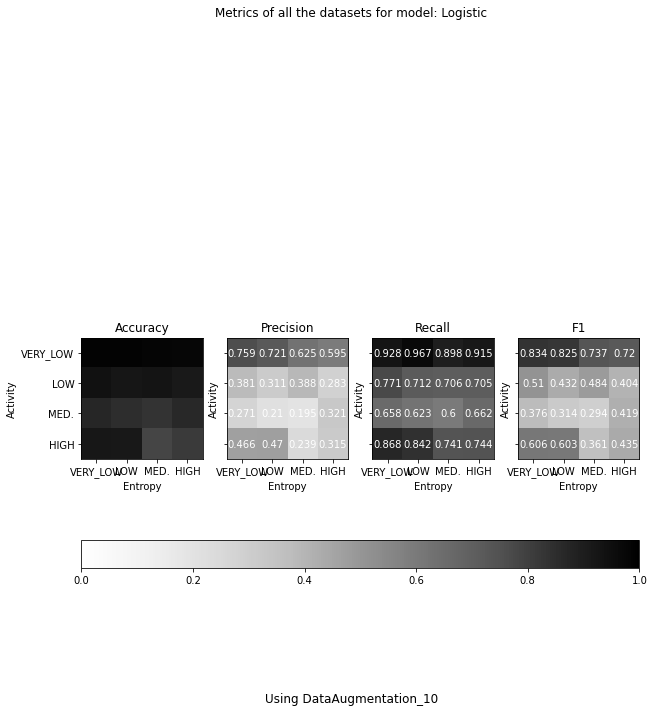

In [33]:
# Try Data Augmentation on Logistic Regression. K-fold CrossValidation

repetitions=5
num_augmentations=10

model_type='Logistic'
SelectModel(model_type)

options=['Architectural','Augment']
always_augment=False

distr='uniform'
#a,p,r,f=KFoldAugmentationDatasets(model,all_paths,repetitions,num_augmentations,True,distr)
#SaveResults(f'Results/CrossValidation/{model_type}_Architectural_Augment_{distr}_MalAugment.json',a,p,r,f)

distr='gaussian'
#a,p,r,f=KFoldAugmentationDatasets(model,all_paths,repetitions,num_augmentations,True,distr)
#SaveResults(f'Results/CrossValidation/{model_type}_Architectural_Augment_{distr}_MalAugment.json',a,p,r,f)
a,p,r,f=TestAugmentationDatasets(model,all_paths,repetitions,num_augmentations,True,distr)
SaveResults(f'Results/TestScores/{model_type}_Architectural_Augment_{distr}_MalAugment.json',a,p,r,f)

Selected Decision Tree
Path dataset/Data_31Lug2022.csv


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


Path dataset/Data_30Lug2022.csv


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


Path dataset/Data_29Lug2022.csv
Path dataset/Data_27Lug2022.csv
Path dataset/Data_26Lug2022.csv
Path dataset/Data_25Lug2022.csv
Path dataset/Data_24Lug2022.csv


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


Path dataset/Data_23Lug2022.csv


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


Path dataset/Data_22Lug2022.csv
Path dataset/Data_21Lug2022.csv
Path dataset/Data_20Lug2022.csv
Path dataset/Data_19Lug2022.csv
Path dataset/Data_18Lug2022.csv
Path dataset/Data_17Lug2022.csv


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


Path dataset/Data_12Giu2022.csv


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


Path dataset/Data_18Giu2022.csv


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


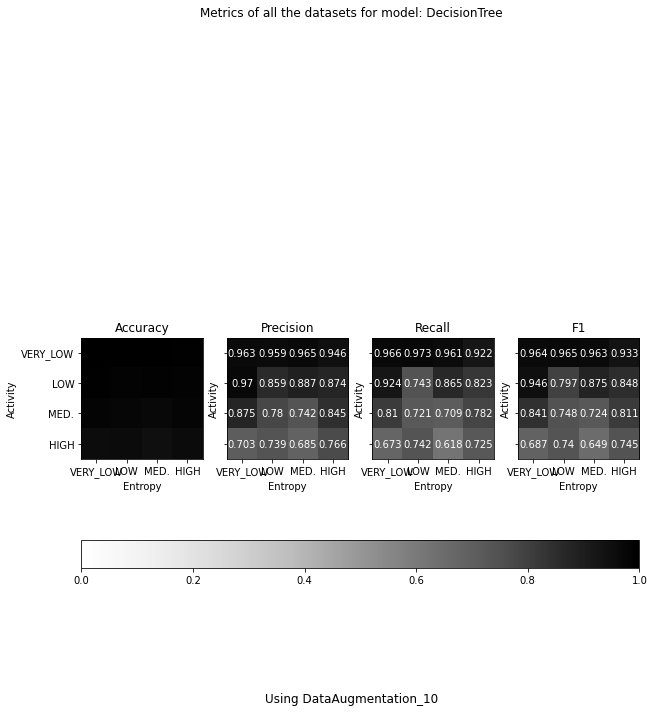

In [34]:
repetitions=5
num_augmentations=10

model_type='DecisionTree'
SelectModel(model_type)

options=['Architectural','Augment']
always_augment=False

distr='gaussian'

a,p,r,f=TestAugmentationDatasets(model,all_paths,repetitions,num_augmentations,True,distr)
SaveResults(f'Results/TestScores/{model_type}_Architectural_Augment_{distr}_MalAugment.json',a,p,r,f)

Selected SVM
Path dataset/Data_31Lug2022.csv


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 11829: expected 13 fields, saw 23\n'


Path dataset/Data_30Lug2022.csv


b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'


Path dataset/Data_29Lug2022.csv
Path dataset/Data_27Lug2022.csv
Path dataset/Data_26Lug2022.csv
Path dataset/Data_25Lug2022.csv
Path dataset/Data_24Lug2022.csv


b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'


Path dataset/Data_23Lug2022.csv


b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'


Path dataset/Data_22Lug2022.csv
Path dataset/Data_21Lug2022.csv
Path dataset/Data_20Lug2022.csv
Path dataset/Data_19Lug2022.csv
Path dataset/Data_18Lug2022.csv
Path dataset/Data_17Lug2022.csv


b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'


Path dataset/Data_12Giu2022.csv


b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'


Path dataset/Data_18Giu2022.csv


b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


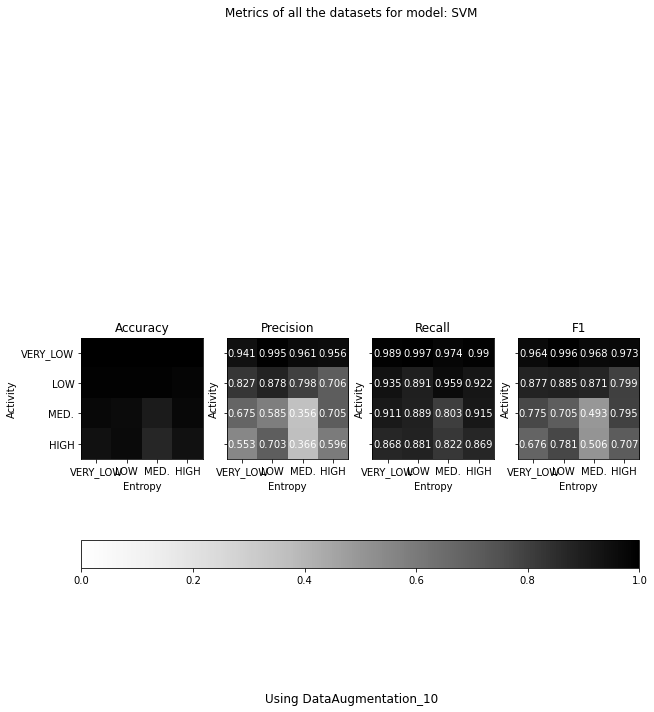

In [11]:
repetitions=5
num_augmentations=10

model_type='SVM'
SelectModel(model_type)

options=['Architectural','Augment']
always_augment=False

distr='gaussian'
a,p,r,f=TestAugmentationDatasets(model,all_paths,repetitions,num_augmentations,True,distr)
SaveResults(f'Results/TestScores/{model_type}_Architectural_Augment_{distr}_MalAugment.json',a,p,r,f)

In [21]:
# Compute some feature importance
# The criterion that we are using is the following
# Depending on the direction attribute:
#
# if direction=forward we start from an empty model
# and ADD one feature at a time, until
# the recall no longer grows significantly
#
# if direction=backward we start from a full model
# and REMOVE one feature at a time, until
# the recall no longer grows significantly

def TestFeatureImportance(model,model_type,paths,direction='forward'):
    
    results={}
    counters=['DWT_LSUCNT','DWT_CPICNT','DWT_EXCCNT','DWT_CYCCNT','DWT_SLEEPCNT','DWT_FOLDCNT','LSU_stim','CPI_stim','FLD_stim','EXC_stim','TIME']
    
    # loop through all paths
    for p in paths:
        
        model.get_untrained_model()
        meta=model.load_data(p)
        model.preprocess()
        important_features=model.feature_selection(direction=direction,tolerance=0.02)
        
        activity=meta[0].removeprefix('ACTIVITY=')
        entropy=meta[1].removeprefix('ENTROPY=')
        
        results[(activity,entropy)]=important_features
        
    plotter=Plotter(Path('figures'))
    plotter.PlotFeatureSelectionTable(counters,results,model_type)
    
    return results

In [28]:
def SaveFeatureImportance(path,imp):
    
    res={
        'VERY_LOW':None,
        'LOW':None,
        'MEDIUM':None,
        'HIGH':None
    }
    
    for key in imp:
        
        if res[key[0]] is None:
            res[key[0]]={}
        res[key[0]][key[1]]=list(imp[key])
    
    with open(path,"w") as f:
        json.dump(res,f,indent=4)
    f.close()
    

Selected Logistic Regression


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


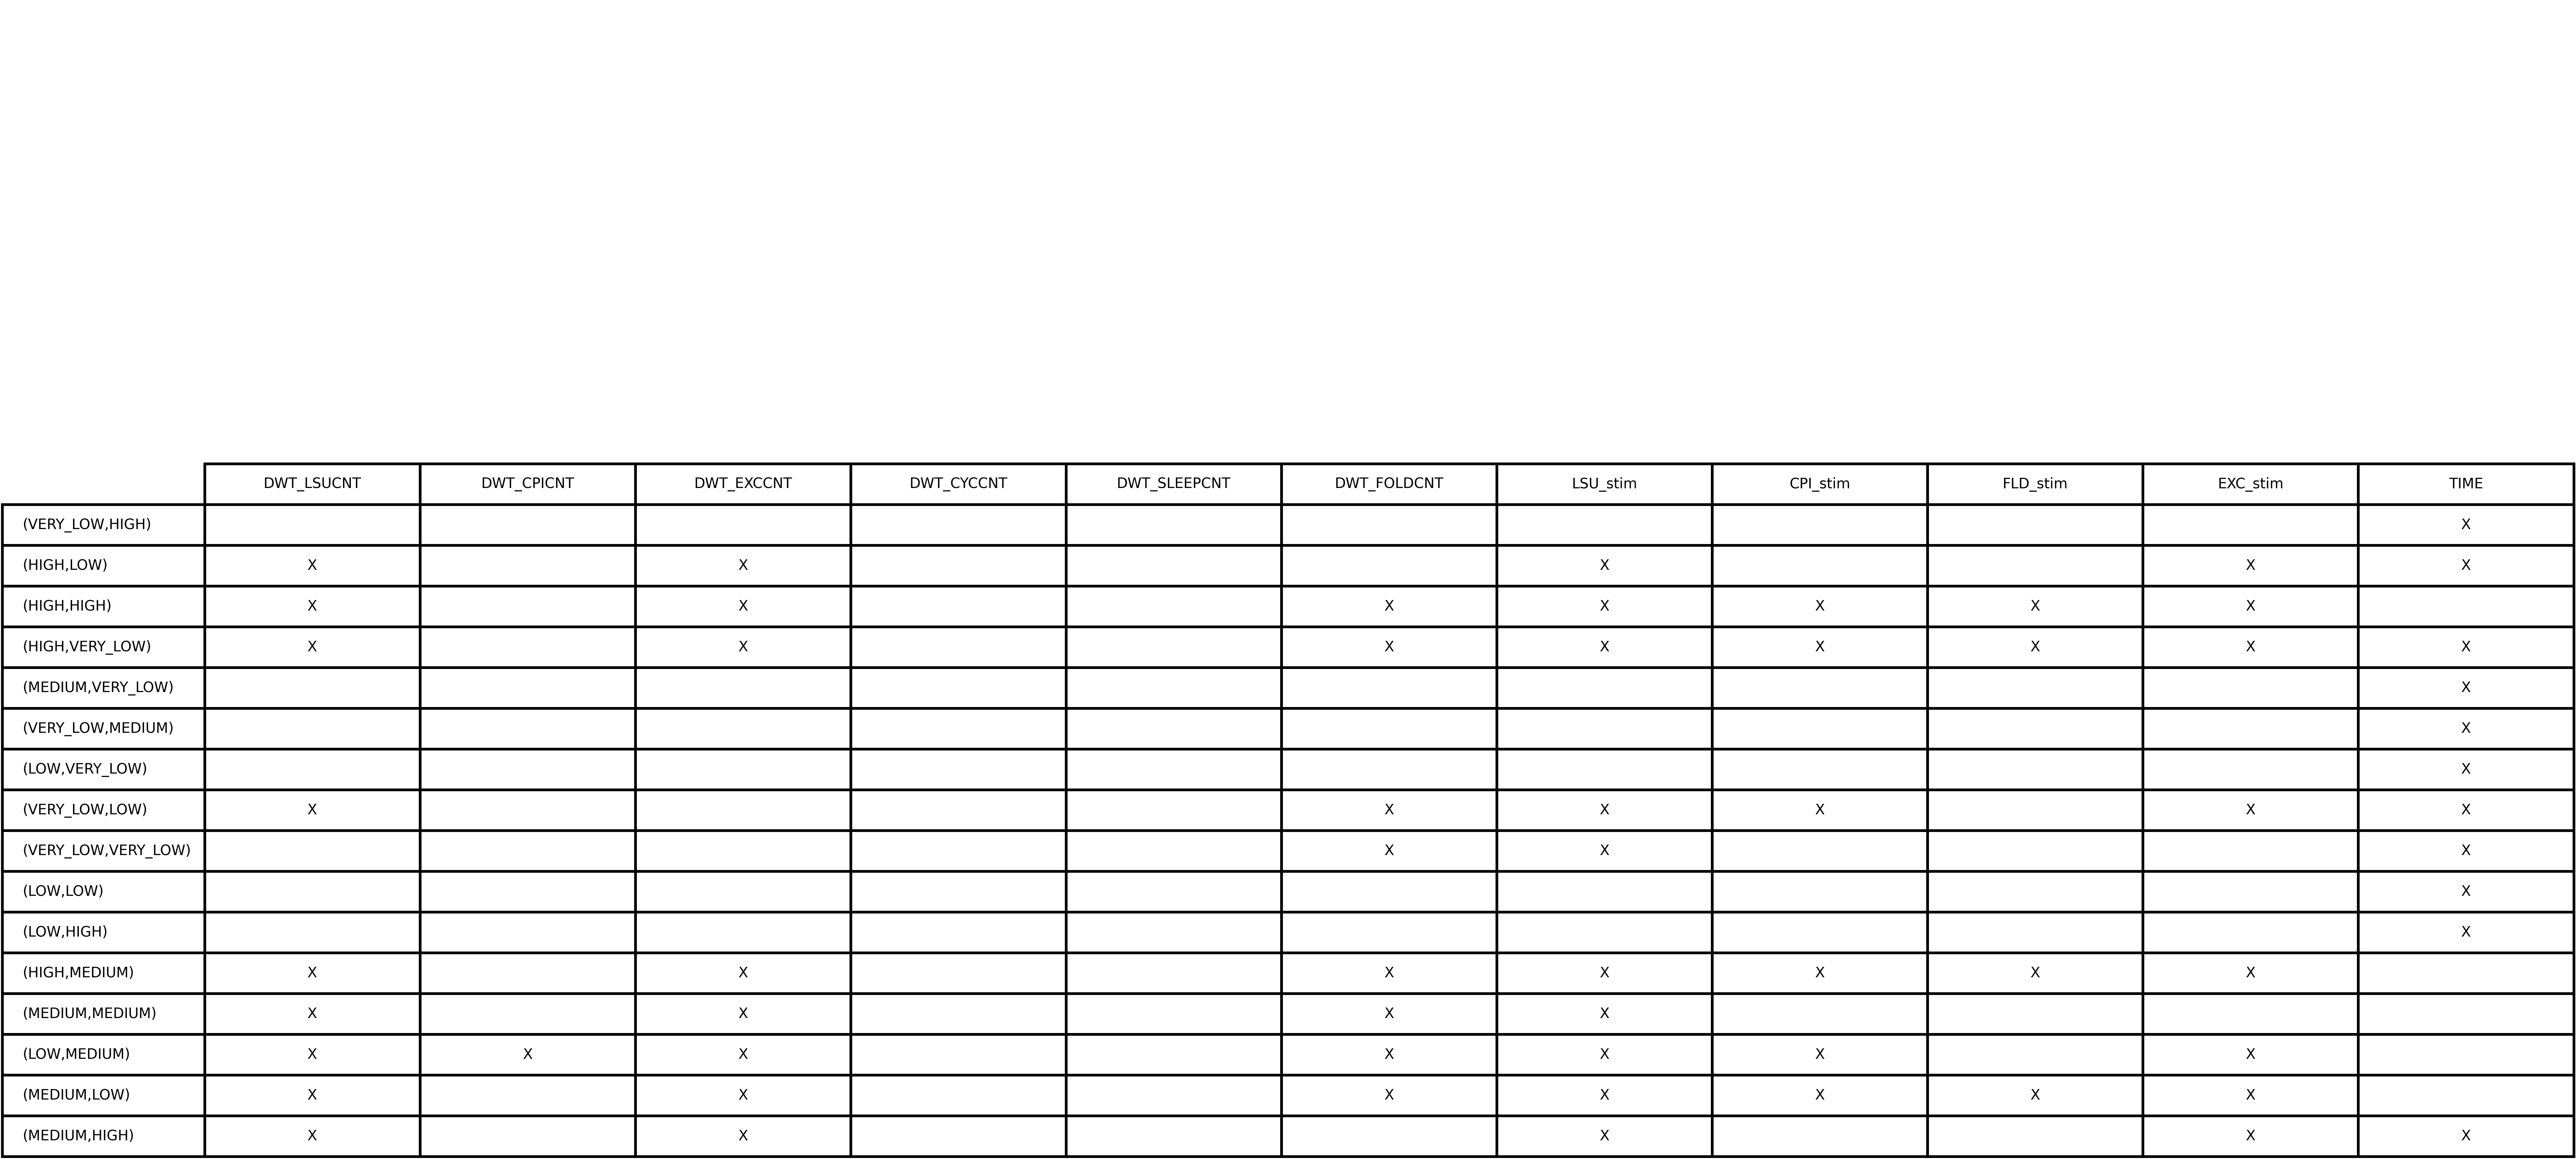

In [33]:
model_type='Logistic'
SelectModel(model_type)

imp=TestFeatureImportance(model,model_type,all_paths)
    
SaveFeatureImportance(f'Results/Importance/{model_type}_CounterImportance.json',imp)

BACKWARD SELECTION


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


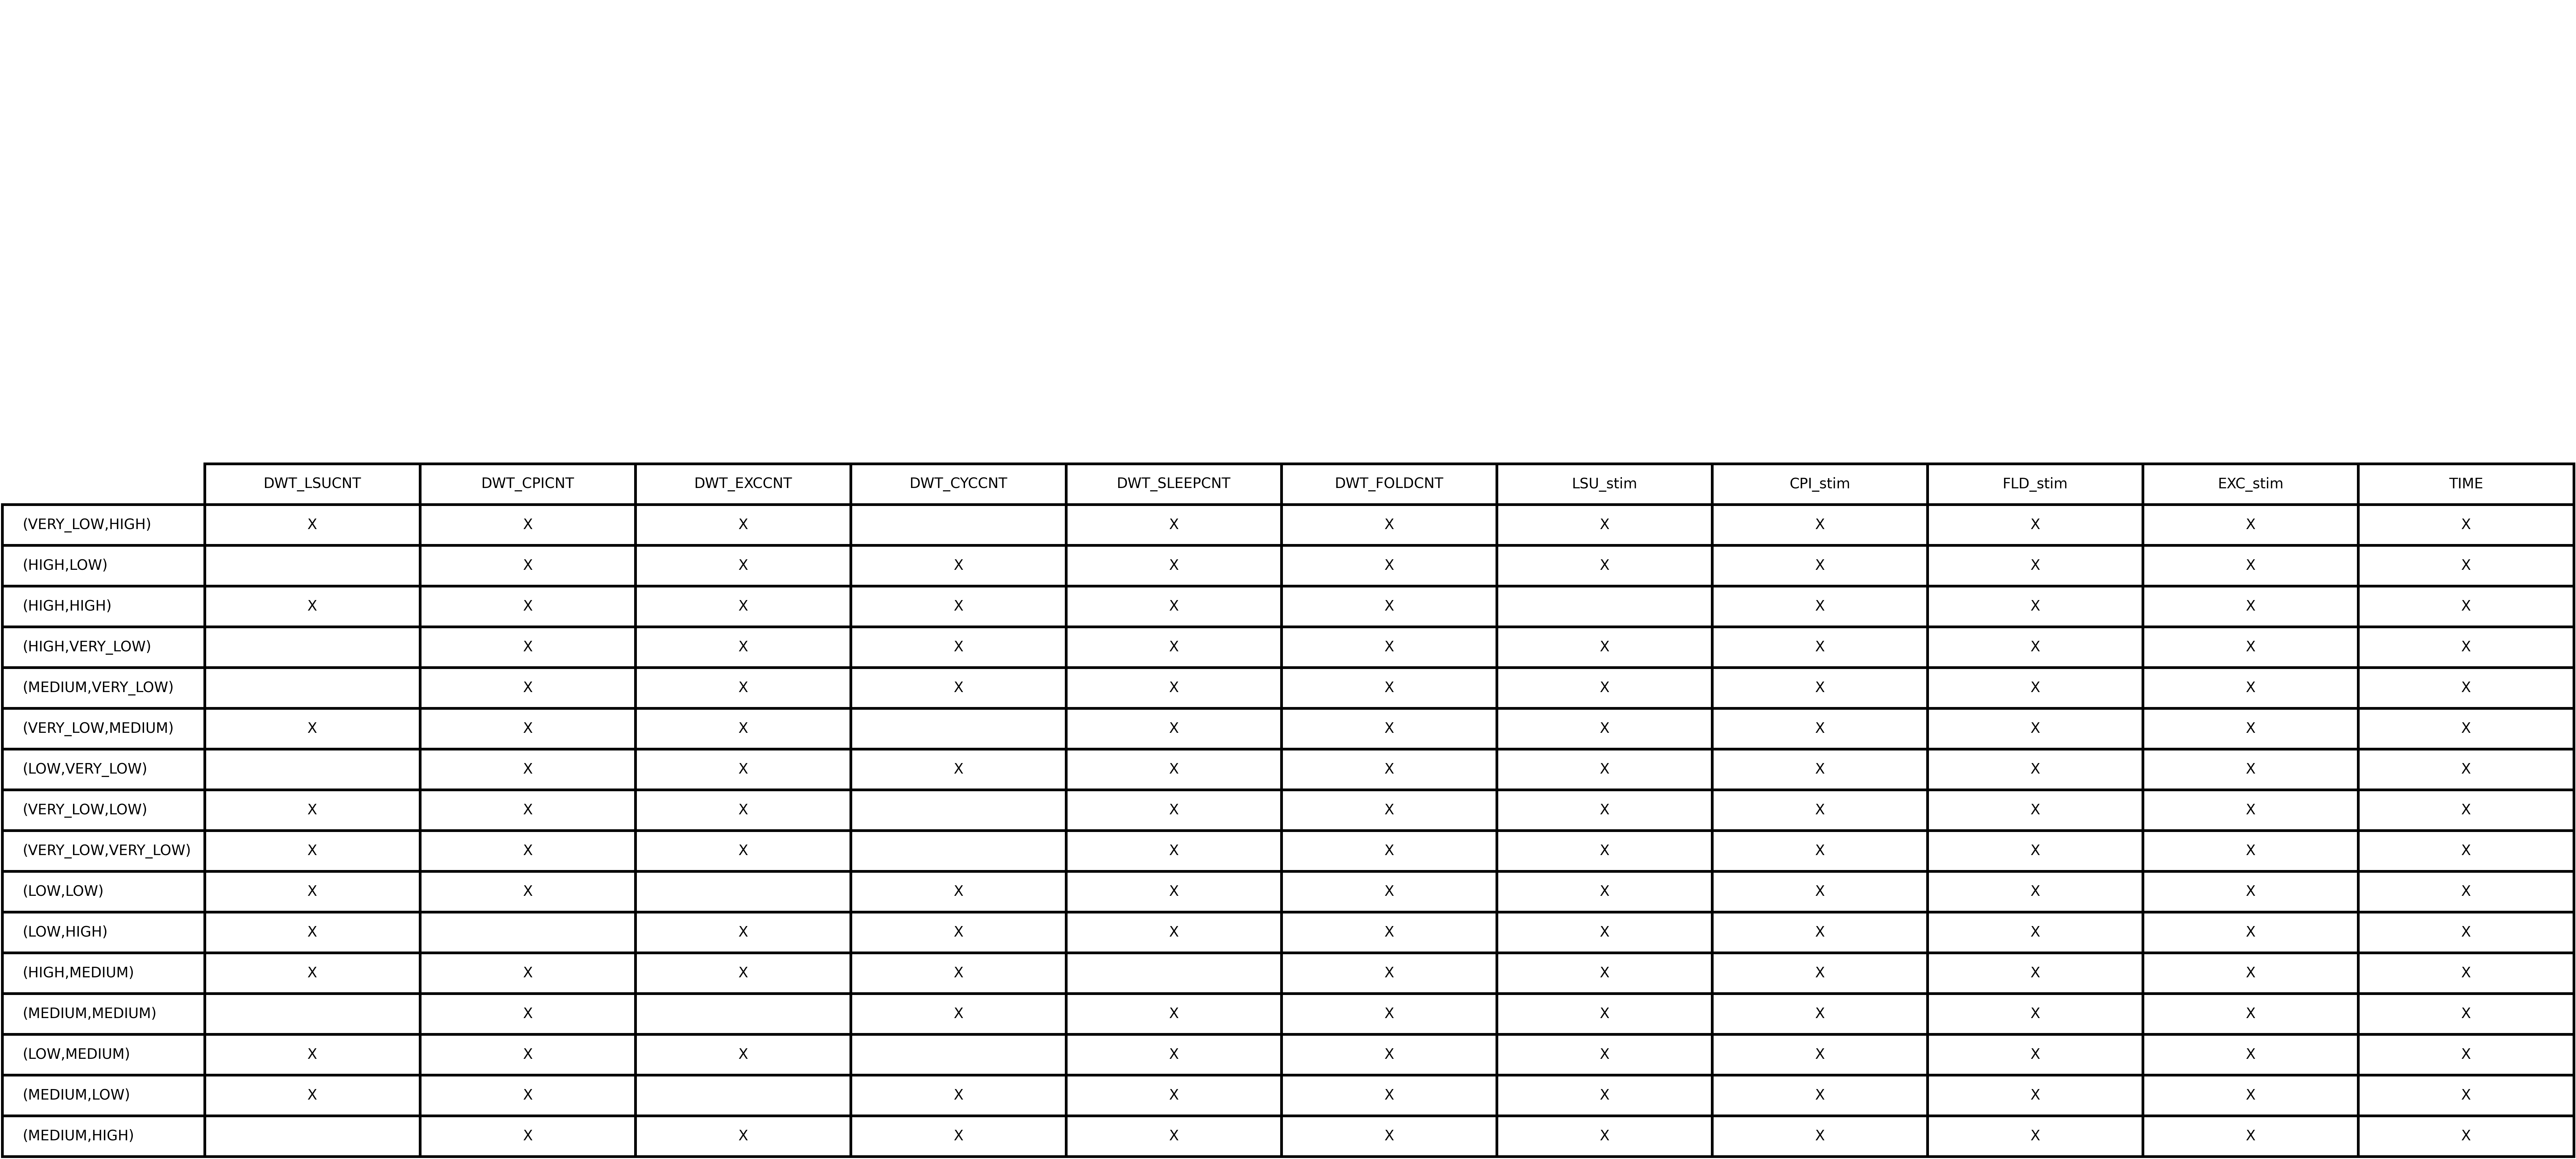

In [8]:
print("BACKWARD SELECTION")
imp=TestFeatureImportance(model,model_type,all_paths,direction='backward')

In [32]:
model_type='DecisionTree'
SelectModel(model_type)

print("FORWARD SELECTION")
imp=TestFeatureImportance(model,model_type,all_paths)
SaveFeatureImportance(f'Results/Importance/{model_type}_CounterImportance.json',imp)

Selected Decision Tree
FORWARD SELECTION


In [ ]:
print("BACKWARD SELECTION")
imp=TestFeatureImportance(model,model_type,all_paths,direction='backward')

In [29]:
model_type='SVM'
SelectModel(model_type)

#imp=TestFeatureImportance(model,model_type,all_paths)
SaveFeatureImportance(f'Results/Importance/{model_type}_CounterImportance.json',imp)

Selected SVM


b'Skipping line 11829: expected 13 fields, saw 23\n'
b'Skipping line 1405: expected 13 fields, saw 14\nSkipping line 6695: expected 13 fields, saw 20\n'
b'Skipping line 3888: expected 13 fields, saw 14\n'
b'Skipping line 2246: expected 13 fields, saw 14\n'
b'Skipping line 1894: expected 13 fields, saw 15\n'
b'Skipping line 4222: expected 13 fields, saw 18\n'
b'Skipping line 8304: expected 13 fields, saw 18\nSkipping line 9609: expected 13 fields, saw 17\n'


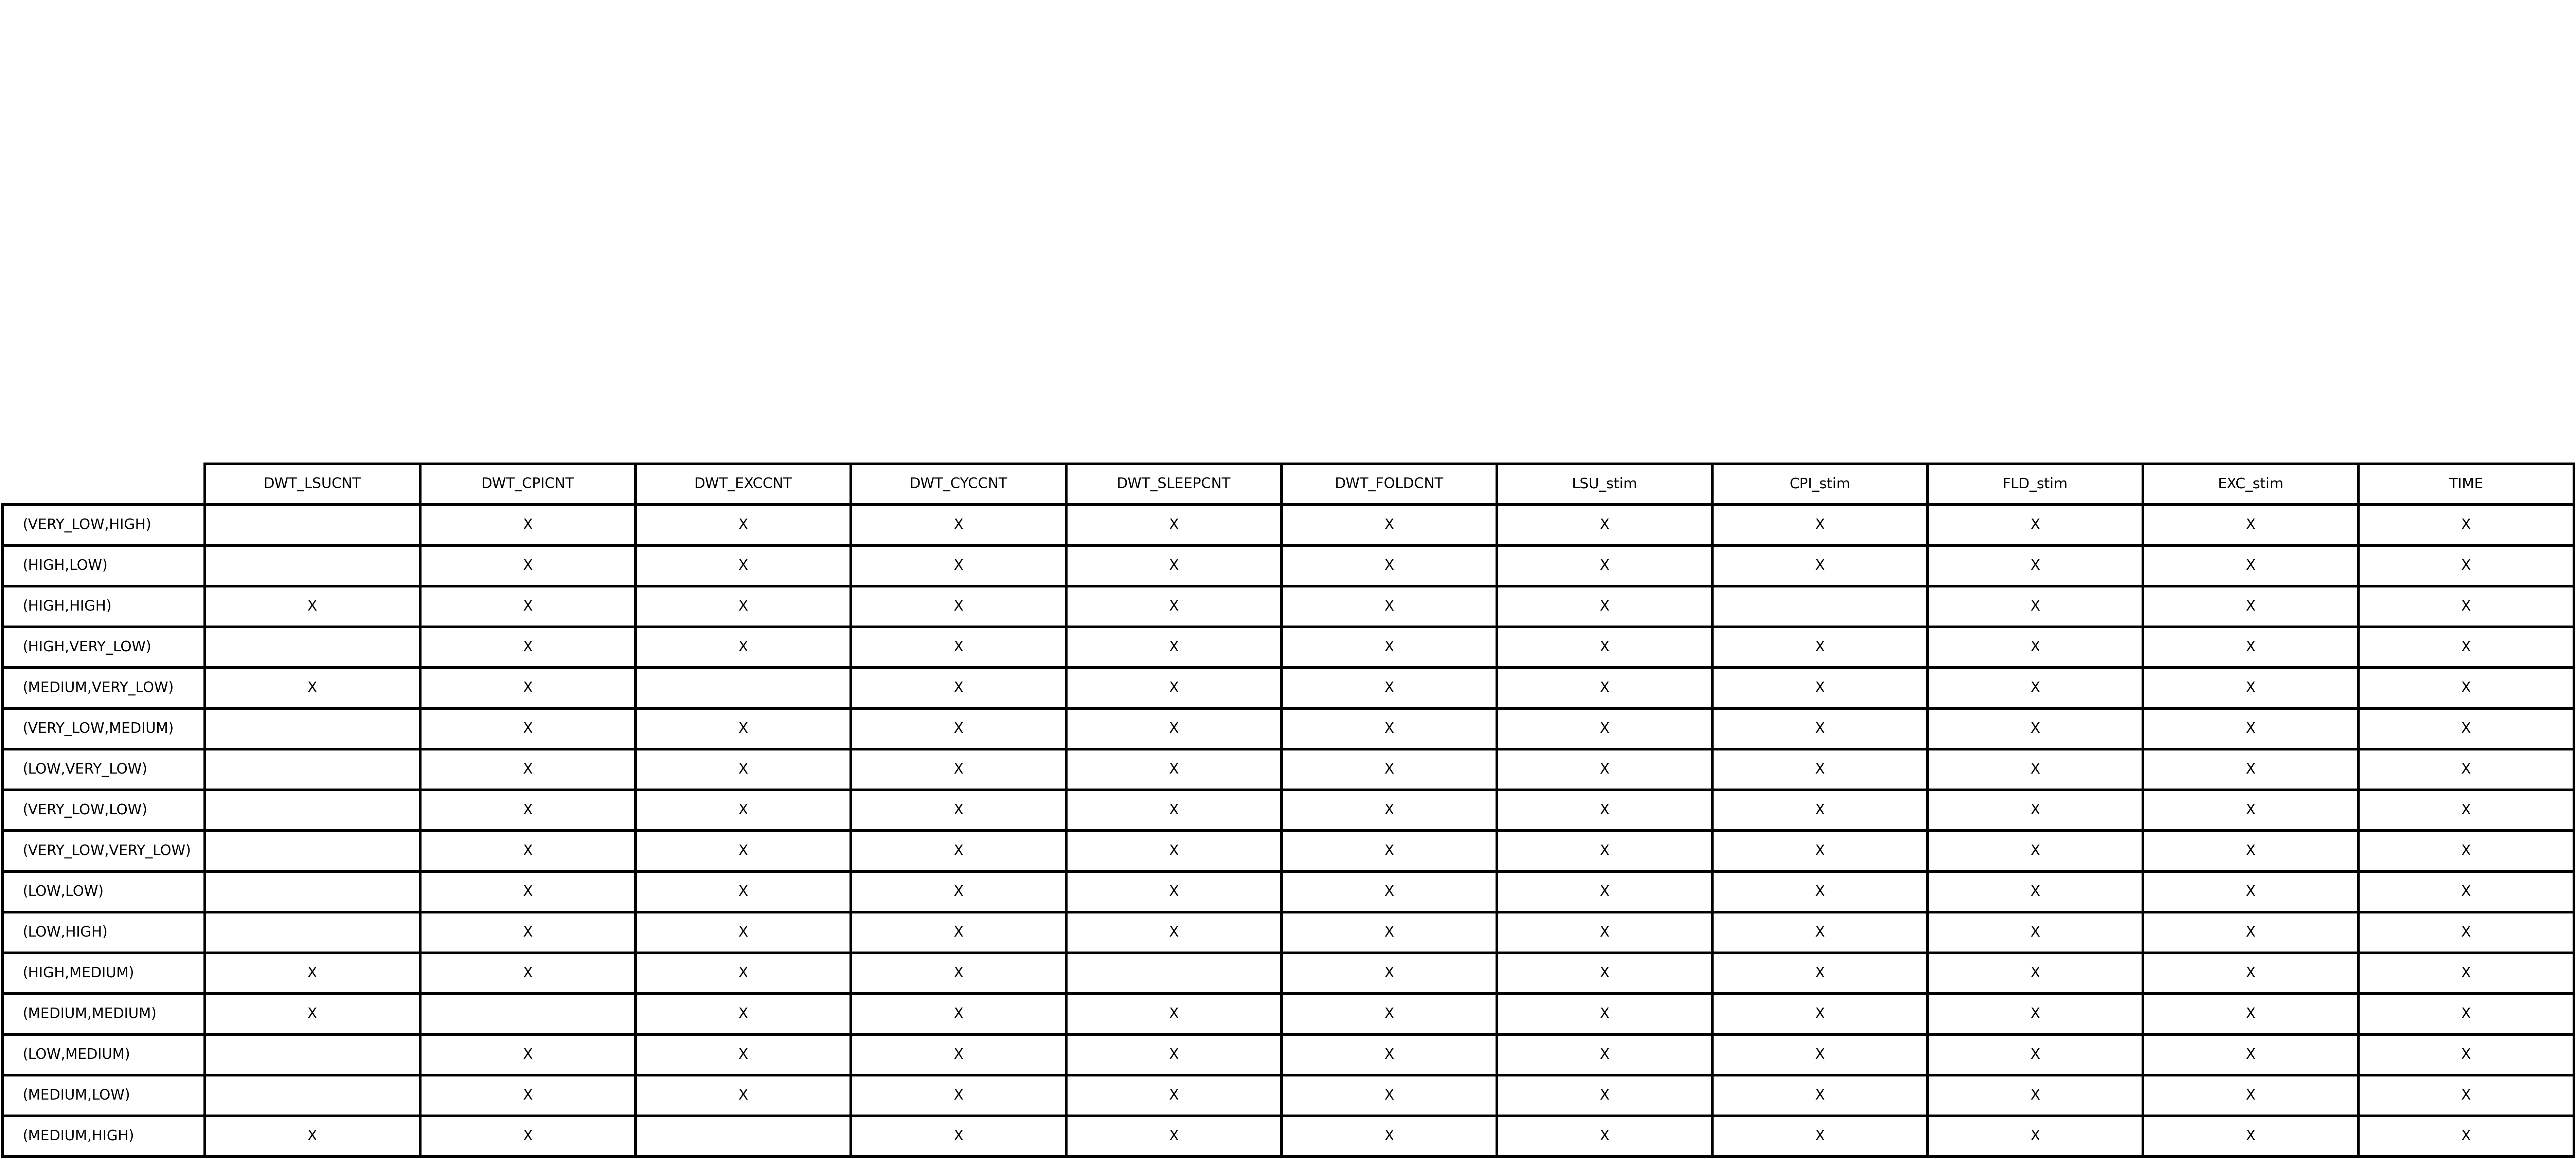

In [10]:
imp=TestFeatureImportance(model,model_type,all_paths,direction='backward')